In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Subset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import copy
import json
import pandas as pd
from functools import partial
import time
import os
import warnings
from sklearn import metrics

# --- Import our custom files ---
import quantizer
import utils

# --- 1. Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Suppress Warnings ---
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# --- 3. Define Model Names & Constants ---
BASELINE_MODEL_NAME = "bert-base-uncased" # Our fine-tuning target
SST2_LABELS = [0, 1] # 0 = negative, 1 = positive
NUM_EPOCHS_FINETUNE = 2
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
PRUNING_AMOUNT = 0.3 # 30% pruning
ACCURACY_TARGET = 0.91 # Stop greedy search if acc drops below 91%

# --- 4. Define Our Quantizer Functions ---
quant_af4_func = quantizer.quant_af4_func
quant_af8_func = quantizer.quant_af8_func

print("Setup Complete.")

/scratch/dt/adaptivfloat/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Setup Complete.


In [2]:
# --- 1. Load Raw Dataset ---
print("Loading SST-2 dataset...")
raw_dataset = load_dataset("glue", "sst2")

# --- 2. Create Tokenizer ---
print(f"Loading tokenizer for {BASELINE_MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(BASELINE_MODEL_NAME)
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], padding='max_length', truncation=True, max_length=128)

# --- 3. Create Tokenized Dataloaders ---
print("Tokenizing data...")
tokenized_dataset = raw_dataset.map(tokenize_fn, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=BATCH_SIZE)

# --- 4. Create "Quick" Loader for Sensitivity Analysis ---
val_dataset = val_dataloader.dataset
subset_indices = list(range(0, len(val_dataset), 5)) # 1/5th = 20%
quick_dataset = Subset(val_dataset, subset_indices)
quick_loader = DataLoader(quick_dataset, batch_size=val_dataloader.batch_size)
print(f"Data loaders are ready. (Train: {len(train_dataloader)}, Val: {len(val_dataloader)}, QuickVal: {len(quick_loader)})")

Loading SST-2 dataset...
Loading tokenizer for bert-base-uncased...
Tokenizing data...
Data loaders are ready. (Train: 4210, Val: 55, QuickVal: 11)


In [3]:
# --- 1. Load Fresh Model ---
print(f"Loading fresh {BASELINE_MODEL_NAME} model...")
model_fp32 = AutoModelForSequenceClassification.from_pretrained(BASELINE_MODEL_NAME, num_labels=2).to(device)
model_fp32.train()

# --- 2. Setup Optimizer ---
optimizer = AdamW(model_fp32.parameters(), lr=LEARNING_RATE)
print("--- Fine-Tuning FP32 Baseline Model ---")

for epoch in range(NUM_EPOCHS_FINETUNE):
    print(f"Starting Epoch {epoch + 1}/{NUM_EPOCHS_FINETUNE}")
    for batch in tqdm(train_dataloader, desc="Training"):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        batch['labels'] = batch.pop('label')
        outputs = model_fp32(**batch)
        loss = outputs.loss 
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} complete. Last batch loss: {loss.item()}")

model_fp32.eval()
print("--- FP32 Fine-Tuning Complete ---")

# --- 3. Save This Baseline Model ---
model_fp32.save_pretrained("./model-fp32-finetuned")
tokenizer.save_pretrained("./model-fp32-finetuned")
print("FP32 fine-tuned model saved to './model-fp32-finetuned'")

Loading fresh bert-base-uncased model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Fine-Tuning FP32 Baseline Model ---
Starting Epoch 1/2


Training: 100%|██████████| 4210/4210 [08:55<00:00,  7.86it/s]


Epoch 1 complete. Last batch loss: 0.08910372853279114
Starting Epoch 2/2


Training: 100%|██████████| 4210/4210 [08:53<00:00,  7.89it/s]


Epoch 2 complete. Last batch loss: 0.011808490380644798
--- FP32 Fine-Tuning Complete ---
FP32 fine-tuned model saved to './model-fp32-finetuned'


Evaluating: 100%|██████████| 55/55 [00:02<00:00, 23.25it/s]



--- Classification Report for: FP32 Baseline (Finetuned) ---
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       428
           1       0.94      0.89      0.91       444

    accuracy                           0.91       872
   macro avg       0.91      0.91      0.91       872
weighted avg       0.92      0.91      0.91       872



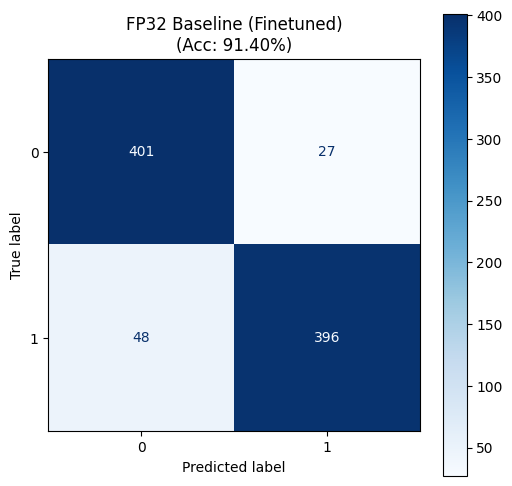

Warming up for speed test...
Measuring inference speed...


Benchmarking Speed: 100%|██████████| 55/55 [00:02<00:00, 24.05it/s]


In [4]:
fp32_results = {}
y_true, y_pred = utils.get_all_predictions(model_fp32, val_dataloader, device)
fp32_results['accuracy'] = metrics.accuracy_score(y_true, y_pred)
utils.plot_confusion_matrix(y_true, y_pred, SST2_LABELS, "FP32 Baseline (Finetuned)")
fp32_results['size_mb'] = utils.get_model_size_mb(model_fp32)
fp32_results['sparsity'] = 0.0
fp32_results['compression_ratio'] = 1.0
fp32_results['latency_ms'], fp32_results['throughput_sps'] = utils.measure_inference_speed(model_fp32, val_dataloader, device)

Loading FP32 model for pruning...
Applying 30.0% global unstructured pruning to 74 layers...
Pruning applied and made permanent.
Model sparsity is now: 23.46%
Evaluating model *immediately* after pruning...


Evaluating: 100%|██████████| 55/55 [00:02<00:00, 23.02it/s]



--- Classification Report for: FP32 - 30.0% Pruned (No Recovery) ---
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       428
           1       0.94      0.86      0.90       444

    accuracy                           0.90       872
   macro avg       0.90      0.90      0.90       872
weighted avg       0.90      0.90      0.90       872



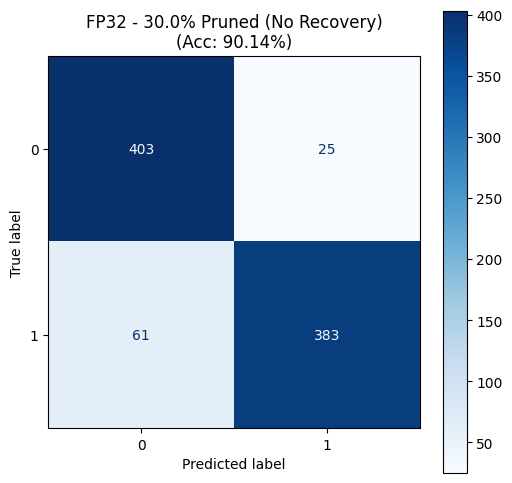

--- Fine-Tuning Pruned Model (Recovery) ---
Starting Recovery Epoch 1/2


Recovery Training:  31%|███▏      | 1319/4210 [02:47<06:06,  7.89it/s]

Recovery Training: 100%|██████████| 4210/4210 [06:31<00:00, 10.75it/s]


Epoch 1 complete. Last batch loss: 0.11428670585155487
Starting Recovery Epoch 2/2


Recovery Training: 100%|██████████| 4210/4210 [04:12<00:00, 16.67it/s]


Epoch 2 complete. Last batch loss: 0.0009611950372345746
--- Pruning Recovery Complete ---
Pruned & recovered model saved to './model-pruned-finetuned'


Evaluating: 100%|██████████| 55/55 [00:01<00:00, 50.02it/s]



--- Classification Report for: FP32 - 30.0% Pruned (Recovered) ---
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       428
           1       0.91      0.95      0.93       444

    accuracy                           0.92       872
   macro avg       0.92      0.92      0.92       872
weighted avg       0.92      0.92      0.92       872



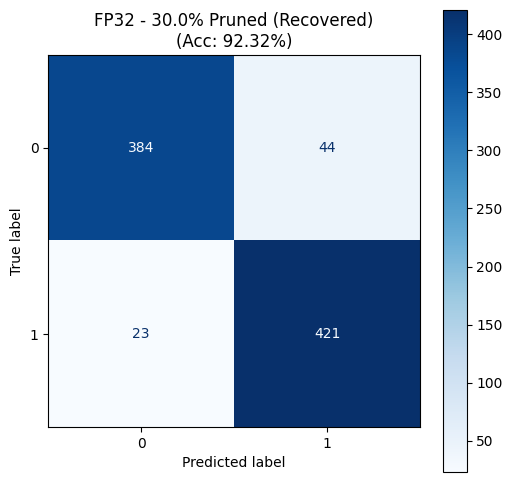

Warming up for speed test...
Measuring inference speed...


Benchmarking Speed: 100%|██████████| 55/55 [00:01<00:00, 48.51it/s]


In [5]:
# --- 1. Load a Fresh Copy of the FP32 Model ---
print("Loading FP32 model for pruning...")
model_pruned = AutoModelForSequenceClassification.from_pretrained("./model-fp32-finetuned").to(device)

# --- 2. Apply Pruning ---
utils.apply_global_pruning(model_pruned, PRUNING_AMOUNT)
sparsity_after_prune = utils.get_model_sparsity(model_pruned)
print(f"Model sparsity is now: {sparsity_after_prune:.2f}%")

# --- 3. Evaluate Immediately After Pruning (to see accuracy drop) ---
print("Evaluating model *immediately* after pruning...")
y_true, y_pred = utils.get_all_predictions(model_pruned, val_dataloader, device)
utils.plot_confusion_matrix(y_true, y_pred, SST2_LABELS, f"FP32 - {PRUNING_AMOUNT*100}% Pruned (No Recovery)")

# --- 4. Fine-Tune the Pruned Model to Recover Accuracy ---
print("--- Fine-Tuning Pruned Model (Recovery) ---")
model_pruned.train()
optimizer = AdamW(model_pruned.parameters(), lr=LEARNING_RATE / 5) # Use a smaller LR for recovery
NUM_EPOCHS_RECOVERY = 2

for epoch in range(NUM_EPOCHS_RECOVERY):
    print(f"Starting Recovery Epoch {epoch + 1}/{NUM_EPOCHS_RECOVERY}")
    for batch in tqdm(train_dataloader, desc="Recovery Training"):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        batch['labels'] = batch.pop('label')
        outputs = model_pruned(**batch)
        loss = outputs.loss 
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1} complete. Last batch loss: {loss.item()}")

model_pruned.eval()
print("--- Pruning Recovery Complete ---")
model_pruned.save_pretrained("./model-pruned-finetuned")
print("Pruned & recovered model saved to './model-pruned-finetuned'")

# --- 5. Evaluate the Recovered Pruned Model ---
pruned_results = {}
y_true, y_pred = utils.get_all_predictions(model_pruned, val_dataloader, device)
pruned_results['accuracy'] = metrics.accuracy_score(y_true, y_pred)
utils.plot_confusion_matrix(y_true, y_pred, SST2_LABELS, f"FP32 - {PRUNING_AMOUNT*100}% Pruned (Recovered)")
pruned_results['size_mb'] = utils.get_model_size_mb(model_pruned) # Size is the same
pruned_results['sparsity'] = utils.get_model_sparsity(model_pruned)
pruned_results['compression_ratio'] = 1 / (1 - pruned_results['sparsity']/100) # Compression from pruning
pruned_results['latency_ms'], pruned_results['throughput_sps'] = utils.measure_inference_speed(model_pruned, val_dataloader, device)

In [6]:
# --- 1. Load the Pruned & Recovered Model ---
print("Loading pruned model for sensitivity analysis...")
model_pruned_base = AutoModelForSequenceClassification.from_pretrained("./model-pruned-finetuned").to(device)
layer_names = [name for name, param in model_pruned_base.named_parameters() if 'weight' in name]
print(f"Found {len(layer_names)} layers to analyze.")

# --- 2. Get the INT8 Baseline (of the *Pruned* Model) ---
model_pruned_int8 = copy.deepcopy(model_pruned_base).to(device)
utils.apply_quantization_to_model(model_pruned_int8, quant_af8_func)
print("Calculating baseline INT8 (on Pruned Model) accuracy on quick loader...")
baseline_int8_acc_quick = utils.get_accuracy(model_pruned_int8, quick_loader, device)
print(f"Baseline Pruned INT8 (Quick): {baseline_int8_acc_quick * 100:.2f}%")
del model_pruned_int8
torch.cuda.empty_cache()

# --- 3. Run the Greedy Iterative Search ---
print("--- Starting Greedy Iterative Mixed-Precision Search (on Pruned Model) ---")
baseline_acc = baseline_int8_acc_quick
final_precision_profile = {layer: 'INT8' for layer in layer_names}
layers_to_test = set(layer_names)
search_history = [] 

for i in range(len(layer_names)):
    print(f"\n--- Iteration {i+1} / {len(layer_names)} ---")
    
    current_baseline_model = copy.deepcopy(model_pruned_base).to(device)
    utils.apply_quantization_to_model(current_baseline_model, final_precision_profile)
    current_baseline_acc = utils.get_accuracy(current_baseline_model, quick_loader, device)
    print(f"Current baseline accuracy: {current_baseline_acc * 100:.2f}%")
    search_history.append((i, current_baseline_acc))
    
    # Check stop condition (e.g., 1.5% drop from INT8 baseline)
    if current_baseline_acc < (baseline_int8_acc_quick - 0.015):
        print(f"Accuracy dropped below target. Stopping search.")
        final_precision_profile[last_layer_demoted] = 'INT8' # Revert last change
        search_history.pop()
        break
    
    if not layers_to_test:
        print("All layers have been demoted to INT4.")
        break

    best_layer_to_demote = None
    best_layer_accuracy = -1.0
    
    for layer_name in tqdm(list(layers_to_test), desc="Finding next best layer"):
        test_profile = final_precision_profile.copy()
        test_profile[layer_name] = 'INT4'
        test_model = copy.deepcopy(model_pruned_base).to(device)
        utils.apply_quantization_to_model(test_model, test_profile)
        acc = utils.get_accuracy(test_model, quick_loader, device)
        
        if acc > best_layer_accuracy:
            best_layer_accuracy = acc
            best_layer_to_demote = layer_name
        del test_model
        torch.cuda.empty_cache()

    final_precision_profile[best_layer_to_demote] = 'INT4'
    layers_to_test.remove(best_layer_to_demote)
    last_layer_demoted = best_layer_to_demote
    print(f"Demoting layer: {best_layer_to_demote} (New Acc: {best_layer_accuracy * 100:.2f}%)")
    del current_baseline_model

print("--- Greedy Search Complete ---")
num_int4 = list(final_precision_profile.values()).count('INT4')
num_int8 = len(final_precision_profile) - num_int4
print(f"Created OPTIMAL profile with {num_int4} layers at INT4 and {num_int8} at INT8")
with open('hybrid_precision_profile.json', 'w') as f:
    json.dump(final_precision_profile, f, indent=4)
print("Hybrid profile saved to 'hybrid_precision_profile.json'")

Loading pruned model for sensitivity analysis...
Found 102 layers to analyze.
Applying UNIFORM quantization with AdaptivFloat_8bit...
Quantization complete.
Calculating baseline INT8 (on Pruned Model) accuracy on quick loader...


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.16it/s]

Baseline Pruned INT8 (Quick): 94.29%


--- Starting Greedy Iterative Mixed-Precision Search (on Pruned Model) ---

--- Iteration 1 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.18it/s]


Current baseline accuracy: 94.29%


Finding next best layer:   0%|          | 0/102 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/102 [00:00<00:27,  3.71it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/102 [00:00<00:28,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/102 [00:00<00:28,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/102 [00:01<00:28,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 5/102 [00:01<00:27,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 6/102 [00:01<00:27,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 7/102 [00:01<00:26,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 8/102 [00:02<00:26,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 9/102 [00:02<00:26,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 10/102 [00:02<00:25,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 11/102 [00:03<00:25,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 12/102 [00:03<00:25,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 13/102 [00:03<00:24,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 14/102 [00:03<00:24,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 15/102 [00:04<00:24,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 16/102 [00:04<00:24,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 17/102 [00:04<00:23,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 18/102 [00:05<00:23,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▊        | 19/102 [00:05<00:23,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 20/102 [00:05<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 21/102 [00:05<00:22,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 22/102 [00:06<00:22,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 23/102 [00:06<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 24/102 [00:06<00:21,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 25/102 [00:07<00:21,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 26/102 [00:07<00:25,  2.94it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 27/102 [00:07<00:24,  3.07it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 28/102 [00:08<00:23,  3.19it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 29/102 [00:08<00:22,  3.29it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 30/102 [00:08<00:21,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 31/102 [00:08<00:21,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 32/102 [00:09<00:20,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 33/102 [00:09<00:20,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 34/102 [00:09<00:19,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 35/102 [00:10<00:19,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 36/102 [00:10<00:19,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 37/102 [00:10<00:18,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 38/102 [00:10<00:18,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 39/102 [00:11<00:17,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 40/102 [00:11<00:17,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 41/102 [00:11<00:17,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 42/102 [00:12<00:17,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 43/102 [00:12<00:16,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 44/102 [00:12<00:16,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 45/102 [00:12<00:16,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 46/102 [00:13<00:15,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 47/102 [00:13<00:15,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 48/102 [00:13<00:15,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 49/102 [00:14<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 50/102 [00:14<00:15,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 51/102 [00:14<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 52/102 [00:14<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 53/102 [00:15<00:13,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 54/102 [00:15<00:13,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 55/102 [00:15<00:13,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 56/102 [00:16<00:13,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 57/102 [00:16<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 58/102 [00:16<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 59/102 [00:16<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 60/102 [00:17<00:12,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 61/102 [00:17<00:11,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 62/102 [00:17<00:11,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 63/102 [00:18<00:11,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 64/102 [00:18<00:10,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 65/102 [00:18<00:10,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 66/102 [00:18<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 67/102 [00:19<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 68/102 [00:19<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 69/102 [00:19<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▊   | 70/102 [00:20<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 71/102 [00:20<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 72/102 [00:20<00:08,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 73/102 [00:20<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 74/102 [00:21<00:08,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 75/102 [00:21<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 76/102 [00:21<00:07,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 77/102 [00:22<00:07,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 78/102 [00:22<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 79/102 [00:22<00:06,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 80/102 [00:22<00:06,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 81/102 [00:23<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 82/102 [00:23<00:05,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 83/102 [00:23<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 84/102 [00:24<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 85/102 [00:24<00:04,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 86/102 [00:24<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 87/102 [00:24<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 88/102 [00:25<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 89/102 [00:25<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 90/102 [00:25<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 91/102 [00:26<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 92/102 [00:26<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 93/102 [00:26<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 94/102 [00:26<00:02,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 95/102 [00:27<00:01,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 96/102 [00:27<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 97/102 [00:27<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 98/102 [00:28<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 99/102 [00:28<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 100/102 [00:28<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 101/102 [00:28<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 102/102 [00:29<00:00,  3.49it/s]


Demoting layer: bert.embeddings.token_type_embeddings.weight (New Acc: 95.43%)

--- Iteration 2 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 55.61it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/101 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/101 [00:00<00:27,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/101 [00:00<00:28,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/101 [00:00<00:28,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/101 [00:01<00:34,  2.81it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 5/101 [00:01<00:31,  3.04it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 6/101 [00:01<00:29,  3.20it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 7/101 [00:02<00:28,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 8/101 [00:02<00:27,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 9/101 [00:02<00:26,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 10/101 [00:03<00:26,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 11/101 [00:03<00:25,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 12/101 [00:03<00:25,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 13/101 [00:03<00:24,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 14/101 [00:04<00:24,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 15/101 [00:04<00:24,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 16/101 [00:04<00:23,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 17/101 [00:04<00:23,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 18/101 [00:05<00:23,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 19/101 [00:05<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 20/101 [00:05<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 21/101 [00:06<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 22/101 [00:06<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 23/101 [00:06<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 24/101 [00:06<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 25/101 [00:07<00:21,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 26/101 [00:07<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 27/101 [00:07<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 28/101 [00:08<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 29/101 [00:08<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 30/101 [00:08<00:19,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 31/101 [00:08<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 32/101 [00:09<00:19,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 33/101 [00:09<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▎      | 34/101 [00:09<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 35/101 [00:10<00:18,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 36/101 [00:10<00:18,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 37/101 [00:10<00:17,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 38/101 [00:10<00:17,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▊      | 39/101 [00:11<00:17,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 40/101 [00:11<00:17,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 41/101 [00:11<00:17,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 42/101 [00:12<00:17,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 43/101 [00:12<00:16,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▎     | 44/101 [00:12<00:16,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 45/101 [00:12<00:16,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 46/101 [00:13<00:16,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 47/101 [00:13<00:15,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 48/101 [00:13<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▊     | 49/101 [00:14<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|████▉     | 50/101 [00:14<00:14,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 51/101 [00:14<00:14,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████▏    | 52/101 [00:14<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 53/101 [00:15<00:13,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 54/101 [00:15<00:13,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 55/101 [00:15<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 56/101 [00:16<00:12,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 57/101 [00:16<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 58/101 [00:16<00:12,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 59/101 [00:16<00:12,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 60/101 [00:17<00:11,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 61/101 [00:17<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████▏   | 62/101 [00:17<00:11,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 63/101 [00:18<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 64/101 [00:18<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 65/101 [00:18<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 66/101 [00:18<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▋   | 67/101 [00:19<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 68/101 [00:19<00:09,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 69/101 [00:19<00:09,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 70/101 [00:20<00:08,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 71/101 [00:20<00:08,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 72/101 [00:20<00:08,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 73/101 [00:20<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 74/101 [00:21<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 75/101 [00:21<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 76/101 [00:21<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 77/101 [00:22<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 78/101 [00:22<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 79/101 [00:22<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 80/101 [00:22<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 81/101 [00:23<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 82/101 [00:23<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 83/101 [00:23<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 84/101 [00:24<00:05,  2.92it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 85/101 [00:24<00:05,  3.06it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 86/101 [00:24<00:04,  3.17it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 87/101 [00:25<00:04,  3.24it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 88/101 [00:25<00:03,  3.31it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 89/101 [00:25<00:03,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 90/101 [00:26<00:03,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 91/101 [00:26<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 92/101 [00:26<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 93/101 [00:26<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 94/101 [00:27<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 95/101 [00:27<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 96/101 [00:27<00:01,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 97/101 [00:28<00:01,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 98/101 [00:28<00:00,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 99/101 [00:28<00:00,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 100/101 [00:28<00:00,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 101/101 [00:29<00:00,  3.46it/s]


Demoting layer: bert.encoder.layer.1.attention.self.key.weight (New Acc: 95.43%)

--- Iteration 3 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.18it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/100 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/100 [00:00<00:26,  3.69it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/100 [00:00<00:27,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/100 [00:00<00:27,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/100 [00:01<00:27,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 5/100 [00:01<00:27,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 6/100 [00:01<00:26,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 7/100 [00:01<00:26,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 8/100 [00:02<00:26,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 9/100 [00:02<00:25,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 10/100 [00:02<00:25,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 11/100 [00:03<00:25,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 12/100 [00:03<00:25,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 13/100 [00:03<00:25,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 14/100 [00:04<00:24,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 15/100 [00:04<00:24,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 16/100 [00:04<00:24,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 17/100 [00:04<00:23,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 18/100 [00:05<00:23,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 19/100 [00:05<00:23,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 20/100 [00:05<00:23,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 21/100 [00:06<00:22,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 22/100 [00:06<00:22,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 23/100 [00:06<00:22,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 24/100 [00:06<00:21,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 25/100 [00:07<00:21,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 26/100 [00:07<00:20,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 27/100 [00:07<00:20,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 28/100 [00:08<00:20,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 29/100 [00:08<00:20,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 30/100 [00:08<00:20,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 31/100 [00:08<00:19,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 32/100 [00:09<00:19,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 33/100 [00:09<00:19,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 34/100 [00:09<00:19,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 35/100 [00:10<00:18,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 36/100 [00:10<00:18,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 37/100 [00:10<00:18,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 38/100 [00:10<00:17,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 39/100 [00:11<00:17,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 40/100 [00:11<00:17,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 41/100 [00:11<00:16,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 42/100 [00:12<00:16,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 43/100 [00:12<00:16,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 44/100 [00:12<00:15,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 45/100 [00:12<00:15,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 46/100 [00:13<00:15,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 47/100 [00:13<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 48/100 [00:13<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 49/100 [00:14<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 50/100 [00:14<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 51/100 [00:14<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 52/100 [00:14<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 53/100 [00:15<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 54/100 [00:15<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 55/100 [00:15<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 56/100 [00:15<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 57/100 [00:16<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 58/100 [00:16<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 59/100 [00:16<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 60/100 [00:17<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 61/100 [00:17<00:13,  2.97it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 62/100 [00:17<00:12,  3.10it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 63/100 [00:18<00:11,  3.19it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 64/100 [00:18<00:10,  3.27it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 65/100 [00:18<00:10,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 66/100 [00:19<00:10,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 67/100 [00:19<00:09,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 68/100 [00:19<00:09,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 69/100 [00:19<00:09,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 70/100 [00:20<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 71/100 [00:20<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 72/100 [00:20<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 73/100 [00:21<00:07,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 74/100 [00:21<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 75/100 [00:21<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 76/100 [00:21<00:06,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 77/100 [00:22<00:06,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 78/100 [00:22<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 79/100 [00:22<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 80/100 [00:22<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 81/100 [00:23<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 82/100 [00:23<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 83/100 [00:23<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 84/100 [00:24<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 85/100 [00:24<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 86/100 [00:24<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 87/100 [00:24<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 88/100 [00:25<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 89/100 [00:25<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 90/100 [00:25<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 91/100 [00:26<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 92/100 [00:26<00:02,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 93/100 [00:26<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 94/100 [00:26<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 95/100 [00:27<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 96/100 [00:27<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 97/100 [00:27<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 98/100 [00:28<00:00,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 99/100 [00:28<00:00,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]


Demoting layer: classifier.weight (New Acc: 95.43%)

--- Iteration 4 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 54.58it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/99 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/99 [00:00<00:27,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/99 [00:00<00:28,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/99 [00:00<00:27,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/99 [00:01<00:27,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 5/99 [00:01<00:27,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 6/99 [00:01<00:26,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 7/99 [00:02<00:26,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 8/99 [00:02<00:25,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 9/99 [00:02<00:25,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 10/99 [00:02<00:25,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 11/99 [00:03<00:24,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 12/99 [00:03<00:24,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 13/99 [00:03<00:24,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 14/99 [00:03<00:23,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 15/99 [00:04<00:23,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 16/99 [00:04<00:23,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 17/99 [00:04<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 18/99 [00:05<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 19/99 [00:05<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 20/99 [00:05<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 21/99 [00:05<00:21,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 22/99 [00:06<00:21,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 23/99 [00:06<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 24/99 [00:06<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 25/99 [00:07<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 26/99 [00:07<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 27/99 [00:07<00:20,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 28/99 [00:07<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 29/99 [00:08<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 30/99 [00:08<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 31/99 [00:08<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 32/99 [00:09<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 33/99 [00:09<00:18,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 34/99 [00:09<00:18,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 35/99 [00:09<00:18,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 36/99 [00:10<00:18,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 37/99 [00:10<00:17,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 38/99 [00:10<00:17,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 39/99 [00:11<00:17,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 40/99 [00:11<00:17,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 41/99 [00:11<00:19,  2.99it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 42/99 [00:12<00:18,  3.12it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 43/99 [00:12<00:17,  3.22it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 44/99 [00:12<00:16,  3.28it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 45/99 [00:12<00:16,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 46/99 [00:13<00:15,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 47/99 [00:13<00:15,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 48/99 [00:13<00:14,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 49/99 [00:14<00:14,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 50/99 [00:14<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 51/99 [00:14<00:13,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 52/99 [00:14<00:13,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▎    | 53/99 [00:15<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 54/99 [00:15<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 55/99 [00:15<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 56/99 [00:16<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 57/99 [00:16<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▊    | 58/99 [00:16<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 59/99 [00:16<00:11,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 60/99 [00:17<00:11,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 61/99 [00:17<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 62/99 [00:17<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 63/99 [00:18<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 64/99 [00:18<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 65/99 [00:18<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 66/99 [00:18<00:09,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 67/99 [00:19<00:09,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▊   | 68/99 [00:19<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 69/99 [00:19<00:08,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 70/99 [00:20<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 71/99 [00:20<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 72/99 [00:20<00:07,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 73/99 [00:20<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 74/99 [00:21<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 75/99 [00:21<00:06,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 76/99 [00:21<00:06,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 77/99 [00:22<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 78/99 [00:22<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 79/99 [00:22<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 80/99 [00:22<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 81/99 [00:23<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 82/99 [00:23<00:04,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 83/99 [00:23<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 84/99 [00:23<00:04,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 85/99 [00:24<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 86/99 [00:24<00:03,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 87/99 [00:24<00:03,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 88/99 [00:25<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 89/99 [00:25<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 90/99 [00:25<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 91/99 [00:25<00:02,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 92/99 [00:26<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 93/99 [00:26<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 94/99 [00:26<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 95/99 [00:27<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 96/99 [00:27<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 97/99 [00:27<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 98/99 [00:27<00:00,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 99/99 [00:28<00:00,  3.51it/s]


Demoting layer: bert.encoder.layer.10.attention.self.key.weight (New Acc: 95.43%)

--- Iteration 5 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.02it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/98 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/98 [00:00<00:26,  3.70it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/98 [00:00<00:27,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/98 [00:00<00:26,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/98 [00:01<00:27,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 5/98 [00:01<00:26,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 6/98 [00:01<00:26,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 7/98 [00:01<00:25,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 8/98 [00:02<00:25,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 9/98 [00:02<00:25,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 10/98 [00:02<00:25,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 11/98 [00:03<00:25,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 12/98 [00:03<00:24,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 13/98 [00:03<00:24,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 14/98 [00:04<00:24,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 15/98 [00:04<00:24,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 16/98 [00:04<00:23,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 17/98 [00:04<00:23,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 18/98 [00:05<00:23,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 19/98 [00:05<00:22,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 20/98 [00:05<00:26,  2.98it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██▏       | 21/98 [00:06<00:24,  3.13it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 22/98 [00:06<00:23,  3.24it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 23/98 [00:06<00:22,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 24/98 [00:07<00:21,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 25/98 [00:07<00:21,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 26/98 [00:07<00:20,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 27/98 [00:07<00:20,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 28/98 [00:08<00:19,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 29/98 [00:08<00:19,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 30/98 [00:08<00:19,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 31/98 [00:08<00:18,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 32/98 [00:09<00:18,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▎      | 33/98 [00:09<00:18,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 34/98 [00:09<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 35/98 [00:10<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 36/98 [00:10<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 37/98 [00:10<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 38/98 [00:10<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 39/98 [00:11<00:16,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 40/98 [00:11<00:16,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 41/98 [00:11<00:15,  3.59it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 42/98 [00:12<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 43/98 [00:12<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 44/98 [00:12<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 45/98 [00:12<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 46/98 [00:13<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 47/98 [00:13<00:14,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 48/98 [00:13<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 49/98 [00:14<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 50/98 [00:14<00:13,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 51/98 [00:14<00:13,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 52/98 [00:14<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 53/98 [00:15<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 54/98 [00:15<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 55/98 [00:15<00:12,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 56/98 [00:16<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 57/98 [00:16<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 58/98 [00:16<00:11,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 59/98 [00:16<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 60/98 [00:17<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 61/98 [00:17<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 62/98 [00:17<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 63/98 [00:18<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 64/98 [00:18<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▋   | 65/98 [00:18<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 66/98 [00:18<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 67/98 [00:19<00:08,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 68/98 [00:19<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 69/98 [00:19<00:08,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 70/98 [00:20<00:07,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 71/98 [00:20<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 72/98 [00:20<00:07,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 73/98 [00:20<00:07,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 74/98 [00:21<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 75/98 [00:21<00:06,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 76/98 [00:21<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▊  | 77/98 [00:22<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 78/98 [00:22<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 79/98 [00:22<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 80/98 [00:22<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 81/98 [00:23<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 82/98 [00:23<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 83/98 [00:23<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 84/98 [00:23<00:03,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 85/98 [00:24<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 86/98 [00:24<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 87/98 [00:24<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 88/98 [00:25<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 89/98 [00:25<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 90/98 [00:25<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 91/98 [00:25<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 92/98 [00:26<00:01,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 93/98 [00:26<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 94/98 [00:26<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 95/98 [00:27<00:00,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 96/98 [00:27<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 97/98 [00:27<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]


Demoting layer: bert.encoder.layer.7.attention.self.value.weight (New Acc: 95.43%)

--- Iteration 6 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 56.77it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/97 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/97 [00:00<00:27,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/97 [00:00<00:27,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/97 [00:01<00:33,  2.78it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/97 [00:01<00:31,  3.00it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 5/97 [00:01<00:29,  3.14it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 6/97 [00:01<00:28,  3.20it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 7/97 [00:02<00:27,  3.28it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 8/97 [00:02<00:26,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 9/97 [00:02<00:26,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 10/97 [00:03<00:25,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 11/97 [00:03<00:24,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 12/97 [00:03<00:24,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 13/97 [00:03<00:23,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 14/97 [00:04<00:23,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 15/97 [00:04<00:23,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 16/97 [00:04<00:22,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 17/97 [00:05<00:22,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▊        | 18/97 [00:05<00:22,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 19/97 [00:05<00:22,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 20/97 [00:05<00:22,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 21/97 [00:06<00:22,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 22/97 [00:06<00:21,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 23/97 [00:06<00:21,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 24/97 [00:07<00:21,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 25/97 [00:07<00:20,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 26/97 [00:07<00:20,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 27/97 [00:07<00:20,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 28/97 [00:08<00:19,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 29/97 [00:08<00:19,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 30/97 [00:08<00:19,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 31/97 [00:09<00:18,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 32/97 [00:09<00:18,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 33/97 [00:09<00:18,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 34/97 [00:09<00:17,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 35/97 [00:10<00:17,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 36/97 [00:10<00:17,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 37/97 [00:10<00:16,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 38/97 [00:11<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 39/97 [00:11<00:16,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 40/97 [00:11<00:15,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 41/97 [00:11<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 42/97 [00:12<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 43/97 [00:12<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 44/97 [00:12<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 45/97 [00:12<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 46/97 [00:13<00:14,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 47/97 [00:13<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 48/97 [00:13<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 49/97 [00:14<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 50/97 [00:14<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 51/97 [00:14<00:12,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▎    | 52/97 [00:14<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 53/97 [00:15<00:12,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 54/97 [00:15<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 55/97 [00:15<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 56/97 [00:16<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 57/97 [00:16<00:11,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 58/97 [00:16<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 59/97 [00:16<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 60/97 [00:17<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 61/97 [00:17<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 62/97 [00:17<00:10,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 63/97 [00:18<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 64/97 [00:18<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 65/97 [00:18<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 66/97 [00:19<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 67/97 [00:19<00:08,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 68/97 [00:19<00:08,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 69/97 [00:19<00:07,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 70/97 [00:20<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 71/97 [00:20<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 72/97 [00:20<00:07,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 73/97 [00:20<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 74/97 [00:21<00:06,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 75/97 [00:21<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 76/97 [00:21<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 77/97 [00:22<00:05,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 78/97 [00:22<00:05,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 79/97 [00:22<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 80/97 [00:22<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 81/97 [00:23<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 82/97 [00:23<00:04,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 83/97 [00:23<00:03,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 84/97 [00:24<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 85/97 [00:24<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▊ | 86/97 [00:24<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 87/97 [00:24<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 88/97 [00:25<00:02,  3.08it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 89/97 [00:25<00:02,  3.21it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 90/97 [00:25<00:02,  3.29it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 91/97 [00:26<00:01,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 92/97 [00:26<00:01,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 93/97 [00:26<00:01,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 94/97 [00:27<00:00,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 95/97 [00:27<00:00,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 96/97 [00:27<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 97/97 [00:27<00:00,  3.48it/s]


Demoting layer: bert.encoder.layer.6.attention.output.dense.weight (New Acc: 95.43%)

--- Iteration 7 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.71it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/96 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/96 [00:00<00:26,  3.64it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/96 [00:00<00:27,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/96 [00:00<00:26,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/96 [00:01<00:26,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 5/96 [00:01<00:26,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 6/96 [00:01<00:26,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 7/96 [00:02<00:25,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 8/96 [00:02<00:25,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 9/96 [00:02<00:25,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 10/96 [00:02<00:24,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 11/96 [00:03<00:24,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▎        | 12/96 [00:03<00:23,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 13/96 [00:03<00:23,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 14/96 [00:03<00:23,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 15/96 [00:04<00:22,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 16/96 [00:04<00:22,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 17/96 [00:04<00:22,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 18/96 [00:05<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 19/96 [00:05<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 20/96 [00:05<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 21/96 [00:05<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 22/96 [00:06<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 23/96 [00:06<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 24/96 [00:06<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 25/96 [00:07<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 26/96 [00:07<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 27/96 [00:07<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 28/96 [00:07<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 29/96 [00:08<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 30/96 [00:08<00:18,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 31/96 [00:08<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 32/96 [00:09<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 33/96 [00:09<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 34/96 [00:09<00:17,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 35/96 [00:09<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 36/96 [00:10<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▊      | 37/96 [00:10<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 38/96 [00:10<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 39/96 [00:10<00:15,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 40/96 [00:11<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 41/96 [00:11<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 42/96 [00:11<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 43/96 [00:12<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 44/96 [00:12<00:14,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 45/96 [00:12<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 46/96 [00:12<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 47/96 [00:13<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 48/96 [00:13<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 49/96 [00:13<00:13,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 50/96 [00:14<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 51/96 [00:14<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 52/96 [00:14<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 53/96 [00:14<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 54/96 [00:15<00:11,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 55/96 [00:15<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 56/96 [00:15<00:11,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 57/96 [00:16<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 58/96 [00:16<00:10,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████▏   | 59/96 [00:16<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▎   | 60/96 [00:16<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 61/96 [00:17<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 62/96 [00:17<00:09,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 63/96 [00:17<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 64/96 [00:17<00:08,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 65/96 [00:18<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 66/96 [00:18<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 67/96 [00:18<00:08,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 68/96 [00:19<00:07,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 69/96 [00:19<00:08,  3.06it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 70/96 [00:19<00:08,  3.14it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 71/96 [00:20<00:07,  3.22it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 72/96 [00:20<00:07,  3.28it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 73/96 [00:20<00:06,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 74/96 [00:21<00:06,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 75/96 [00:21<00:06,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 76/96 [00:21<00:05,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 77/96 [00:21<00:05,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 78/96 [00:22<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 79/96 [00:22<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 80/96 [00:22<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 81/96 [00:23<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 82/96 [00:23<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 83/96 [00:23<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 84/96 [00:23<00:03,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▊ | 85/96 [00:24<00:03,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 86/96 [00:24<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 87/96 [00:24<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 88/96 [00:25<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 89/96 [00:25<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 90/96 [00:25<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 91/96 [00:25<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 92/96 [00:26<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 93/96 [00:26<00:00,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 94/96 [00:26<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 95/96 [00:27<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 96/96 [00:27<00:00,  3.51it/s]


Demoting layer: bert.encoder.layer.9.attention.self.value.weight (New Acc: 95.43%)

--- Iteration 8 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.41it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/95 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/95 [00:00<00:25,  3.65it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/95 [00:00<00:26,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/95 [00:00<00:26,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/95 [00:01<00:26,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 5/95 [00:01<00:25,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 6/95 [00:01<00:25,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 7/95 [00:01<00:24,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 8/95 [00:02<00:24,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 9/95 [00:02<00:24,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 10/95 [00:02<00:24,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 11/95 [00:03<00:24,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 12/95 [00:03<00:23,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 13/95 [00:03<00:23,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 14/95 [00:04<00:23,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 15/95 [00:04<00:23,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 16/95 [00:04<00:23,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 17/95 [00:04<00:22,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 18/95 [00:05<00:22,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 19/95 [00:05<00:21,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 20/95 [00:05<00:21,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 21/95 [00:06<00:21,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 22/95 [00:06<00:20,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 23/95 [00:06<00:20,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 24/95 [00:06<00:20,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 25/95 [00:07<00:19,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 26/95 [00:07<00:19,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 27/95 [00:07<00:19,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 28/95 [00:08<00:19,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 29/95 [00:08<00:19,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 30/95 [00:08<00:18,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 31/95 [00:08<00:18,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▎      | 32/95 [00:09<00:18,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 33/95 [00:09<00:18,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 34/95 [00:09<00:17,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 35/95 [00:10<00:17,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 36/95 [00:10<00:17,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 37/95 [00:10<00:16,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 38/95 [00:10<00:16,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 39/95 [00:11<00:16,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 40/95 [00:11<00:15,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 41/95 [00:11<00:15,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 42/95 [00:12<00:15,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 43/95 [00:12<00:14,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 44/95 [00:12<00:14,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 45/95 [00:12<00:14,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 46/95 [00:13<00:13,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 47/95 [00:13<00:13,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 48/95 [00:13<00:13,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 49/95 [00:14<00:13,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 50/95 [00:14<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▎    | 51/95 [00:14<00:14,  3.00it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 52/95 [00:15<00:13,  3.11it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 53/95 [00:15<00:13,  3.22it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 54/95 [00:15<00:12,  3.30it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 55/95 [00:15<00:12,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 56/95 [00:16<00:11,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 57/95 [00:16<00:11,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 58/95 [00:16<00:10,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 59/95 [00:17<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 60/95 [00:17<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 61/95 [00:17<00:09,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 62/95 [00:17<00:09,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▋   | 63/95 [00:18<00:09,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 64/95 [00:18<00:08,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 65/95 [00:18<00:08,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 66/95 [00:19<00:08,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 67/95 [00:19<00:07,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 68/95 [00:19<00:07,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 69/95 [00:19<00:07,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 70/95 [00:20<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 71/95 [00:20<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 72/95 [00:20<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 73/95 [00:21<00:06,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 74/95 [00:21<00:05,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 75/95 [00:21<00:05,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 76/95 [00:21<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 77/95 [00:22<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 78/95 [00:22<00:04,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 79/95 [00:22<00:04,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 80/95 [00:23<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 81/95 [00:23<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 82/95 [00:23<00:03,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 83/95 [00:23<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 84/95 [00:24<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 85/95 [00:24<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 86/95 [00:24<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 87/95 [00:25<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 88/95 [00:25<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▎| 89/95 [00:25<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 90/95 [00:25<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 91/95 [00:26<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 92/95 [00:26<00:00,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 93/95 [00:26<00:00,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 94/95 [00:27<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 95/95 [00:27<00:00,  3.48it/s]


Demoting layer: bert.encoder.layer.8.attention.output.LayerNorm.weight (New Acc: 95.43%)

--- Iteration 9 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.62it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/94 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/94 [00:00<00:25,  3.66it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/94 [00:00<00:26,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/94 [00:00<00:26,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/94 [00:01<00:25,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 5/94 [00:01<00:25,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 6/94 [00:01<00:25,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 7/94 [00:01<00:24,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▊         | 8/94 [00:02<00:24,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 9/94 [00:02<00:23,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 10/94 [00:02<00:23,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 11/94 [00:03<00:23,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 12/94 [00:03<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 13/94 [00:03<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 14/94 [00:03<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 15/94 [00:04<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 16/94 [00:04<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 17/94 [00:04<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 18/94 [00:05<00:21,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 19/94 [00:05<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██▏       | 20/94 [00:05<00:20,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 21/94 [00:05<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 22/94 [00:06<00:20,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 23/94 [00:06<00:20,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 24/94 [00:06<00:19,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 25/94 [00:07<00:19,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 26/94 [00:07<00:19,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 27/94 [00:07<00:19,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 28/94 [00:07<00:19,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 29/94 [00:08<00:18,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 30/94 [00:08<00:18,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 31/94 [00:08<00:18,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 32/94 [00:09<00:17,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 33/94 [00:09<00:17,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 34/94 [00:09<00:20,  2.99it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 35/94 [00:10<00:18,  3.13it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 36/94 [00:10<00:17,  3.25it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 37/94 [00:10<00:17,  3.31it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 38/94 [00:10<00:16,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 39/94 [00:11<00:16,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 40/94 [00:11<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▎     | 41/94 [00:11<00:15,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 42/94 [00:12<00:14,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 43/94 [00:12<00:14,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 44/94 [00:12<00:14,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 45/94 [00:12<00:13,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 46/94 [00:13<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 47/94 [00:13<00:13,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 48/94 [00:13<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 49/94 [00:14<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 50/94 [00:14<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 51/94 [00:14<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 52/94 [00:14<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 53/94 [00:15<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 54/94 [00:15<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▊    | 55/94 [00:15<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 56/94 [00:15<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 57/94 [00:16<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 58/94 [00:16<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 59/94 [00:16<00:09,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 60/94 [00:17<00:09,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 61/94 [00:17<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 62/94 [00:17<00:09,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 63/94 [00:17<00:08,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 64/94 [00:18<00:08,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 65/94 [00:18<00:08,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 66/94 [00:18<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 67/94 [00:19<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 68/94 [00:19<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 69/94 [00:19<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 70/94 [00:19<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 71/94 [00:20<00:06,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 72/94 [00:20<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 73/94 [00:20<00:06,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▊  | 74/94 [00:21<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 75/94 [00:21<00:05,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 76/94 [00:21<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 77/94 [00:21<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 78/94 [00:22<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 79/94 [00:22<00:04,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 80/94 [00:22<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 81/94 [00:23<00:03,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 82/94 [00:23<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 83/94 [00:23<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 84/94 [00:23<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 85/94 [00:24<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 86/94 [00:24<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 87/94 [00:24<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▎| 88/94 [00:25<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 89/94 [00:25<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 90/94 [00:25<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 91/94 [00:25<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 92/94 [00:26<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 93/94 [00:26<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Demoting layer: bert.encoder.layer.8.intermediate.dense.weight (New Acc: 95.43%)

--- Iteration 10 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.66it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/93 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/93 [00:00<00:24,  3.70it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/93 [00:00<00:25,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/93 [00:00<00:25,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/93 [00:01<00:25,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 5/93 [00:01<00:25,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 6/93 [00:01<00:24,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 7/93 [00:01<00:24,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▊         | 8/93 [00:02<00:23,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 9/93 [00:02<00:23,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 10/93 [00:02<00:23,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 11/93 [00:03<00:23,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 12/93 [00:03<00:23,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 13/93 [00:03<00:23,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 14/93 [00:04<00:22,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 15/93 [00:04<00:22,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 16/93 [00:04<00:22,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 17/93 [00:04<00:21,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 18/93 [00:05<00:21,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 19/93 [00:05<00:24,  2.99it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 20/93 [00:05<00:23,  3.12it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 21/93 [00:06<00:22,  3.22it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 22/93 [00:06<00:21,  3.29it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 23/93 [00:06<00:20,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 24/93 [00:07<00:20,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 25/93 [00:07<00:19,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 26/93 [00:07<00:19,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 27/93 [00:07<00:18,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 28/93 [00:08<00:18,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 29/93 [00:08<00:18,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 30/93 [00:08<00:17,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 31/93 [00:08<00:17,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 32/93 [00:09<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 33/93 [00:09<00:16,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 34/93 [00:09<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 35/93 [00:10<00:16,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▊      | 36/93 [00:10<00:15,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 37/93 [00:10<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 38/93 [00:10<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 39/93 [00:11<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 40/93 [00:11<00:14,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 41/93 [00:11<00:14,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 42/93 [00:12<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 43/93 [00:12<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 44/93 [00:12<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 45/93 [00:12<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 46/93 [00:13<00:13,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 47/93 [00:13<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 48/93 [00:13<00:12,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 49/93 [00:14<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 50/93 [00:14<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 51/93 [00:14<00:12,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 52/93 [00:14<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 53/93 [00:15<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 54/93 [00:15<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 55/93 [00:15<00:10,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 56/93 [00:16<00:10,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████▏   | 57/93 [00:16<00:10,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 58/93 [00:16<00:09,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 59/93 [00:16<00:09,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 60/93 [00:17<00:09,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 61/93 [00:17<00:08,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 62/93 [00:17<00:08,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 63/93 [00:18<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 64/93 [00:18<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 65/93 [00:18<00:07,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 66/93 [00:18<00:07,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 67/93 [00:19<00:07,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 68/93 [00:19<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 69/93 [00:19<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 70/93 [00:20<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 71/93 [00:20<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 72/93 [00:20<00:05,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 73/93 [00:20<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 74/93 [00:21<00:05,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 75/93 [00:21<00:05,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 76/93 [00:21<00:04,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 77/93 [00:21<00:04,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 78/93 [00:22<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 79/93 [00:22<00:03,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 80/93 [00:22<00:03,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 81/93 [00:23<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 82/93 [00:23<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 83/93 [00:23<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 84/93 [00:23<00:02,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 85/93 [00:24<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 86/93 [00:24<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▎| 87/93 [00:24<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 88/93 [00:25<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 89/93 [00:25<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 90/93 [00:25<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 91/93 [00:25<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 92/93 [00:26<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 93/93 [00:26<00:00,  3.51it/s]


Demoting layer: bert.encoder.layer.6.attention.output.LayerNorm.weight (New Acc: 95.43%)

--- Iteration 11 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.19it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/92 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/92 [00:00<00:24,  3.66it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/92 [00:00<00:25,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/92 [00:00<00:25,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/92 [00:01<00:30,  2.91it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 5/92 [00:01<00:28,  3.10it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 6/92 [00:01<00:26,  3.25it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 7/92 [00:02<00:25,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▊         | 8/92 [00:02<00:24,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 9/92 [00:02<00:24,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 10/92 [00:02<00:24,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 11/92 [00:03<00:23,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 12/92 [00:03<00:23,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 13/92 [00:03<00:23,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 14/92 [00:04<00:22,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 15/92 [00:04<00:22,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 16/92 [00:04<00:22,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 17/92 [00:05<00:21,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 18/92 [00:05<00:21,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 19/92 [00:05<00:21,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 20/92 [00:05<00:20,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 21/92 [00:06<00:20,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 22/92 [00:06<00:19,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 23/92 [00:06<00:19,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 24/92 [00:07<00:19,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 25/92 [00:07<00:18,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 26/92 [00:07<00:18,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 27/92 [00:07<00:18,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 28/92 [00:08<00:18,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 29/92 [00:08<00:18,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 30/92 [00:08<00:18,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▎      | 31/92 [00:09<00:17,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 32/92 [00:09<00:17,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 33/92 [00:09<00:17,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 34/92 [00:09<00:16,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 35/92 [00:10<00:16,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 36/92 [00:10<00:16,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 37/92 [00:10<00:15,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 38/92 [00:11<00:15,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 39/92 [00:11<00:15,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 40/92 [00:11<00:14,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 41/92 [00:11<00:14,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 42/92 [00:12<00:14,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 43/92 [00:12<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 44/92 [00:12<00:13,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 45/92 [00:13<00:13,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 46/92 [00:13<00:13,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 47/92 [00:13<00:13,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 48/92 [00:13<00:12,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 49/92 [00:14<00:12,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 50/92 [00:14<00:12,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 51/92 [00:14<00:12,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 52/92 [00:15<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 53/92 [00:15<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▊    | 54/92 [00:15<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 55/92 [00:15<00:10,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 56/92 [00:16<00:10,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 57/92 [00:16<00:09,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 58/92 [00:16<00:09,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 59/92 [00:17<00:09,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 60/92 [00:17<00:09,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▋   | 61/92 [00:17<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 62/92 [00:17<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 63/92 [00:18<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 64/92 [00:18<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 65/92 [00:18<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 66/92 [00:19<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 67/92 [00:19<00:07,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 68/92 [00:19<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 69/92 [00:20<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 70/92 [00:20<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 71/92 [00:20<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 72/92 [00:20<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 73/92 [00:21<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 74/92 [00:21<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 75/92 [00:21<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 76/92 [00:22<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 77/92 [00:22<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 78/92 [00:22<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 79/92 [00:22<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 80/92 [00:23<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 81/92 [00:23<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 82/92 [00:23<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 83/92 [00:24<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 84/92 [00:24<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 85/92 [00:24<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 86/92 [00:24<00:01,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 87/92 [00:25<00:01,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 88/92 [00:25<00:01,  2.98it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 89/92 [00:25<00:00,  3.09it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 90/92 [00:26<00:00,  3.19it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 91/92 [00:26<00:00,  3.26it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 92/92 [00:26<00:00,  3.43it/s]


Demoting layer: bert.encoder.layer.11.attention.self.key.weight (New Acc: 95.43%)

--- Iteration 12 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.69it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/91 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/91 [00:00<00:24,  3.63it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/91 [00:00<00:25,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/91 [00:00<00:25,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/91 [00:01<00:25,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 5/91 [00:01<00:25,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 6/91 [00:01<00:24,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 7/91 [00:02<00:24,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 8/91 [00:02<00:24,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 9/91 [00:02<00:23,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 10/91 [00:02<00:23,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 11/91 [00:03<00:22,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 12/91 [00:03<00:22,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 13/91 [00:03<00:21,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 14/91 [00:04<00:21,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 15/91 [00:04<00:21,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 16/91 [00:04<00:21,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▊        | 17/91 [00:04<00:20,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 18/91 [00:05<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 19/91 [00:05<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 20/91 [00:05<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 21/91 [00:05<00:19,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 22/91 [00:06<00:19,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 23/91 [00:06<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 24/91 [00:06<00:18,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 25/91 [00:07<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 26/91 [00:07<00:18,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 27/91 [00:07<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 28/91 [00:07<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 29/91 [00:08<00:17,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 30/91 [00:08<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 31/91 [00:08<00:16,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 32/91 [00:09<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 33/91 [00:09<00:16,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 34/91 [00:09<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 35/91 [00:09<00:15,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 36/91 [00:10<00:15,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 37/91 [00:10<00:15,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 38/91 [00:10<00:15,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 39/91 [00:11<00:15,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 40/91 [00:11<00:14,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 41/91 [00:11<00:14,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 42/91 [00:11<00:14,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 43/91 [00:12<00:13,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 44/91 [00:12<00:13,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 45/91 [00:12<00:13,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 46/91 [00:13<00:12,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 47/91 [00:13<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 48/91 [00:13<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 49/91 [00:13<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 50/91 [00:14<00:11,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 51/91 [00:14<00:11,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 52/91 [00:14<00:11,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 53/91 [00:15<00:10,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 54/91 [00:15<00:10,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 55/91 [00:15<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 56/91 [00:15<00:09,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 57/91 [00:16<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 58/91 [00:16<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 59/91 [00:16<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 60/91 [00:17<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 61/91 [00:17<00:08,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 62/91 [00:17<00:08,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 63/91 [00:17<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 64/91 [00:18<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 65/91 [00:18<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 66/91 [00:18<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 67/91 [00:19<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 68/91 [00:19<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 69/91 [00:19<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 70/91 [00:19<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 71/91 [00:20<00:05,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 72/91 [00:20<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 73/91 [00:20<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 74/91 [00:21<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 75/91 [00:21<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 76/91 [00:21<00:05,  2.98it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 77/91 [00:22<00:04,  3.10it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 78/91 [00:22<00:04,  3.19it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 79/91 [00:22<00:03,  3.24it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 80/91 [00:22<00:03,  3.30it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 81/91 [00:23<00:02,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 82/91 [00:23<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 83/91 [00:23<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 84/91 [00:24<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 85/91 [00:24<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 86/91 [00:24<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 87/91 [00:24<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 88/91 [00:25<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 89/91 [00:25<00:00,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 90/91 [00:25<00:00,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 91/91 [00:26<00:00,  3.48it/s]


Demoting layer: bert.encoder.layer.10.intermediate.dense.weight (New Acc: 95.43%)

--- Iteration 13 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.27it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/90 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/90 [00:00<00:24,  3.67it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/90 [00:00<00:24,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/90 [00:00<00:24,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/90 [00:01<00:24,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 5/90 [00:01<00:24,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 6/90 [00:01<00:23,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 7/90 [00:01<00:23,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 8/90 [00:02<00:23,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 9/90 [00:02<00:22,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 10/90 [00:02<00:22,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 11/90 [00:03<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 12/90 [00:03<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 13/90 [00:03<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 14/90 [00:03<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 15/90 [00:04<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 16/90 [00:04<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 17/90 [00:04<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 18/90 [00:05<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 19/90 [00:05<00:19,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 20/90 [00:05<00:19,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 21/90 [00:05<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 22/90 [00:06<00:19,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 23/90 [00:06<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 24/90 [00:06<00:18,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 25/90 [00:07<00:18,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 26/90 [00:07<00:18,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 27/90 [00:07<00:17,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 28/90 [00:07<00:17,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 29/90 [00:08<00:17,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 30/90 [00:08<00:17,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 31/90 [00:08<00:17,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 32/90 [00:09<00:16,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 33/90 [00:09<00:16,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 34/90 [00:09<00:16,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 35/90 [00:09<00:15,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 36/90 [00:10<00:15,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 37/90 [00:10<00:15,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 38/90 [00:10<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 39/90 [00:11<00:14,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 40/90 [00:11<00:14,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 41/90 [00:11<00:14,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 42/90 [00:11<00:14,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 43/90 [00:12<00:13,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 44/90 [00:12<00:13,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 45/90 [00:12<00:13,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 46/90 [00:13<00:12,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 47/90 [00:13<00:12,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 48/90 [00:13<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 49/90 [00:14<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 50/90 [00:14<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 51/90 [00:14<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 52/90 [00:14<00:10,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 53/90 [00:15<00:10,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 54/90 [00:15<00:10,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 55/90 [00:15<00:10,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 56/90 [00:16<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 57/90 [00:16<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 58/90 [00:16<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 59/90 [00:16<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 60/90 [00:17<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 61/90 [00:17<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 62/90 [00:17<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 63/90 [00:18<00:07,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 64/90 [00:18<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 65/90 [00:18<00:07,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 66/90 [00:18<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 67/90 [00:19<00:07,  3.03it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 68/90 [00:19<00:06,  3.16it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 69/90 [00:19<00:06,  3.27it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 70/90 [00:20<00:05,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 71/90 [00:20<00:05,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 72/90 [00:20<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 73/90 [00:21<00:04,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 74/90 [00:21<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 75/90 [00:21<00:04,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 76/90 [00:21<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 77/90 [00:22<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 78/90 [00:22<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 79/90 [00:22<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 80/90 [00:22<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 81/90 [00:23<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 82/90 [00:23<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 83/90 [00:23<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 84/90 [00:24<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 85/90 [00:24<00:01,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 86/90 [00:24<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 87/90 [00:24<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 88/90 [00:25<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 89/90 [00:25<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 90/90 [00:25<00:00,  3.48it/s]


Demoting layer: bert.encoder.layer.5.attention.self.query.weight (New Acc: 95.43%)

--- Iteration 14 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.83it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/89 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/89 [00:00<00:24,  3.60it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/89 [00:00<00:25,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/89 [00:00<00:24,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 4/89 [00:01<00:24,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 5/89 [00:01<00:24,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 6/89 [00:01<00:23,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 7/89 [00:02<00:23,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 8/89 [00:02<00:23,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 9/89 [00:02<00:23,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 10/89 [00:02<00:22,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 11/89 [00:03<00:22,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 12/89 [00:03<00:21,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 13/89 [00:03<00:21,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 14/89 [00:04<00:21,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 15/89 [00:04<00:20,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 16/89 [00:04<00:20,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 17/89 [00:04<00:20,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 18/89 [00:05<00:19,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██▏       | 19/89 [00:05<00:19,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 20/89 [00:05<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 21/89 [00:05<00:19,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 22/89 [00:06<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 23/89 [00:06<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 24/89 [00:06<00:18,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 25/89 [00:07<00:17,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 26/89 [00:07<00:17,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 27/89 [00:07<00:17,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 28/89 [00:07<00:17,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 29/89 [00:08<00:17,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▎      | 30/89 [00:08<00:17,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 31/89 [00:08<00:16,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 32/89 [00:09<00:16,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 33/89 [00:09<00:16,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 34/89 [00:09<00:15,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 35/89 [00:09<00:15,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 36/89 [00:10<00:15,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 37/89 [00:10<00:15,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 38/89 [00:10<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 39/89 [00:11<00:14,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 40/89 [00:11<00:13,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 41/89 [00:11<00:13,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 42/89 [00:11<00:13,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 43/89 [00:12<00:12,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 44/89 [00:12<00:12,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 45/89 [00:12<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 46/89 [00:13<00:12,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 47/89 [00:13<00:11,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 48/89 [00:13<00:11,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 49/89 [00:13<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 50/89 [00:14<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 51/89 [00:14<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 52/89 [00:14<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 53/89 [00:15<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 54/89 [00:15<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 55/89 [00:15<00:11,  2.97it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 56/89 [00:16<00:10,  3.11it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 57/89 [00:16<00:10,  3.20it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 58/89 [00:16<00:09,  3.28it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▋   | 59/89 [00:17<00:08,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 60/89 [00:17<00:08,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▊   | 61/89 [00:17<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 62/89 [00:17<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 63/89 [00:18<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 64/89 [00:18<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 65/89 [00:18<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 66/89 [00:19<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 67/89 [00:19<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 68/89 [00:19<00:06,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 69/89 [00:19<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▊  | 70/89 [00:20<00:05,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 71/89 [00:20<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 72/89 [00:20<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 73/89 [00:21<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 74/89 [00:21<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 75/89 [00:21<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 76/89 [00:21<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 77/89 [00:22<00:03,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 78/89 [00:22<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 79/89 [00:22<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 80/89 [00:23<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 81/89 [00:23<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 82/89 [00:23<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 83/89 [00:23<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 84/89 [00:24<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 85/89 [00:24<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 86/89 [00:24<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 87/89 [00:25<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 88/89 [00:25<00:00,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 89/89 [00:25<00:00,  3.46it/s]


Demoting layer: bert.encoder.layer.6.output.LayerNorm.weight (New Acc: 95.43%)

--- Iteration 15 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.07it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/88 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/88 [00:00<00:23,  3.66it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/88 [00:00<00:24,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/88 [00:00<00:24,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 4/88 [00:01<00:24,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 5/88 [00:01<00:23,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 6/88 [00:01<00:23,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 7/88 [00:01<00:22,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 8/88 [00:02<00:22,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 9/88 [00:02<00:22,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 10/88 [00:02<00:21,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▎        | 11/88 [00:03<00:21,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 12/88 [00:03<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 13/88 [00:03<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 14/88 [00:03<00:20,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 15/88 [00:04<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 16/88 [00:04<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 17/88 [00:04<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 18/88 [00:05<00:19,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 19/88 [00:05<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 20/88 [00:05<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 21/88 [00:05<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 22/88 [00:06<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 23/88 [00:06<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 24/88 [00:06<00:17,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 25/88 [00:07<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 26/88 [00:07<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 27/88 [00:07<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 28/88 [00:07<00:16,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 29/88 [00:08<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 30/88 [00:08<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 31/88 [00:08<00:15,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 32/88 [00:08<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 33/88 [00:09<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▊      | 34/88 [00:09<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 35/88 [00:09<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 36/88 [00:10<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 37/88 [00:10<00:14,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 38/88 [00:10<00:13,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 39/88 [00:10<00:13,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 40/88 [00:11<00:13,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 41/88 [00:11<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 42/88 [00:11<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 43/88 [00:12<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 44/88 [00:12<00:14,  3.07it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 45/88 [00:12<00:13,  3.19it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 46/88 [00:13<00:12,  3.24it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 47/88 [00:13<00:12,  3.29it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 48/88 [00:13<00:12,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 49/88 [00:13<00:11,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 50/88 [00:14<00:11,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 51/88 [00:14<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 52/88 [00:14<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 53/88 [00:15<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████▏   | 54/88 [00:15<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▎   | 55/88 [00:15<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 56/88 [00:15<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 57/88 [00:16<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 58/88 [00:16<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 59/88 [00:16<00:08,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 60/88 [00:17<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 61/88 [00:17<00:07,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 62/88 [00:17<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 63/88 [00:17<00:07,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 64/88 [00:18<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 65/88 [00:18<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 66/88 [00:18<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 67/88 [00:19<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 68/88 [00:19<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 69/88 [00:19<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 70/88 [00:19<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 71/88 [00:20<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 72/88 [00:20<00:04,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 73/88 [00:20<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 74/88 [00:21<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 75/88 [00:21<00:03,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 76/88 [00:21<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 77/88 [00:21<00:03,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▊ | 78/88 [00:22<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 79/88 [00:22<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 80/88 [00:22<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 81/88 [00:23<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 82/88 [00:23<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 83/88 [00:23<00:01,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 84/88 [00:23<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 85/88 [00:24<00:00,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 86/88 [00:24<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 87/88 [00:24<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 88/88 [00:25<00:00,  3.51it/s]


Demoting layer: bert.encoder.layer.7.attention.output.LayerNorm.weight (New Acc: 95.43%)

--- Iteration 16 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.22it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/87 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/87 [00:00<00:23,  3.66it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/87 [00:00<00:24,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/87 [00:00<00:23,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 4/87 [00:01<00:23,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 5/87 [00:01<00:23,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 6/87 [00:01<00:23,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 7/87 [00:01<00:22,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 8/87 [00:02<00:22,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 9/87 [00:02<00:22,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 10/87 [00:02<00:21,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 11/87 [00:03<00:21,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 12/87 [00:03<00:21,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 13/87 [00:03<00:21,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 14/87 [00:03<00:21,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 15/87 [00:04<00:20,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 16/87 [00:04<00:20,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 17/87 [00:04<00:20,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 18/87 [00:05<00:19,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 19/87 [00:05<00:19,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 20/87 [00:05<00:19,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 21/87 [00:06<00:19,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 22/87 [00:06<00:18,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 23/87 [00:06<00:18,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 24/87 [00:06<00:18,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 25/87 [00:07<00:17,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 26/87 [00:07<00:17,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 27/87 [00:07<00:17,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 28/87 [00:08<00:16,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 29/87 [00:08<00:16,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 30/87 [00:08<00:16,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 31/87 [00:08<00:15,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 32/87 [00:09<00:15,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 33/87 [00:09<00:15,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 34/87 [00:09<00:17,  2.98it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 35/87 [00:10<00:16,  3.12it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 36/87 [00:10<00:15,  3.24it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 37/87 [00:10<00:15,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▎     | 38/87 [00:11<00:14,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 39/87 [00:11<00:14,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 40/87 [00:11<00:13,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 41/87 [00:11<00:13,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 42/87 [00:12<00:13,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 43/87 [00:12<00:12,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 44/87 [00:12<00:12,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 45/87 [00:13<00:12,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 46/87 [00:13<00:11,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 47/87 [00:13<00:11,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 48/87 [00:13<00:11,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 49/87 [00:14<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 50/87 [00:14<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▊    | 51/87 [00:14<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 52/87 [00:15<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 53/87 [00:15<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 54/87 [00:15<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 55/87 [00:15<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 56/87 [00:16<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 57/87 [00:16<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 58/87 [00:16<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 59/87 [00:17<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 60/87 [00:17<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 61/87 [00:17<00:07,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 62/87 [00:17<00:07,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 63/87 [00:18<00:06,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 64/87 [00:18<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 65/87 [00:18<00:06,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 66/87 [00:19<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 67/87 [00:19<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 68/87 [00:19<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 69/87 [00:19<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 70/87 [00:20<00:04,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 71/87 [00:20<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 72/87 [00:20<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 73/87 [00:21<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 74/87 [00:21<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 75/87 [00:21<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 76/87 [00:21<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▊ | 77/87 [00:22<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 78/87 [00:22<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 79/87 [00:22<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 80/87 [00:23<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 81/87 [00:23<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 82/87 [00:23<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 83/87 [00:23<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 84/87 [00:24<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 85/87 [00:24<00:00,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 86/87 [00:24<00:00,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 87/87 [00:25<00:00,  3.47it/s]


Demoting layer: bert.encoder.layer.1.intermediate.dense.weight (New Acc: 96.00%)

--- Iteration 17 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.10it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/86 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/86 [00:00<00:23,  3.68it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/86 [00:00<00:23,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 3/86 [00:00<00:23,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 4/86 [00:01<00:23,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 5/86 [00:01<00:23,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 6/86 [00:01<00:22,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 7/86 [00:01<00:22,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 8/86 [00:02<00:21,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 9/86 [00:02<00:21,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 10/86 [00:02<00:21,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 11/86 [00:03<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 12/86 [00:03<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 13/86 [00:03<00:20,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 14/86 [00:03<00:20,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 15/86 [00:04<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▊        | 16/86 [00:04<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 17/86 [00:04<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 18/86 [00:05<00:19,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 19/86 [00:05<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 20/86 [00:05<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 21/86 [00:05<00:18,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 22/86 [00:06<00:17,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 23/86 [00:06<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 24/86 [00:06<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 25/86 [00:07<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 26/86 [00:07<00:19,  3.01it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 27/86 [00:07<00:18,  3.14it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 28/86 [00:08<00:18,  3.22it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▎      | 29/86 [00:08<00:17,  3.29it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 30/86 [00:08<00:16,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 31/86 [00:08<00:16,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 32/86 [00:09<00:15,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 33/86 [00:09<00:15,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 34/86 [00:09<00:15,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 35/86 [00:10<00:14,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 36/86 [00:10<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 37/86 [00:10<00:14,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 38/86 [00:10<00:13,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 39/86 [00:11<00:13,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 40/86 [00:11<00:13,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 41/86 [00:11<00:12,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 42/86 [00:12<00:12,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 43/86 [00:12<00:12,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 44/86 [00:12<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 45/86 [00:12<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 46/86 [00:13<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 47/86 [00:13<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 48/86 [00:13<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 49/86 [00:14<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 50/86 [00:14<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 51/86 [00:14<00:09,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 52/86 [00:14<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 53/86 [00:15<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 54/86 [00:15<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 55/86 [00:15<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 56/86 [00:15<00:08,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▋   | 57/86 [00:16<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 58/86 [00:16<00:07,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▊   | 59/86 [00:16<00:07,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 60/86 [00:17<00:07,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 61/86 [00:17<00:06,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 62/86 [00:17<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 63/86 [00:17<00:06,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 64/86 [00:18<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 65/86 [00:18<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 66/86 [00:18<00:05,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 67/86 [00:19<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 68/86 [00:19<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 69/86 [00:19<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 70/86 [00:19<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 71/86 [00:20<00:04,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 72/86 [00:20<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 73/86 [00:20<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 74/86 [00:21<00:03,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 75/86 [00:21<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 76/86 [00:21<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 77/86 [00:21<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 78/86 [00:22<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 79/86 [00:22<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 80/86 [00:22<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 81/86 [00:23<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 82/86 [00:23<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 83/86 [00:23<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 84/86 [00:23<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 85/86 [00:24<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]


Demoting layer: bert.encoder.layer.5.output.LayerNorm.weight (New Acc: 96.00%)

--- Iteration 18 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.75it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/85 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/85 [00:00<00:22,  3.66it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/85 [00:00<00:23,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▎         | 3/85 [00:00<00:23,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 4/85 [00:01<00:23,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 5/85 [00:01<00:22,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 6/85 [00:01<00:22,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 7/85 [00:01<00:22,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 8/85 [00:02<00:21,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 9/85 [00:02<00:21,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 10/85 [00:02<00:21,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 11/85 [00:03<00:21,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 12/85 [00:03<00:21,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 13/85 [00:03<00:21,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 14/85 [00:04<00:20,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 15/85 [00:04<00:20,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 16/85 [00:04<00:19,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 17/85 [00:04<00:19,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 18/85 [00:05<00:19,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 19/85 [00:05<00:19,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 20/85 [00:05<00:21,  3.00it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 21/85 [00:06<00:20,  3.16it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 22/85 [00:06<00:19,  3.27it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 23/85 [00:06<00:18,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 24/85 [00:07<00:17,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 25/85 [00:07<00:17,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 26/85 [00:07<00:16,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 27/85 [00:07<00:16,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 28/85 [00:08<00:16,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 29/85 [00:08<00:15,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 30/85 [00:08<00:15,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 31/85 [00:08<00:15,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 32/85 [00:09<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 33/85 [00:09<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 34/85 [00:09<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 35/85 [00:10<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 36/85 [00:10<00:13,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▎     | 37/85 [00:10<00:13,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 38/85 [00:10<00:13,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 39/85 [00:11<00:13,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 40/85 [00:11<00:13,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 41/85 [00:11<00:12,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 42/85 [00:12<00:12,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 43/85 [00:12<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 44/85 [00:12<00:12,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 45/85 [00:13<00:11,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 46/85 [00:13<00:11,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 47/85 [00:13<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 48/85 [00:13<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 49/85 [00:14<00:10,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 50/85 [00:14<00:09,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 51/85 [00:14<00:09,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 52/85 [00:15<00:09,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 53/85 [00:15<00:09,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 54/85 [00:15<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 55/85 [00:15<00:08,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 56/85 [00:16<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 57/85 [00:16<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 58/85 [00:16<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 59/85 [00:17<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 60/85 [00:17<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 61/85 [00:17<00:07,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 62/85 [00:17<00:06,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 63/85 [00:18<00:06,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 64/85 [00:18<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 65/85 [00:18<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 66/85 [00:19<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 67/85 [00:19<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 68/85 [00:19<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 69/85 [00:19<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 70/85 [00:20<00:04,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 71/85 [00:20<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 72/85 [00:20<00:03,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 73/85 [00:21<00:03,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 74/85 [00:21<00:03,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 75/85 [00:21<00:02,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 76/85 [00:21<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 77/85 [00:22<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 78/85 [00:22<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 79/85 [00:22<00:01,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 80/85 [00:23<00:01,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 81/85 [00:23<00:01,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▋| 82/85 [00:23<00:00,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 83/85 [00:23<00:00,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 84/85 [00:24<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 85/85 [00:24<00:00,  3.46it/s]


Demoting layer: bert.encoder.layer.3.attention.self.value.weight (New Acc: 96.00%)

--- Iteration 19 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.14it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/84 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/84 [00:00<00:23,  3.61it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/84 [00:00<00:24,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▎         | 3/84 [00:00<00:23,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 4/84 [00:01<00:23,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 5/84 [00:01<00:22,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 6/84 [00:01<00:22,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 7/84 [00:02<00:22,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 8/84 [00:02<00:22,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 9/84 [00:02<00:21,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 10/84 [00:02<00:21,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 11/84 [00:03<00:20,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 12/84 [00:03<00:20,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 13/84 [00:03<00:20,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 14/84 [00:04<00:19,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 15/84 [00:04<00:19,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 16/84 [00:04<00:22,  2.97it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 17/84 [00:05<00:21,  3.08it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██▏       | 18/84 [00:05<00:20,  3.18it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 19/84 [00:05<00:19,  3.27it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 20/84 [00:05<00:19,  3.29it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 21/84 [00:06<00:18,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 22/84 [00:06<00:18,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 23/84 [00:06<00:17,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 24/84 [00:07<00:17,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 25/84 [00:07<00:16,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 26/84 [00:07<00:16,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 27/84 [00:07<00:16,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 28/84 [00:08<00:15,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 29/84 [00:08<00:15,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 30/84 [00:08<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 31/84 [00:09<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 32/84 [00:09<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 33/84 [00:09<00:14,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 34/84 [00:09<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 35/84 [00:10<00:14,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 36/84 [00:10<00:13,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 37/84 [00:10<00:13,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 38/84 [00:11<00:13,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 39/84 [00:11<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 40/84 [00:11<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 41/84 [00:11<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 42/84 [00:12<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 43/84 [00:12<00:11,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 44/84 [00:12<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▎    | 45/84 [00:13<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 46/84 [00:13<00:10,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 47/84 [00:13<00:10,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 48/84 [00:13<00:10,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 49/84 [00:14<00:09,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 50/84 [00:14<00:09,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 51/84 [00:14<00:09,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 52/84 [00:15<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 53/84 [00:15<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 54/84 [00:15<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 55/84 [00:16<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 56/84 [00:16<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 57/84 [00:16<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 58/84 [00:16<00:07,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 59/84 [00:17<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 60/84 [00:17<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 61/84 [00:17<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 62/84 [00:18<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 63/84 [00:18<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 64/84 [00:18<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 65/84 [00:18<00:05,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▊  | 66/84 [00:19<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 67/84 [00:19<00:04,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 68/84 [00:19<00:04,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 69/84 [00:19<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 70/84 [00:20<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 71/84 [00:20<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 72/84 [00:20<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 73/84 [00:21<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 74/84 [00:21<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 75/84 [00:21<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 76/84 [00:21<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 77/84 [00:22<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 78/84 [00:22<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 79/84 [00:22<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 80/84 [00:23<00:01,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▋| 81/84 [00:23<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 82/84 [00:23<00:00,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 83/84 [00:23<00:00,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 84/84 [00:24<00:00,  3.47it/s]


Demoting layer: bert.encoder.layer.7.attention.output.dense.weight (New Acc: 96.00%)

--- Iteration 20 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.25it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/83 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/83 [00:00<00:22,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/83 [00:00<00:23,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▎         | 3/83 [00:00<00:23,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 4/83 [00:01<00:23,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 5/83 [00:01<00:22,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 6/83 [00:01<00:22,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 7/83 [00:02<00:21,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 8/83 [00:02<00:21,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 9/83 [00:02<00:21,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 10/83 [00:02<00:21,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 11/83 [00:03<00:20,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 12/83 [00:03<00:20,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 13/83 [00:03<00:20,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 14/83 [00:04<00:19,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 15/83 [00:04<00:19,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 16/83 [00:04<00:22,  2.98it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 17/83 [00:05<00:21,  3.09it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 18/83 [00:05<00:20,  3.19it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 19/83 [00:05<00:19,  3.25it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 20/83 [00:05<00:18,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 21/83 [00:06<00:18,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 22/83 [00:06<00:18,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 23/83 [00:06<00:17,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 24/83 [00:07<00:17,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 25/83 [00:07<00:16,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 26/83 [00:07<00:16,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 27/83 [00:07<00:16,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▎      | 28/83 [00:08<00:15,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 29/83 [00:08<00:15,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 30/83 [00:08<00:15,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 31/83 [00:09<00:14,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▊      | 32/83 [00:09<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 33/83 [00:09<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 34/83 [00:09<00:13,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 35/83 [00:10<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 36/83 [00:10<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 37/83 [00:10<00:12,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 38/83 [00:11<00:12,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 39/83 [00:11<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 40/83 [00:11<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 41/83 [00:11<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 42/83 [00:12<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 43/83 [00:12<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 44/83 [00:12<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 45/83 [00:13<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 46/83 [00:13<00:10,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 47/83 [00:13<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 48/83 [00:13<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 49/83 [00:14<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 50/83 [00:14<00:09,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████▏   | 51/83 [00:14<00:09,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 52/83 [00:15<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 53/83 [00:15<00:08,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 54/83 [00:15<00:08,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▋   | 55/83 [00:15<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 56/83 [00:16<00:07,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▊   | 57/83 [00:16<00:07,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 58/83 [00:16<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 59/83 [00:17<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 60/83 [00:17<00:06,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 61/83 [00:17<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 62/83 [00:17<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 63/83 [00:18<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 64/83 [00:18<00:05,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 65/83 [00:18<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 66/83 [00:19<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 67/83 [00:19<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 68/83 [00:19<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 69/83 [00:19<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 70/83 [00:20<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 71/83 [00:20<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 72/83 [00:20<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 73/83 [00:21<00:02,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 74/83 [00:21<00:02,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 75/83 [00:21<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 76/83 [00:22<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 77/83 [00:22<00:01,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 78/83 [00:22<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 79/83 [00:22<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▋| 80/83 [00:23<00:00,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 81/83 [00:23<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 82/83 [00:23<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 83/83 [00:24<00:00,  3.45it/s]


Demoting layer: bert.encoder.layer.0.attention.output.dense.weight (New Acc: 96.00%)

--- Iteration 21 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.17it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/82 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/82 [00:00<00:22,  3.67it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/82 [00:00<00:22,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▎         | 3/82 [00:00<00:22,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 4/82 [00:01<00:22,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 5/82 [00:01<00:22,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 6/82 [00:01<00:21,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▊         | 7/82 [00:01<00:21,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 8/82 [00:02<00:20,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 9/82 [00:02<00:20,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 10/82 [00:02<00:20,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 11/82 [00:03<00:20,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 12/82 [00:03<00:23,  2.95it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 13/82 [00:03<00:22,  3.10it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 14/82 [00:04<00:21,  3.18it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 15/82 [00:04<00:20,  3.25it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 16/82 [00:04<00:19,  3.31it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 17/82 [00:05<00:19,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 18/82 [00:05<00:18,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 19/82 [00:05<00:18,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 20/82 [00:05<00:17,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 21/82 [00:06<00:17,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 22/82 [00:06<00:17,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 23/82 [00:06<00:16,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 24/82 [00:07<00:16,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 25/82 [00:07<00:16,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 26/82 [00:07<00:16,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 27/82 [00:07<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 28/82 [00:08<00:15,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 29/82 [00:08<00:15,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 30/82 [00:08<00:15,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 31/82 [00:09<00:14,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 32/82 [00:09<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 33/82 [00:09<00:14,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 34/82 [00:09<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 35/82 [00:10<00:13,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 36/82 [00:10<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 37/82 [00:10<00:12,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 38/82 [00:11<00:12,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 39/82 [00:11<00:12,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 40/82 [00:11<00:12,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 41/82 [00:11<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 42/82 [00:12<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 43/82 [00:12<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▎    | 44/82 [00:12<00:11,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 45/82 [00:13<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 46/82 [00:13<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 47/82 [00:13<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▊    | 48/82 [00:13<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 49/82 [00:14<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 50/82 [00:14<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 51/82 [00:14<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 52/82 [00:15<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 53/82 [00:15<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 54/82 [00:15<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 55/82 [00:16<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 56/82 [00:16<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 57/82 [00:16<00:07,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 58/82 [00:16<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 59/82 [00:17<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 60/82 [00:17<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 61/82 [00:17<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 62/82 [00:18<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 63/82 [00:18<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 64/82 [00:18<00:05,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 65/82 [00:18<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 66/82 [00:19<00:04,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 67/82 [00:19<00:04,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 68/82 [00:19<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 69/82 [00:20<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 70/82 [00:20<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 71/82 [00:20<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 72/82 [00:20<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 73/82 [00:21<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 74/82 [00:21<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 75/82 [00:21<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 76/82 [00:22<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 77/82 [00:22<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 78/82 [00:22<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▋| 79/82 [00:22<00:00,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 80/82 [00:23<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 81/82 [00:23<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 82/82 [00:23<00:00,  3.46it/s]


Demoting layer: bert.encoder.layer.7.attention.self.query.weight (New Acc: 96.00%)

--- Iteration 22 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 56.32it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/81 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|          | 1/81 [00:00<00:22,  3.61it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 2/81 [00:00<00:22,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▎         | 3/81 [00:00<00:22,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 4/81 [00:01<00:22,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 5/81 [00:01<00:22,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 6/81 [00:01<00:21,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▊         | 7/81 [00:02<00:21,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 8/81 [00:02<00:21,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 9/81 [00:02<00:21,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 10/81 [00:03<00:24,  2.95it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 11/81 [00:03<00:22,  3.06it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 12/81 [00:03<00:21,  3.14it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 13/81 [00:03<00:21,  3.20it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 14/81 [00:04<00:20,  3.24it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▊        | 15/81 [00:04<00:20,  3.26it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 16/81 [00:04<00:19,  3.29it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 17/81 [00:05<00:19,  3.30it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 18/81 [00:05<00:19,  3.31it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 19/81 [00:05<00:18,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 20/81 [00:06<00:18,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 21/81 [00:06<00:18,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 22/81 [00:06<00:17,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 23/81 [00:06<00:17,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 24/81 [00:07<00:17,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 25/81 [00:07<00:16,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 26/81 [00:07<00:16,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 27/81 [00:08<00:16,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 28/81 [00:08<00:15,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 29/81 [00:08<00:15,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 30/81 [00:09<00:15,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 31/81 [00:09<00:14,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 32/81 [00:09<00:14,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 33/81 [00:09<00:14,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 34/81 [00:10<00:14,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 35/81 [00:10<00:13,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 36/81 [00:10<00:13,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 37/81 [00:11<00:13,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 38/81 [00:11<00:12,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 39/81 [00:11<00:12,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 40/81 [00:12<00:12,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 41/81 [00:12<00:12,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 42/81 [00:12<00:11,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 43/81 [00:12<00:11,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 44/81 [00:13<00:11,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 45/81 [00:13<00:10,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 46/81 [00:13<00:10,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 47/81 [00:14<00:10,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 48/81 [00:14<00:09,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 49/81 [00:14<00:09,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 50/81 [00:15<00:09,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 51/81 [00:15<00:08,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 52/81 [00:15<00:08,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 53/81 [00:15<00:08,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 54/81 [00:16<00:07,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 55/81 [00:16<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 56/81 [00:16<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 57/81 [00:17<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 58/81 [00:17<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 59/81 [00:17<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 60/81 [00:17<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 61/81 [00:18<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 62/81 [00:18<00:05,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 63/81 [00:18<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 64/81 [00:19<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 65/81 [00:19<00:04,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 66/81 [00:19<00:04,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 67/81 [00:19<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 68/81 [00:20<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 69/81 [00:20<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 70/81 [00:20<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 71/81 [00:21<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 72/81 [00:21<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 73/81 [00:21<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 74/81 [00:22<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 75/81 [00:22<00:01,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 76/81 [00:22<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 77/81 [00:22<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▋| 78/81 [00:23<00:00,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 79/81 [00:23<00:00,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 80/81 [00:23<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 81/81 [00:24<00:00,  3.37it/s]


Demoting layer: bert.encoder.layer.0.attention.self.query.weight (New Acc: 96.00%)

--- Iteration 23 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.60it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/80 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/80 [00:00<00:21,  3.66it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▎         | 2/80 [00:00<00:22,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/80 [00:00<00:22,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 4/80 [00:01<00:21,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 5/80 [00:01<00:21,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 6/80 [00:01<00:20,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 7/80 [00:01<00:20,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 8/80 [00:02<00:20,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 9/80 [00:02<00:20,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▎        | 10/80 [00:03<00:23,  2.95it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 11/80 [00:03<00:22,  3.12it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 12/80 [00:03<00:21,  3.20it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 13/80 [00:03<00:20,  3.28it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 14/80 [00:04<00:19,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 15/80 [00:04<00:19,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 16/80 [00:04<00:19,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██▏       | 17/80 [00:05<00:18,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▎       | 18/80 [00:05<00:18,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 19/80 [00:05<00:17,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 20/80 [00:05<00:17,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 21/80 [00:06<00:16,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 22/80 [00:06<00:16,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 23/80 [00:06<00:16,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 24/80 [00:07<00:15,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 25/80 [00:07<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▎      | 26/80 [00:07<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 27/80 [00:07<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 28/80 [00:08<00:14,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 29/80 [00:08<00:14,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 30/80 [00:08<00:14,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 31/80 [00:09<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 32/80 [00:09<00:13,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 33/80 [00:09<00:13,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▎     | 34/80 [00:09<00:13,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 35/80 [00:10<00:13,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 36/80 [00:10<00:12,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 37/80 [00:10<00:12,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 38/80 [00:11<00:12,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 39/80 [00:11<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 40/80 [00:11<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████▏    | 41/80 [00:11<00:11,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▎    | 42/80 [00:12<00:10,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 43/80 [00:12<00:10,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 44/80 [00:12<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 45/80 [00:13<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▊    | 46/80 [00:13<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 47/80 [00:13<00:09,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 48/80 [00:13<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████▏   | 49/80 [00:14<00:09,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▎   | 50/80 [00:14<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 51/80 [00:14<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 52/80 [00:15<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▋   | 53/80 [00:15<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 54/80 [00:15<00:07,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 55/80 [00:15<00:07,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 56/80 [00:16<00:06,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 57/80 [00:16<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▎  | 58/80 [00:16<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 59/80 [00:17<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 60/80 [00:17<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 61/80 [00:17<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 62/80 [00:17<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 63/80 [00:18<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 64/80 [00:18<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 65/80 [00:18<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▎ | 66/80 [00:19<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 67/80 [00:19<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 68/80 [00:19<00:03,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 69/80 [00:19<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 70/80 [00:20<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 71/80 [00:20<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 72/80 [00:20<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 73/80 [00:21<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▎| 74/80 [00:21<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 75/80 [00:21<00:01,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 76/80 [00:21<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▋| 77/80 [00:22<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 78/80 [00:22<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▉| 79/80 [00:22<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s]


Demoting layer: bert.encoder.layer.6.attention.self.query.weight (New Acc: 96.00%)

--- Iteration 24 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.33it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/79 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/79 [00:00<00:21,  3.66it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/79 [00:00<00:21,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/79 [00:00<00:21,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 4/79 [00:01<00:21,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 5/79 [00:01<00:21,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 6/79 [00:01<00:20,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 7/79 [00:02<00:20,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 8/79 [00:02<00:20,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 9/79 [00:02<00:20,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 10/79 [00:02<00:20,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 11/79 [00:03<00:19,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 12/79 [00:03<00:19,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 13/79 [00:03<00:19,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 14/79 [00:04<00:21,  2.96it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 15/79 [00:04<00:20,  3.08it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 16/79 [00:04<00:19,  3.20it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 17/79 [00:05<00:18,  3.30it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 18/79 [00:05<00:18,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 19/79 [00:05<00:17,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 20/79 [00:05<00:17,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 21/79 [00:06<00:17,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 22/79 [00:06<00:16,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 23/79 [00:06<00:16,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 24/79 [00:07<00:16,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 25/79 [00:07<00:15,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 26/79 [00:07<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 27/79 [00:07<00:14,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 28/79 [00:08<00:14,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 29/79 [00:08<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 30/79 [00:08<00:14,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 31/79 [00:09<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 32/79 [00:09<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 33/79 [00:09<00:13,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 34/79 [00:09<00:12,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 35/79 [00:10<00:12,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 36/79 [00:10<00:12,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 37/79 [00:10<00:11,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 38/79 [00:11<00:11,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 39/79 [00:11<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 40/79 [00:11<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 41/79 [00:11<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 42/79 [00:12<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 43/79 [00:12<00:10,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 44/79 [00:12<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 45/79 [00:13<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 46/79 [00:13<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 47/79 [00:13<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 48/79 [00:13<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 49/79 [00:14<00:08,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 50/79 [00:14<00:08,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 51/79 [00:14<00:07,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 52/79 [00:15<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 53/79 [00:15<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 54/79 [00:15<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 55/79 [00:15<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 56/79 [00:16<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 57/79 [00:16<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 58/79 [00:16<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 59/79 [00:17<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 60/79 [00:17<00:05,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 61/79 [00:17<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 62/79 [00:17<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 63/79 [00:18<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 64/79 [00:18<00:04,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 65/79 [00:18<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 66/79 [00:19<00:03,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 67/79 [00:19<00:03,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 68/79 [00:19<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 69/79 [00:19<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▊ | 70/79 [00:20<00:02,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 71/79 [00:20<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 72/79 [00:20<00:02,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 73/79 [00:21<00:01,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▎| 74/79 [00:21<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 75/79 [00:21<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 76/79 [00:21<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 77/79 [00:22<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 78/79 [00:22<00:00,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Demoting layer: bert.encoder.layer.8.attention.self.value.weight (New Acc: 96.00%)

--- Iteration 25 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.49it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/78 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/78 [00:00<00:21,  3.66it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/78 [00:00<00:21,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/78 [00:00<00:21,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 4/78 [00:01<00:21,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 5/78 [00:01<00:20,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 6/78 [00:01<00:20,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 7/78 [00:01<00:20,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 8/78 [00:02<00:19,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 9/78 [00:02<00:19,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 10/78 [00:02<00:19,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 11/78 [00:03<00:19,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 12/78 [00:03<00:19,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 13/78 [00:03<00:18,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 14/78 [00:04<00:18,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 15/78 [00:04<00:18,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 16/78 [00:04<00:20,  2.96it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 17/78 [00:05<00:19,  3.09it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 18/78 [00:05<00:18,  3.21it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 19/78 [00:05<00:17,  3.31it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 20/78 [00:05<00:17,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 21/78 [00:06<00:16,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 22/78 [00:06<00:16,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 23/78 [00:06<00:15,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 24/78 [00:07<00:15,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 25/78 [00:07<00:14,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 26/78 [00:07<00:14,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 27/78 [00:07<00:14,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 28/78 [00:08<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 29/78 [00:08<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 30/78 [00:08<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 31/78 [00:08<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 32/78 [00:09<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 33/78 [00:09<00:12,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▎     | 34/78 [00:09<00:12,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 35/78 [00:10<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 36/78 [00:10<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 37/78 [00:10<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▊     | 38/78 [00:11<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 39/78 [00:11<00:11,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████▏    | 40/78 [00:11<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 41/78 [00:11<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 42/78 [00:12<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 43/78 [00:12<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 44/78 [00:12<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 45/78 [00:13<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 46/78 [00:13<00:09,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 47/78 [00:13<00:08,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 48/78 [00:13<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 49/78 [00:14<00:08,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 50/78 [00:14<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 51/78 [00:14<00:07,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 52/78 [00:15<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 53/78 [00:15<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 54/78 [00:15<00:07,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 55/78 [00:15<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 56/78 [00:16<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 57/78 [00:16<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 58/78 [00:16<00:05,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 59/78 [00:17<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 60/78 [00:17<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 61/78 [00:17<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 62/78 [00:17<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 63/78 [00:18<00:04,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 64/78 [00:18<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 65/78 [00:18<00:03,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 66/78 [00:19<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 67/78 [00:19<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 68/78 [00:19<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 69/78 [00:19<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 70/78 [00:20<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 71/78 [00:20<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 72/78 [00:20<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▎| 73/78 [00:21<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 74/78 [00:21<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 75/78 [00:21<00:00,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 76/78 [00:21<00:00,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 77/78 [00:22<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 78/78 [00:22<00:00,  3.47it/s]


Demoting layer: bert.encoder.layer.10.output.LayerNorm.weight (New Acc: 96.00%)

--- Iteration 26 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.69it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/77 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/77 [00:00<00:21,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/77 [00:00<00:21,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/77 [00:00<00:21,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 4/77 [00:01<00:21,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 5/77 [00:01<00:21,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 6/77 [00:01<00:20,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 7/77 [00:02<00:20,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 8/77 [00:02<00:20,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 9/77 [00:02<00:19,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 10/77 [00:02<00:19,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 11/77 [00:03<00:19,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 12/77 [00:03<00:18,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 13/77 [00:03<00:18,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 14/77 [00:04<00:17,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 15/77 [00:04<00:17,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 16/77 [00:04<00:17,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 17/77 [00:04<00:16,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 18/77 [00:05<00:16,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 19/77 [00:05<00:16,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 20/77 [00:05<00:16,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 21/77 [00:06<00:18,  2.98it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 22/77 [00:06<00:17,  3.09it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 23/77 [00:06<00:16,  3.19it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 24/77 [00:07<00:16,  3.27it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 25/77 [00:07<00:15,  3.30it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 26/77 [00:07<00:15,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 27/77 [00:07<00:14,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 28/77 [00:08<00:14,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 29/77 [00:08<00:13,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 30/77 [00:08<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 31/77 [00:09<00:13,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 32/77 [00:09<00:12,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 33/77 [00:09<00:12,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 34/77 [00:09<00:12,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 35/77 [00:10<00:12,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 36/77 [00:10<00:11,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 37/77 [00:10<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 38/77 [00:11<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 39/77 [00:11<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 40/77 [00:11<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 41/77 [00:11<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 42/77 [00:12<00:10,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 43/77 [00:12<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 44/77 [00:12<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 45/77 [00:13<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 46/77 [00:13<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 47/77 [00:13<00:08,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 48/77 [00:13<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 49/77 [00:14<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 50/77 [00:14<00:07,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 51/77 [00:14<00:07,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 52/77 [00:15<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 53/77 [00:15<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 54/77 [00:15<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 55/77 [00:16<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 56/77 [00:16<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 57/77 [00:16<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 58/77 [00:16<00:05,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 59/77 [00:17<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 60/77 [00:17<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 61/77 [00:17<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 62/77 [00:18<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 63/77 [00:18<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 64/77 [00:18<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 65/77 [00:18<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 66/77 [00:19<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 67/77 [00:19<00:02,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 68/77 [00:19<00:02,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 69/77 [00:20<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 70/77 [00:20<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 71/77 [00:20<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▎| 72/77 [00:20<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 73/77 [00:21<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 74/77 [00:21<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 75/77 [00:21<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 76/77 [00:22<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 77/77 [00:22<00:00,  3.44it/s]


Demoting layer: bert.encoder.layer.1.attention.self.value.weight (New Acc: 96.00%)

--- Iteration 27 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.66it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/76 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/76 [00:00<00:20,  3.60it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/76 [00:00<00:21,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/76 [00:00<00:21,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 4/76 [00:01<00:20,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 5/76 [00:01<00:20,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 6/76 [00:01<00:20,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 7/76 [00:02<00:19,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 8/76 [00:02<00:19,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 9/76 [00:02<00:18,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 10/76 [00:02<00:18,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 11/76 [00:03<00:18,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 12/76 [00:03<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 13/76 [00:03<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 14/76 [00:03<00:17,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 15/76 [00:04<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 16/76 [00:04<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 17/76 [00:04<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 18/76 [00:05<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 19/76 [00:05<00:15,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 20/76 [00:05<00:15,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 21/76 [00:05<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 22/76 [00:06<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 23/76 [00:06<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 24/76 [00:06<00:14,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 25/76 [00:07<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 26/76 [00:07<00:16,  3.02it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 27/76 [00:07<00:15,  3.13it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 28/76 [00:08<00:14,  3.21it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 29/76 [00:08<00:14,  3.27it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 30/76 [00:08<00:13,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 31/76 [00:08<00:13,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 32/76 [00:09<00:13,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 33/76 [00:09<00:12,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 34/76 [00:09<00:12,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 35/76 [00:10<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 36/76 [00:10<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▊     | 37/76 [00:10<00:11,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 38/76 [00:10<00:10,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████▏    | 39/76 [00:11<00:10,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 40/76 [00:11<00:10,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 41/76 [00:11<00:09,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 42/76 [00:12<00:09,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 43/76 [00:12<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 44/76 [00:12<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 45/76 [00:12<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 46/76 [00:13<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 47/76 [00:13<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 48/76 [00:13<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 49/76 [00:14<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 50/76 [00:14<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 51/76 [00:14<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 52/76 [00:15<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 53/76 [00:15<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 54/76 [00:15<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 55/76 [00:15<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 56/76 [00:16<00:05,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 57/76 [00:16<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 58/76 [00:16<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 59/76 [00:17<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 60/76 [00:17<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 61/76 [00:17<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 62/76 [00:17<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 63/76 [00:18<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 64/76 [00:18<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 65/76 [00:18<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 66/76 [00:19<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 67/76 [00:19<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 68/76 [00:19<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 69/76 [00:19<00:02,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 70/76 [00:20<00:01,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 71/76 [00:20<00:01,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 72/76 [00:20<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 73/76 [00:21<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 74/76 [00:21<00:00,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 75/76 [00:21<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 76/76 [00:21<00:00,  3.47it/s]


Demoting layer: bert.encoder.layer.2.attention.output.dense.weight (New Acc: 96.00%)

--- Iteration 28 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.66it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/75 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/75 [00:00<00:20,  3.67it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/75 [00:00<00:20,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/75 [00:00<00:20,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 4/75 [00:01<00:20,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 5/75 [00:01<00:19,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 6/75 [00:01<00:19,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 7/75 [00:01<00:19,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 8/75 [00:02<00:19,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 9/75 [00:02<00:19,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 10/75 [00:02<00:18,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 11/75 [00:03<00:18,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 12/75 [00:03<00:18,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 13/75 [00:03<00:17,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▊        | 14/75 [00:04<00:17,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 15/75 [00:04<00:17,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██▏       | 16/75 [00:04<00:17,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 17/75 [00:04<00:16,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 18/75 [00:05<00:16,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 19/75 [00:05<00:16,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 20/75 [00:05<00:15,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 21/75 [00:06<00:15,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 22/75 [00:06<00:15,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 23/75 [00:06<00:14,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 24/75 [00:07<00:17,  2.92it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 25/75 [00:07<00:16,  3.06it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 26/75 [00:07<00:15,  3.17it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 27/75 [00:07<00:14,  3.23it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 28/75 [00:08<00:14,  3.27it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▊      | 29/75 [00:08<00:16,  2.87it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 30/75 [00:08<00:14,  3.04it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 31/75 [00:09<00:13,  3.19it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 32/75 [00:09<00:13,  3.29it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 33/75 [00:09<00:12,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 34/75 [00:10<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 35/75 [00:10<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 36/75 [00:10<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 37/75 [00:10<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 38/75 [00:11<00:10,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 39/75 [00:11<00:10,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 40/75 [00:11<00:10,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 41/75 [00:12<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 42/75 [00:12<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 43/75 [00:12<00:09,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▊    | 44/75 [00:13<00:09,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 45/75 [00:13<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████▏   | 46/75 [00:13<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 47/75 [00:13<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 48/75 [00:14<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 49/75 [00:14<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 50/75 [00:14<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 51/75 [00:15<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 52/75 [00:15<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 53/75 [00:15<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 54/75 [00:15<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 55/75 [00:16<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 56/75 [00:16<00:05,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 57/75 [00:16<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 58/75 [00:17<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▊  | 59/75 [00:17<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 60/75 [00:17<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 61/75 [00:17<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 62/75 [00:18<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 63/75 [00:18<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 64/75 [00:18<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 65/75 [00:19<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 66/75 [00:19<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 67/75 [00:19<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 68/75 [00:19<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 69/75 [00:20<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 70/75 [00:20<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 71/75 [00:20<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 72/75 [00:21<00:00,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 73/75 [00:21<00:00,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 74/75 [00:21<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 75/75 [00:21<00:00,  3.41it/s]


Demoting layer: bert.encoder.layer.0.intermediate.dense.weight (New Acc: 96.00%)

--- Iteration 29 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.40it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/74 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/74 [00:00<00:19,  3.65it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/74 [00:00<00:20,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/74 [00:00<00:20,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 4/74 [00:01<00:20,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 5/74 [00:01<00:19,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 6/74 [00:01<00:19,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 7/74 [00:01<00:18,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 8/74 [00:02<00:18,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 9/74 [00:02<00:18,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 10/74 [00:02<00:18,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 11/74 [00:03<00:17,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 12/74 [00:03<00:17,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 13/74 [00:03<00:17,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 14/74 [00:03<00:17,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 15/74 [00:04<00:17,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 16/74 [00:04<00:16,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 17/74 [00:04<00:16,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 18/74 [00:05<00:16,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 19/74 [00:05<00:16,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 20/74 [00:05<00:15,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 21/74 [00:06<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 22/74 [00:06<00:15,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 23/74 [00:06<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 24/74 [00:06<00:14,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 25/74 [00:07<00:13,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 26/74 [00:07<00:13,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 27/74 [00:07<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 28/74 [00:08<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 29/74 [00:08<00:12,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 30/74 [00:08<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 31/74 [00:08<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 32/74 [00:09<00:12,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 33/74 [00:09<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 34/74 [00:09<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 35/74 [00:10<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▊     | 36/74 [00:10<00:12,  2.96it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 37/74 [00:10<00:11,  3.09it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████▏    | 38/74 [00:11<00:11,  3.21it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 39/74 [00:11<00:10,  3.30it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 40/74 [00:11<00:10,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 41/74 [00:11<00:09,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 42/74 [00:12<00:09,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 43/74 [00:12<00:09,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 44/74 [00:12<00:08,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 45/74 [00:13<00:08,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 46/74 [00:13<00:08,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 47/74 [00:13<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 48/74 [00:13<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 49/74 [00:14<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 50/74 [00:14<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 51/74 [00:14<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 52/74 [00:15<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 53/74 [00:15<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 54/74 [00:15<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 55/74 [00:15<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 56/74 [00:16<00:05,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 57/74 [00:16<00:04,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 58/74 [00:16<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 59/74 [00:17<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 60/74 [00:17<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 61/74 [00:17<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 62/74 [00:17<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 63/74 [00:18<00:03,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 64/74 [00:18<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 65/74 [00:18<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 66/74 [00:19<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 67/74 [00:19<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 68/74 [00:19<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 69/74 [00:20<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 70/74 [00:20<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 71/74 [00:20<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 72/74 [00:20<00:00,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 73/74 [00:21<00:00,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 74/74 [00:21<00:00,  3.45it/s]


Demoting layer: bert.encoder.layer.0.attention.output.LayerNorm.weight (New Acc: 96.00%)

--- Iteration 30 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.12it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/73 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/73 [00:00<00:19,  3.65it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/73 [00:00<00:20,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/73 [00:00<00:19,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 4/73 [00:01<00:19,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 5/73 [00:01<00:19,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 6/73 [00:01<00:18,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 7/73 [00:01<00:18,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 8/73 [00:02<00:18,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 9/73 [00:02<00:17,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 10/73 [00:02<00:17,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 11/73 [00:03<00:17,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 12/73 [00:03<00:17,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 13/73 [00:03<00:16,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 14/73 [00:03<00:16,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 15/73 [00:04<00:16,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 16/73 [00:04<00:16,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 17/73 [00:04<00:16,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 18/73 [00:05<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 19/73 [00:05<00:15,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 20/73 [00:05<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 21/73 [00:06<00:15,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 22/73 [00:06<00:14,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 23/73 [00:06<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 24/73 [00:06<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 25/73 [00:07<00:13,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 26/73 [00:07<00:13,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 27/73 [00:07<00:13,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 28/73 [00:08<00:13,  3.28it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 29/73 [00:08<00:13,  3.26it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 30/73 [00:08<00:13,  3.30it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 31/73 [00:08<00:12,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 32/73 [00:09<00:12,  3.24it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 33/73 [00:09<00:12,  3.30it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 34/73 [00:09<00:11,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 35/73 [00:10<00:11,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 36/73 [00:10<00:10,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 37/73 [00:10<00:10,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 38/73 [00:11<00:10,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 39/73 [00:11<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 40/73 [00:11<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 41/73 [00:11<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 42/73 [00:12<00:08,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 43/73 [00:12<00:10,  2.97it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 44/73 [00:12<00:09,  3.08it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 45/73 [00:13<00:08,  3.16it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 46/73 [00:13<00:08,  3.23it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 47/73 [00:13<00:07,  3.31it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 48/73 [00:14<00:07,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 49/73 [00:14<00:07,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 50/73 [00:14<00:06,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 51/73 [00:14<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 52/73 [00:15<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 53/73 [00:15<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 54/73 [00:15<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 55/73 [00:16<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 56/73 [00:16<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 57/73 [00:16<00:04,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 58/73 [00:16<00:04,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 59/73 [00:17<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 60/73 [00:17<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 61/73 [00:17<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 62/73 [00:18<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 63/73 [00:18<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 64/73 [00:18<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 65/73 [00:18<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 66/73 [00:19<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 67/73 [00:19<00:01,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 68/73 [00:19<00:01,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 69/73 [00:20<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 70/73 [00:20<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 71/73 [00:20<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 72/73 [00:21<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 73/73 [00:21<00:00,  3.43it/s]


Demoting layer: bert.encoder.layer.8.output.LayerNorm.weight (New Acc: 96.00%)

--- Iteration 31 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.05it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/72 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/72 [00:00<00:19,  3.69it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/72 [00:00<00:19,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/72 [00:00<00:19,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 4/72 [00:01<00:19,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 5/72 [00:01<00:19,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 6/72 [00:01<00:18,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 7/72 [00:01<00:18,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 8/72 [00:02<00:18,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▎        | 9/72 [00:02<00:17,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 10/72 [00:02<00:17,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 11/72 [00:03<00:17,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 12/72 [00:03<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 13/72 [00:03<00:16,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 14/72 [00:03<00:16,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 15/72 [00:04<00:15,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 16/72 [00:04<00:15,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 17/72 [00:04<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 18/72 [00:05<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 19/72 [00:05<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 20/72 [00:05<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 21/72 [00:05<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 22/72 [00:06<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 23/72 [00:06<00:13,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 24/72 [00:06<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 25/72 [00:07<00:13,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 26/72 [00:07<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 27/72 [00:07<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 28/72 [00:07<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 29/72 [00:08<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 30/72 [00:08<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 31/72 [00:08<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 32/72 [00:08<00:11,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 33/72 [00:09<00:10,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 34/72 [00:09<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▊     | 35/72 [00:09<00:10,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 36/72 [00:10<00:10,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████▏    | 37/72 [00:10<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 38/72 [00:10<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 39/72 [00:11<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 40/72 [00:11<00:09,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 41/72 [00:11<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 42/72 [00:11<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 43/72 [00:12<00:08,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 44/72 [00:12<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▎   | 45/72 [00:12<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 46/72 [00:13<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 47/72 [00:13<00:07,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 48/72 [00:13<00:06,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 49/72 [00:13<00:06,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 50/72 [00:14<00:06,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 51/72 [00:14<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 52/72 [00:14<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 53/72 [00:15<00:06,  3.00it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 54/72 [00:15<00:05,  3.11it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 55/72 [00:15<00:05,  3.20it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 56/72 [00:16<00:04,  3.27it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 57/72 [00:16<00:04,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 58/72 [00:16<00:04,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 59/72 [00:16<00:03,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 60/72 [00:17<00:03,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 61/72 [00:17<00:03,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 62/72 [00:17<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 63/72 [00:18<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 64/72 [00:18<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 65/72 [00:18<00:02,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 66/72 [00:18<00:01,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 67/72 [00:19<00:01,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 68/72 [00:19<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 69/72 [00:19<00:00,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 70/72 [00:20<00:00,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 71/72 [00:20<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 72/72 [00:20<00:00,  3.50it/s]


Demoting layer: bert.encoder.layer.4.attention.self.value.weight (New Acc: 96.00%)

--- Iteration 32 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.94it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/71 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/71 [00:00<00:18,  3.69it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/71 [00:00<00:19,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/71 [00:00<00:19,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 4/71 [00:01<00:19,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 5/71 [00:01<00:18,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 6/71 [00:01<00:18,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 7/71 [00:01<00:18,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 8/71 [00:02<00:17,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 9/71 [00:02<00:17,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 10/71 [00:02<00:17,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 11/71 [00:03<00:16,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 12/71 [00:03<00:16,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 13/71 [00:03<00:16,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 14/71 [00:03<00:16,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 15/71 [00:04<00:16,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 16/71 [00:04<00:15,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 17/71 [00:04<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 18/71 [00:05<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 19/71 [00:05<00:15,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 20/71 [00:05<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 21/71 [00:06<00:14,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 22/71 [00:06<00:14,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 23/71 [00:06<00:13,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 24/71 [00:06<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 25/71 [00:07<00:13,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 26/71 [00:07<00:12,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 27/71 [00:07<00:12,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 28/71 [00:08<00:12,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 29/71 [00:08<00:11,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 30/71 [00:08<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▎     | 31/71 [00:08<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 32/71 [00:09<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 33/71 [00:09<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 34/71 [00:09<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 35/71 [00:09<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 36/71 [00:10<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 37/71 [00:10<00:09,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▎    | 38/71 [00:10<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 39/71 [00:11<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 40/71 [00:11<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 41/71 [00:11<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 42/71 [00:11<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 43/71 [00:12<00:07,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 44/71 [00:12<00:07,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 45/71 [00:12<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 46/71 [00:13<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 47/71 [00:13<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 48/71 [00:13<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 49/71 [00:13<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 50/71 [00:14<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 51/71 [00:14<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 52/71 [00:14<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 53/71 [00:15<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 54/71 [00:15<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 55/71 [00:15<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 56/71 [00:15<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 57/71 [00:16<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 58/71 [00:16<00:03,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 59/71 [00:16<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 60/71 [00:17<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 61/71 [00:17<00:02,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 62/71 [00:17<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▊ | 63/71 [00:18<00:02,  3.01it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 64/71 [00:18<00:02,  3.13it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 65/71 [00:18<00:01,  3.21it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 66/71 [00:18<00:01,  3.27it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 67/71 [00:19<00:01,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 68/71 [00:19<00:00,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 69/71 [00:19<00:00,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 70/71 [00:20<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 71/71 [00:20<00:00,  3.48it/s]


Demoting layer: bert.encoder.layer.11.output.LayerNorm.weight (New Acc: 96.00%)

--- Iteration 33 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 54.89it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/70 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/70 [00:00<00:19,  3.59it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/70 [00:00<00:19,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/70 [00:00<00:19,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 4/70 [00:01<00:19,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 5/70 [00:01<00:18,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▊         | 6/70 [00:01<00:18,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 7/70 [00:02<00:18,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 8/70 [00:02<00:17,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 9/70 [00:02<00:17,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 10/70 [00:02<00:16,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 11/70 [00:03<00:16,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 12/70 [00:03<00:16,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▊        | 13/70 [00:03<00:16,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 14/70 [00:03<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██▏       | 15/70 [00:04<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 16/70 [00:04<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 17/70 [00:04<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 18/70 [00:05<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 19/70 [00:05<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 20/70 [00:05<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 21/70 [00:05<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 22/70 [00:06<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 23/70 [00:06<00:13,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 24/70 [00:06<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 25/70 [00:07<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 26/70 [00:07<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▊      | 27/70 [00:07<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 28/70 [00:07<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 29/70 [00:08<00:11,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 30/70 [00:08<00:11,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 31/70 [00:08<00:11,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 32/70 [00:09<00:10,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 33/70 [00:09<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▊     | 34/70 [00:09<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 35/70 [00:09<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████▏    | 36/70 [00:10<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 37/70 [00:10<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 38/70 [00:10<00:09,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 39/70 [00:11<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 40/70 [00:11<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▊    | 41/70 [00:11<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 42/70 [00:11<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████▏   | 43/70 [00:12<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 44/70 [00:12<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 45/70 [00:12<00:07,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 46/70 [00:13<00:06,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 47/70 [00:13<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▊   | 48/70 [00:13<00:06,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 49/70 [00:13<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 50/70 [00:14<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 51/70 [00:14<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 52/70 [00:14<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 53/70 [00:15<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 54/70 [00:15<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▊  | 55/70 [00:15<00:04,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 56/70 [00:15<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 57/70 [00:16<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 58/70 [00:16<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 59/70 [00:16<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 60/70 [00:17<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 61/70 [00:17<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▊ | 62/70 [00:17<00:02,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 63/70 [00:17<00:02,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 64/70 [00:18<00:01,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 65/70 [00:18<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 66/70 [00:18<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 67/70 [00:19<00:00,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 68/70 [00:19<00:00,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 69/70 [00:19<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 70/70 [00:20<00:00,  3.50it/s]


Demoting layer: bert.encoder.layer.2.attention.self.key.weight (New Acc: 96.00%)

--- Iteration 34 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.31it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/69 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/69 [00:00<00:18,  3.62it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/69 [00:00<00:18,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/69 [00:00<00:18,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 4/69 [00:01<00:18,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 5/69 [00:01<00:18,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▊         | 6/69 [00:01<00:18,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 7/69 [00:02<00:17,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 8/69 [00:02<00:17,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 9/69 [00:02<00:16,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 10/69 [00:02<00:16,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 11/69 [00:03<00:16,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 12/69 [00:03<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 13/69 [00:03<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 14/69 [00:03<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 15/69 [00:04<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 16/69 [00:04<00:15,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 17/69 [00:04<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 18/69 [00:05<00:14,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 19/69 [00:05<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 20/69 [00:05<00:14,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 21/69 [00:05<00:13,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 22/69 [00:06<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 23/69 [00:06<00:13,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 24/69 [00:06<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 25/69 [00:07<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 26/69 [00:07<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 27/69 [00:07<00:12,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 28/69 [00:08<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 29/69 [00:08<00:11,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 30/69 [00:08<00:11,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 31/69 [00:08<00:10,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 32/69 [00:09<00:10,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 33/69 [00:09<00:10,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 34/69 [00:09<00:09,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 35/69 [00:09<00:09,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 36/69 [00:10<00:09,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▎    | 37/69 [00:10<00:09,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 38/69 [00:10<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 39/69 [00:11<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 40/69 [00:11<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 41/69 [00:11<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 42/69 [00:12<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 43/69 [00:12<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 44/69 [00:12<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 45/69 [00:12<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 46/69 [00:13<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 47/69 [00:13<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 48/69 [00:13<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 49/69 [00:14<00:05,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 50/69 [00:14<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 51/69 [00:14<00:05,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 52/69 [00:14<00:04,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 53/69 [00:15<00:04,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 54/69 [00:15<00:04,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 55/69 [00:15<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 56/69 [00:16<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 57/69 [00:16<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 58/69 [00:16<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 59/69 [00:16<00:02,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 60/69 [00:17<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 61/69 [00:17<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 62/69 [00:17<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 63/69 [00:18<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 64/69 [00:18<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 65/69 [00:18<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 66/69 [00:18<00:00,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 67/69 [00:19<00:00,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 68/69 [00:19<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 69/69 [00:19<00:00,  3.49it/s]


Demoting layer: bert.encoder.layer.4.attention.self.key.weight (New Acc: 96.00%)

--- Iteration 35 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.36it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/68 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/68 [00:00<00:18,  3.68it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/68 [00:00<00:18,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/68 [00:00<00:18,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 4/68 [00:01<00:18,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 5/68 [00:01<00:18,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 6/68 [00:01<00:17,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 7/68 [00:01<00:17,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 8/68 [00:02<00:16,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 9/68 [00:02<00:16,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 10/68 [00:02<00:16,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 11/68 [00:03<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 12/68 [00:03<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 13/68 [00:03<00:18,  3.01it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 14/68 [00:04<00:17,  3.13it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 15/68 [00:04<00:16,  3.22it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 16/68 [00:04<00:15,  3.29it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 17/68 [00:04<00:15,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 18/68 [00:05<00:14,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 19/68 [00:05<00:14,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 20/68 [00:05<00:14,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 21/68 [00:06<00:13,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 22/68 [00:06<00:13,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 23/68 [00:06<00:13,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 24/68 [00:07<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 25/68 [00:07<00:12,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 26/68 [00:07<00:12,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 27/68 [00:07<00:11,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 28/68 [00:08<00:11,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 29/68 [00:08<00:11,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 30/68 [00:08<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 31/68 [00:09<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 32/68 [00:09<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▊     | 33/68 [00:09<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 34/68 [00:09<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████▏    | 35/68 [00:10<00:09,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 36/68 [00:10<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 37/68 [00:10<00:08,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 38/68 [00:11<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 39/68 [00:11<00:08,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 40/68 [00:11<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 41/68 [00:11<00:07,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 42/68 [00:12<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 43/68 [00:12<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 44/68 [00:12<00:06,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 45/68 [00:13<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 46/68 [00:13<00:06,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 47/68 [00:13<00:06,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 48/68 [00:13<00:05,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 49/68 [00:14<00:05,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 50/68 [00:14<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 51/68 [00:14<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 52/68 [00:15<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 53/68 [00:15<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 54/68 [00:15<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 55/68 [00:15<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 56/68 [00:16<00:03,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 57/68 [00:16<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 58/68 [00:16<00:02,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 59/68 [00:17<00:02,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 60/68 [00:17<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 61/68 [00:17<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 62/68 [00:17<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 63/68 [00:18<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 64/68 [00:18<00:01,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 65/68 [00:18<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 66/68 [00:19<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 67/68 [00:19<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 68/68 [00:19<00:00,  3.46it/s]


Demoting layer: bert.encoder.layer.10.attention.output.dense.weight (New Acc: 96.00%)

--- Iteration 36 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.00it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/67 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   1%|▏         | 1/67 [00:00<00:18,  3.66it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/67 [00:00<00:18,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 3/67 [00:00<00:18,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 4/67 [00:01<00:18,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 5/67 [00:01<00:17,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 6/67 [00:01<00:17,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 7/67 [00:02<00:17,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 8/67 [00:02<00:17,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 9/67 [00:02<00:16,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 10/67 [00:02<00:16,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 11/67 [00:03<00:16,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 12/67 [00:03<00:15,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 13/67 [00:03<00:15,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 14/67 [00:04<00:15,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 15/67 [00:04<00:14,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 16/67 [00:04<00:14,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 17/67 [00:04<00:14,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 18/67 [00:05<00:13,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 19/67 [00:05<00:13,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 20/67 [00:05<00:13,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 21/67 [00:05<00:12,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 22/67 [00:06<00:12,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 23/67 [00:06<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 24/67 [00:06<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 25/67 [00:07<00:12,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 26/67 [00:07<00:11,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 27/67 [00:07<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 28/67 [00:08<00:13,  2.96it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 29/67 [00:08<00:12,  3.09it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 30/67 [00:08<00:11,  3.19it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 31/67 [00:09<00:10,  3.28it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 32/67 [00:09<00:10,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 33/67 [00:09<00:09,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 34/67 [00:09<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 35/67 [00:10<00:09,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▎    | 36/67 [00:10<00:08,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 37/67 [00:10<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 38/67 [00:11<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 39/67 [00:11<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 40/67 [00:11<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 41/67 [00:11<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 42/67 [00:12<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 43/67 [00:12<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 44/67 [00:12<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 45/67 [00:13<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▊   | 46/67 [00:13<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 47/67 [00:13<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 48/67 [00:13<00:05,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 49/67 [00:14<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 50/67 [00:14<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 51/67 [00:14<00:04,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 52/67 [00:15<00:04,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 53/67 [00:15<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 54/67 [00:15<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 55/67 [00:15<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 56/67 [00:16<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 57/67 [00:16<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 58/67 [00:16<00:02,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 59/67 [00:17<00:02,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 60/67 [00:17<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 61/67 [00:17<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 62/67 [00:17<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 63/67 [00:18<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 64/67 [00:18<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 65/67 [00:18<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  99%|█████████▊| 66/67 [00:19<00:00,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 67/67 [00:19<00:00,  3.45it/s]


Demoting layer: bert.encoder.layer.10.attention.self.value.weight (New Acc: 96.00%)

--- Iteration 37 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.42it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/66 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/66 [00:00<00:18,  3.61it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/66 [00:00<00:18,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 3/66 [00:00<00:18,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 4/66 [00:01<00:17,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 5/66 [00:01<00:17,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 6/66 [00:01<00:17,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 7/66 [00:02<00:16,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 8/66 [00:02<00:16,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 9/66 [00:02<00:16,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 10/66 [00:02<00:15,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 11/66 [00:03<00:15,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 12/66 [00:03<00:15,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 13/66 [00:03<00:15,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 14/66 [00:03<00:15,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 15/66 [00:04<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 16/66 [00:04<00:14,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 17/66 [00:04<00:14,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 18/66 [00:05<00:13,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 19/66 [00:05<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 20/66 [00:05<00:13,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 21/66 [00:06<00:13,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 22/66 [00:06<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 23/66 [00:06<00:12,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 24/66 [00:06<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 25/66 [00:07<00:11,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 26/66 [00:07<00:11,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 27/66 [00:07<00:11,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 28/66 [00:08<00:10,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 29/66 [00:08<00:10,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 30/66 [00:08<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 31/66 [00:08<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 32/66 [00:09<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 33/66 [00:09<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 34/66 [00:09<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 35/66 [00:10<00:09,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 36/66 [00:10<00:08,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 37/66 [00:10<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 38/66 [00:10<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 39/66 [00:11<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 40/66 [00:11<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 41/66 [00:11<00:07,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 42/66 [00:12<00:08,  2.97it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 43/66 [00:12<00:07,  3.08it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 44/66 [00:12<00:06,  3.16it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 45/66 [00:13<00:06,  3.25it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 46/66 [00:13<00:06,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 47/66 [00:13<00:05,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 48/66 [00:14<00:05,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 49/66 [00:14<00:05,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 50/66 [00:14<00:04,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 51/66 [00:14<00:04,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 52/66 [00:15<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 53/66 [00:15<00:03,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 54/66 [00:15<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 55/66 [00:16<00:03,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 56/66 [00:16<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 57/66 [00:16<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 58/66 [00:16<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 59/66 [00:17<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 60/66 [00:17<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 61/66 [00:17<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 62/66 [00:18<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 63/66 [00:18<00:00,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 64/66 [00:18<00:00,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 65/66 [00:18<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s]


Demoting layer: bert.encoder.layer.4.attention.self.query.weight (New Acc: 96.00%)

--- Iteration 38 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.16it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/65 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/65 [00:00<00:17,  3.68it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/65 [00:00<00:17,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 3/65 [00:00<00:17,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 4/65 [00:01<00:17,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 5/65 [00:01<00:17,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 6/65 [00:01<00:16,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 7/65 [00:01<00:16,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 8/65 [00:02<00:16,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 9/65 [00:02<00:15,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 10/65 [00:02<00:15,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 11/65 [00:03<00:15,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 12/65 [00:03<00:14,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 13/65 [00:03<00:14,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 14/65 [00:03<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 15/65 [00:04<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 16/65 [00:04<00:14,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 17/65 [00:04<00:13,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 18/65 [00:05<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 19/65 [00:05<00:13,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 20/65 [00:05<00:13,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 21/65 [00:06<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 22/65 [00:06<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 23/65 [00:06<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 24/65 [00:06<00:11,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 25/65 [00:07<00:11,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 26/65 [00:07<00:11,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 27/65 [00:07<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 28/65 [00:08<00:10,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 29/65 [00:08<00:10,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 30/65 [00:08<00:10,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 31/65 [00:08<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 32/65 [00:09<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 33/65 [00:09<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 34/65 [00:09<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 35/65 [00:10<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 36/65 [00:10<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 37/65 [00:10<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 38/65 [00:10<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 39/65 [00:11<00:07,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 40/65 [00:11<00:07,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 41/65 [00:11<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 42/65 [00:12<00:06,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 43/65 [00:12<00:06,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 44/65 [00:12<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 45/65 [00:12<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 46/65 [00:13<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 47/65 [00:13<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 48/65 [00:13<00:04,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 49/65 [00:14<00:04,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 50/65 [00:14<00:04,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 51/65 [00:14<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 52/65 [00:14<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 53/65 [00:15<00:03,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 54/65 [00:15<00:03,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 55/65 [00:15<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 56/65 [00:16<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 57/65 [00:16<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 58/65 [00:16<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 59/65 [00:17<00:02,  2.98it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 60/65 [00:17<00:01,  3.13it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 61/65 [00:17<00:01,  3.26it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 62/65 [00:17<00:00,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 63/65 [00:18<00:00,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 64/65 [00:18<00:00,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 65/65 [00:18<00:00,  3.46it/s]


Demoting layer: bert.encoder.layer.4.output.LayerNorm.weight (New Acc: 96.00%)

--- Iteration 39 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 55.10it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/64 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/64 [00:00<00:17,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/64 [00:00<00:18,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 3/64 [00:00<00:17,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 4/64 [00:01<00:17,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 5/64 [00:01<00:17,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 6/64 [00:01<00:16,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 7/64 [00:02<00:16,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▎        | 8/64 [00:02<00:16,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 9/64 [00:02<00:16,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 10/64 [00:02<00:15,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 11/64 [00:03<00:15,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 12/64 [00:03<00:15,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 13/64 [00:03<00:14,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 14/64 [00:04<00:14,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 15/64 [00:04<00:13,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 16/64 [00:04<00:13,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 17/64 [00:04<00:13,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 18/64 [00:05<00:12,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 19/64 [00:05<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 20/64 [00:05<00:12,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 21/64 [00:06<00:12,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 22/64 [00:06<00:11,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 23/64 [00:06<00:11,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 24/64 [00:06<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 25/64 [00:07<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 26/64 [00:07<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 27/64 [00:07<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 28/64 [00:08<00:10,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 29/64 [00:08<00:10,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 30/64 [00:08<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 31/64 [00:08<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 32/64 [00:09<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 33/64 [00:09<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 34/64 [00:09<00:08,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 35/64 [00:10<00:08,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 36/64 [00:10<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 37/64 [00:10<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 38/64 [00:10<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 39/64 [00:11<00:07,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▎   | 40/64 [00:11<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 41/64 [00:11<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 42/64 [00:12<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 43/64 [00:12<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 44/64 [00:12<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 45/64 [00:12<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 46/64 [00:13<00:05,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 47/64 [00:13<00:04,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 48/64 [00:13<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 49/64 [00:14<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 50/64 [00:14<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 51/64 [00:14<00:03,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 52/64 [00:14<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 53/64 [00:15<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 54/64 [00:15<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 55/64 [00:15<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 56/64 [00:16<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 57/64 [00:16<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 58/64 [00:16<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 59/64 [00:16<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 60/64 [00:17<00:01,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 61/64 [00:17<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 62/64 [00:17<00:00,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 63/64 [00:18<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 64/64 [00:18<00:00,  3.48it/s]


Demoting layer: bert.encoder.layer.3.attention.output.dense.weight (New Acc: 96.00%)

--- Iteration 40 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 56.57it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/63 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/63 [00:00<00:17,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/63 [00:00<00:17,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 3/63 [00:00<00:17,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 4/63 [00:01<00:17,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 5/63 [00:01<00:16,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 6/63 [00:01<00:16,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 7/63 [00:02<00:16,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 8/63 [00:02<00:16,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 9/63 [00:02<00:15,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 10/63 [00:02<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 11/63 [00:03<00:14,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 12/63 [00:03<00:14,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 13/63 [00:03<00:16,  3.00it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 14/63 [00:04<00:15,  3.11it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 15/63 [00:04<00:15,  3.20it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 16/63 [00:04<00:14,  3.26it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 17/63 [00:05<00:13,  3.30it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 18/63 [00:05<00:13,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 19/63 [00:05<00:12,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 20/63 [00:05<00:12,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 21/63 [00:06<00:12,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 22/63 [00:06<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 23/63 [00:06<00:11,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 24/63 [00:07<00:11,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 25/63 [00:07<00:10,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 26/63 [00:07<00:10,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 27/63 [00:07<00:10,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 28/63 [00:08<00:09,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 29/63 [00:08<00:09,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 30/63 [00:08<00:09,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 31/63 [00:09<00:08,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 32/63 [00:09<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 33/63 [00:09<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 34/63 [00:09<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 35/63 [00:10<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 36/63 [00:10<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▊    | 37/63 [00:10<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 38/63 [00:11<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 39/63 [00:11<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 40/63 [00:11<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 41/63 [00:11<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 42/63 [00:12<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 43/63 [00:12<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 44/63 [00:12<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 45/63 [00:13<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 46/63 [00:13<00:04,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 47/63 [00:13<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 48/63 [00:13<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 49/63 [00:14<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 50/63 [00:14<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 51/63 [00:14<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 52/63 [00:15<00:03,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 53/63 [00:15<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 54/63 [00:15<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 55/63 [00:16<00:02,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 56/63 [00:16<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 57/63 [00:16<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 58/63 [00:16<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▎| 59/63 [00:17<00:01,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 60/63 [00:17<00:00,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 61/63 [00:17<00:00,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 62/63 [00:18<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 63/63 [00:18<00:00,  3.44it/s]


Demoting layer: bert.encoder.layer.5.attention.self.value.weight (New Acc: 96.00%)

--- Iteration 41 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.90it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/62 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/62 [00:00<00:16,  3.67it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/62 [00:00<00:17,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 3/62 [00:00<00:16,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 4/62 [00:01<00:16,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 5/62 [00:01<00:16,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 6/62 [00:01<00:15,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 7/62 [00:01<00:15,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 8/62 [00:02<00:15,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 9/62 [00:02<00:15,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 10/62 [00:02<00:15,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 11/62 [00:03<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 12/62 [00:03<00:14,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 13/62 [00:03<00:14,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 14/62 [00:04<00:14,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 15/62 [00:04<00:13,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 16/62 [00:04<00:13,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 17/62 [00:04<00:13,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 18/62 [00:05<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 19/62 [00:05<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 20/62 [00:05<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 21/62 [00:06<00:11,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 22/62 [00:06<00:11,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 23/62 [00:06<00:11,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▊      | 24/62 [00:06<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 25/62 [00:07<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 26/62 [00:07<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▎     | 27/62 [00:07<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 28/62 [00:08<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 29/62 [00:08<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 30/62 [00:08<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 31/62 [00:09<00:10,  2.97it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 32/62 [00:09<00:09,  3.09it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 33/62 [00:09<00:09,  3.22it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 34/62 [00:09<00:08,  3.30it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 35/62 [00:10<00:07,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 36/62 [00:10<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 37/62 [00:10<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████▏   | 38/62 [00:11<00:06,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 39/62 [00:11<00:06,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 40/62 [00:11<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 41/62 [00:11<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 42/62 [00:12<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 43/62 [00:12<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 44/62 [00:12<00:05,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 45/62 [00:13<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 46/62 [00:13<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 47/62 [00:13<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 48/62 [00:13<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 49/62 [00:14<00:03,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 50/62 [00:14<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 51/62 [00:14<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 52/62 [00:15<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 53/62 [00:15<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 54/62 [00:15<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▊ | 55/62 [00:15<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 56/62 [00:16<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 57/62 [00:16<00:01,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▎| 58/62 [00:16<00:01,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 59/62 [00:17<00:00,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 60/62 [00:17<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 61/62 [00:17<00:00,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 62/62 [00:17<00:00,  3.45it/s]


Demoting layer: bert.encoder.layer.11.attention.output.LayerNorm.weight (New Acc: 96.00%)

--- Iteration 42 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.68it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/61 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/61 [00:00<00:16,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/61 [00:00<00:17,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 3/61 [00:00<00:17,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 4/61 [00:01<00:16,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 5/61 [00:01<00:16,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 6/61 [00:01<00:16,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 7/61 [00:02<00:15,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 8/61 [00:02<00:15,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 9/61 [00:02<00:15,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 10/61 [00:02<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 11/61 [00:03<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 12/61 [00:03<00:13,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██▏       | 13/61 [00:03<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 14/61 [00:04<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 15/61 [00:04<00:13,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 16/61 [00:04<00:12,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 17/61 [00:04<00:12,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 18/61 [00:05<00:12,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 19/61 [00:05<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 20/61 [00:05<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 21/61 [00:06<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 22/61 [00:06<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 23/61 [00:06<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 24/61 [00:06<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 25/61 [00:07<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 26/61 [00:07<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 27/61 [00:07<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 28/61 [00:08<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 29/61 [00:08<00:09,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 30/61 [00:08<00:08,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 31/61 [00:08<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 32/61 [00:09<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 33/61 [00:09<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 34/61 [00:09<00:07,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 35/61 [00:10<00:07,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 36/61 [00:10<00:07,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 37/61 [00:10<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 38/61 [00:10<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 39/61 [00:11<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 40/61 [00:11<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 41/61 [00:11<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 42/61 [00:12<00:05,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 43/61 [00:12<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 44/61 [00:12<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 45/61 [00:12<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 46/61 [00:13<00:04,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 47/61 [00:13<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▊  | 48/61 [00:13<00:03,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 49/61 [00:14<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 50/61 [00:14<00:03,  2.95it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 51/61 [00:14<00:03,  3.10it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 52/61 [00:15<00:02,  3.23it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 53/61 [00:15<00:02,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▊ | 54/61 [00:15<00:02,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 55/61 [00:15<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 56/61 [00:16<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 57/61 [00:16<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 58/61 [00:16<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 59/61 [00:17<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 60/61 [00:17<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 61/61 [00:17<00:00,  3.45it/s]


Demoting layer: bert.encoder.layer.11.attention.self.query.weight (New Acc: 96.00%)

--- Iteration 43 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 56.17it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/60 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/60 [00:00<00:16,  3.63it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/60 [00:00<00:16,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 3/60 [00:00<00:16,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 4/60 [00:01<00:16,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 5/60 [00:01<00:15,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 6/60 [00:01<00:15,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 7/60 [00:02<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 8/60 [00:02<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 9/60 [00:02<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 10/60 [00:02<00:14,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 11/60 [00:03<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 12/60 [00:03<00:13,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 13/60 [00:03<00:13,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 14/60 [00:04<00:12,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 15/60 [00:04<00:12,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 16/60 [00:04<00:12,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 17/60 [00:04<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 18/60 [00:05<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 19/60 [00:05<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 20/60 [00:05<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 21/60 [00:05<00:11,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 22/60 [00:06<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 23/60 [00:06<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 24/60 [00:06<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 25/60 [00:07<00:10,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 26/60 [00:07<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 27/60 [00:07<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 28/60 [00:08<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 29/60 [00:08<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 30/60 [00:08<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 31/60 [00:08<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 32/60 [00:09<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 33/60 [00:09<00:07,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 34/60 [00:09<00:07,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 35/60 [00:10<00:07,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 36/60 [00:10<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 37/60 [00:10<00:06,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 38/60 [00:10<00:06,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 39/60 [00:11<00:05,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 40/60 [00:11<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 41/60 [00:11<00:05,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 42/60 [00:12<00:05,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 43/60 [00:12<00:04,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 44/60 [00:12<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 45/60 [00:12<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 46/60 [00:13<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 47/60 [00:13<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 48/60 [00:13<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 49/60 [00:14<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 50/60 [00:14<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 51/60 [00:14<00:02,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 52/60 [00:14<00:02,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 53/60 [00:15<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 54/60 [00:15<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 55/60 [00:15<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 56/60 [00:16<00:01,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 57/60 [00:16<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 58/60 [00:16<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 59/60 [00:16<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 60/60 [00:17<00:00,  3.48it/s]


Demoting layer: bert.encoder.layer.1.attention.output.LayerNorm.weight (New Acc: 96.00%)

--- Iteration 44 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 55.69it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/59 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/59 [00:00<00:16,  3.62it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/59 [00:00<00:16,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 3/59 [00:00<00:16,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 4/59 [00:01<00:15,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 5/59 [00:01<00:15,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 6/59 [00:01<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 7/59 [00:02<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 8/59 [00:02<00:14,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 9/59 [00:02<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 10/59 [00:02<00:14,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▊        | 11/59 [00:03<00:13,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 12/59 [00:03<00:15,  3.03it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 13/59 [00:03<00:14,  3.17it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 14/59 [00:04<00:13,  3.29it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 15/59 [00:04<00:13,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 16/59 [00:04<00:12,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 17/59 [00:04<00:12,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 18/59 [00:05<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 19/59 [00:05<00:11,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 20/59 [00:05<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 21/59 [00:06<00:11,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 22/59 [00:06<00:10,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 23/59 [00:06<00:10,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 24/59 [00:07<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 25/59 [00:07<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 26/59 [00:07<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 27/59 [00:07<00:09,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 28/59 [00:08<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 29/59 [00:08<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 30/59 [00:08<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 31/59 [00:09<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 32/59 [00:09<00:07,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 33/59 [00:09<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 34/59 [00:09<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 35/59 [00:10<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 36/59 [00:10<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 37/59 [00:10<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 38/59 [00:11<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 39/59 [00:11<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 40/59 [00:11<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 41/59 [00:11<00:05,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 42/59 [00:12<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 43/59 [00:12<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 44/59 [00:12<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 45/59 [00:13<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 46/59 [00:13<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 47/59 [00:13<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 48/59 [00:13<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 49/59 [00:14<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 50/59 [00:14<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 51/59 [00:14<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 52/59 [00:15<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 53/59 [00:15<00:01,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 54/59 [00:15<00:01,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 55/59 [00:15<00:01,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 56/59 [00:16<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 57/59 [00:16<00:00,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 58/59 [00:16<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 59/59 [00:17<00:00,  3.46it/s]


Demoting layer: bert.encoder.layer.2.intermediate.dense.weight (New Acc: 96.00%)

--- Iteration 45 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.98it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/58 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/58 [00:00<00:15,  3.66it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 2/58 [00:00<00:16,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 3/58 [00:00<00:15,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 4/58 [00:01<00:15,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▊         | 5/58 [00:01<00:15,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 6/58 [00:01<00:14,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 7/58 [00:01<00:14,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 8/58 [00:02<00:14,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 9/58 [00:02<00:13,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 10/58 [00:02<00:13,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 11/58 [00:03<00:13,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 12/58 [00:03<00:13,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 13/58 [00:03<00:13,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 14/58 [00:04<00:12,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 15/58 [00:04<00:12,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 16/58 [00:04<00:12,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 17/58 [00:04<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 18/58 [00:05<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 19/58 [00:05<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 20/58 [00:05<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 21/58 [00:06<00:10,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 22/58 [00:06<00:10,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 23/58 [00:06<00:09,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 24/58 [00:06<00:09,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 25/58 [00:07<00:09,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 26/58 [00:07<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 27/58 [00:07<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 28/58 [00:08<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 29/58 [00:08<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 30/58 [00:08<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 31/58 [00:08<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 32/58 [00:09<00:08,  2.95it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 33/58 [00:09<00:08,  3.09it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▊    | 34/58 [00:09<00:07,  3.20it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 35/58 [00:10<00:06,  3.30it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 36/58 [00:10<00:06,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 37/58 [00:10<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 38/58 [00:11<00:05,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 39/58 [00:11<00:05,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 40/58 [00:11<00:05,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 41/58 [00:11<00:04,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 42/58 [00:12<00:04,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 43/58 [00:12<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 44/58 [00:12<00:04,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 45/58 [00:13<00:03,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 46/58 [00:13<00:03,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 47/58 [00:13<00:03,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 48/58 [00:14<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 49/58 [00:14<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 50/58 [00:14<00:02,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 51/58 [00:14<00:01,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 52/58 [00:15<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 53/58 [00:15<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 54/58 [00:15<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 55/58 [00:15<00:00,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 56/58 [00:16<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 57/58 [00:16<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 58/58 [00:16<00:00,  3.44it/s]


Demoting layer: bert.encoder.layer.3.intermediate.dense.weight (New Acc: 96.00%)

--- Iteration 46 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.35it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/57 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/57 [00:00<00:15,  3.60it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▎         | 2/57 [00:00<00:15,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 3/57 [00:00<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 4/57 [00:01<00:15,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 5/57 [00:01<00:15,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 6/57 [00:01<00:14,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 7/57 [00:02<00:14,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 8/57 [00:02<00:14,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 9/57 [00:02<00:13,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 10/57 [00:02<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 11/57 [00:03<00:13,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 12/57 [00:03<00:12,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 13/57 [00:03<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 14/57 [00:04<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 15/57 [00:04<00:12,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 16/57 [00:04<00:11,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 17/57 [00:04<00:11,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 18/57 [00:05<00:11,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 19/57 [00:05<00:10,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 20/57 [00:05<00:10,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 21/57 [00:06<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▊      | 22/57 [00:06<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 23/57 [00:06<00:09,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 24/57 [00:06<00:09,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 25/57 [00:07<00:09,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 26/57 [00:07<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 27/57 [00:07<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 28/57 [00:08<00:08,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 29/57 [00:08<00:08,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 30/57 [00:08<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 31/57 [00:08<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 32/57 [00:09<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 33/57 [00:09<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 34/57 [00:09<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████▏   | 35/57 [00:10<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 36/57 [00:10<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 37/57 [00:10<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 38/57 [00:10<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 39/57 [00:11<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 40/57 [00:11<00:04,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 41/57 [00:11<00:04,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 42/57 [00:12<00:04,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 43/57 [00:12<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 44/57 [00:12<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 45/57 [00:12<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 46/57 [00:13<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 47/57 [00:13<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 48/57 [00:13<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 49/57 [00:14<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 50/57 [00:14<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 51/57 [00:14<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 52/57 [00:14<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 53/57 [00:15<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 54/57 [00:15<00:00,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▋| 55/57 [00:15<00:00,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 56/57 [00:16<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 57/57 [00:16<00:00,  3.45it/s]


Demoting layer: bert.encoder.layer.1.output.LayerNorm.weight (New Acc: 96.00%)

--- Iteration 47 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.79it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/56 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/56 [00:00<00:15,  3.67it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▎         | 2/56 [00:00<00:15,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 3/56 [00:00<00:15,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 4/56 [00:01<00:15,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 5/56 [00:01<00:15,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 6/56 [00:01<00:14,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▎        | 7/56 [00:02<00:14,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 8/56 [00:02<00:14,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 9/56 [00:02<00:14,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 10/56 [00:02<00:13,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 11/56 [00:03<00:13,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██▏       | 12/56 [00:03<00:13,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 13/56 [00:03<00:12,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 14/56 [00:04<00:12,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 15/56 [00:04<00:12,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 16/56 [00:04<00:11,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 17/56 [00:05<00:11,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 18/56 [00:05<00:11,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 19/56 [00:05<00:11,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 20/56 [00:05<00:10,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 21/56 [00:06<00:10,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 22/56 [00:06<00:10,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 23/56 [00:06<00:09,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 24/56 [00:07<00:09,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 25/56 [00:07<00:09,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 26/56 [00:07<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 27/56 [00:07<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 28/56 [00:08<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 29/56 [00:08<00:07,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▎    | 30/56 [00:08<00:07,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 31/56 [00:09<00:07,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 32/56 [00:09<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 33/56 [00:09<00:06,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 34/56 [00:09<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▎   | 35/56 [00:10<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 36/56 [00:10<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 37/56 [00:10<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 38/56 [00:11<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 39/56 [00:11<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 40/56 [00:11<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 41/56 [00:11<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 42/56 [00:12<00:03,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 43/56 [00:12<00:03,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▊  | 44/56 [00:12<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 45/56 [00:13<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 46/56 [00:13<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 47/56 [00:13<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 48/56 [00:13<00:02,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 49/56 [00:14<00:02,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 50/56 [00:14<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 51/56 [00:14<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 52/56 [00:15<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 53/56 [00:15<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▋| 54/56 [00:15<00:00,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 55/56 [00:15<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 56/56 [00:16<00:00,  3.44it/s]


Demoting layer: bert.encoder.layer.6.intermediate.dense.weight (New Acc: 96.00%)

--- Iteration 48 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.21it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/55 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/55 [00:00<00:14,  3.68it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▎         | 2/55 [00:00<00:15,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 3/55 [00:00<00:14,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 4/55 [00:01<00:14,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 5/55 [00:01<00:14,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 6/55 [00:01<00:13,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 7/55 [00:01<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 8/55 [00:02<00:13,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 9/55 [00:02<00:12,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 10/55 [00:02<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 11/55 [00:03<00:12,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 12/55 [00:03<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 13/55 [00:03<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 14/55 [00:03<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 15/55 [00:04<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 16/55 [00:04<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 17/55 [00:04<00:10,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 18/55 [00:05<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 19/55 [00:05<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 20/55 [00:05<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 21/55 [00:05<00:09,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 22/55 [00:06<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 23/55 [00:06<00:10,  2.95it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▎     | 24/55 [00:07<00:10,  3.09it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 25/55 [00:07<00:09,  3.19it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 26/55 [00:07<00:08,  3.28it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 27/55 [00:07<00:08,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 28/55 [00:08<00:08,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 29/55 [00:08<00:07,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 30/55 [00:08<00:07,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 31/55 [00:09<00:07,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 32/55 [00:09<00:06,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 33/55 [00:09<00:06,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 34/55 [00:09<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 35/55 [00:10<00:05,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 36/55 [00:10<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 37/55 [00:10<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 38/55 [00:11<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 39/55 [00:11<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 40/55 [00:11<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 41/55 [00:11<00:03,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 42/55 [00:12<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 43/55 [00:12<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 44/55 [00:12<00:03,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 45/55 [00:13<00:02,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 46/55 [00:13<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 47/55 [00:13<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 48/55 [00:13<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 49/55 [00:14<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 50/55 [00:14<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 51/55 [00:14<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 52/55 [00:15<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▋| 53/55 [00:15<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 54/55 [00:15<00:00,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 55/55 [00:15<00:00,  3.47it/s]


Demoting layer: bert.encoder.layer.0.attention.self.key.weight (New Acc: 96.00%)

--- Iteration 49 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.61it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/54 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/54 [00:00<00:14,  3.68it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▎         | 2/54 [00:00<00:14,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 3/54 [00:00<00:14,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 4/54 [00:01<00:14,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 5/54 [00:01<00:14,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 6/54 [00:01<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 7/54 [00:01<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 8/54 [00:02<00:12,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 9/54 [00:02<00:12,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▊        | 10/54 [00:02<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 11/54 [00:03<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 12/54 [00:03<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 13/54 [00:03<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 14/54 [00:03<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 15/54 [00:04<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 16/54 [00:04<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 17/54 [00:04<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 18/54 [00:05<00:10,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 19/54 [00:05<00:09,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 20/54 [00:05<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 21/54 [00:05<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 22/54 [00:06<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 23/54 [00:06<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 24/54 [00:06<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 25/54 [00:07<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 26/54 [00:07<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 27/54 [00:07<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 28/54 [00:07<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▎    | 29/54 [00:08<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 30/54 [00:08<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 31/54 [00:08<00:06,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 32/54 [00:09<00:06,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 33/54 [00:09<00:05,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 34/54 [00:09<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 35/54 [00:09<00:05,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 36/54 [00:10<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▊   | 37/54 [00:10<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 38/54 [00:10<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 39/54 [00:11<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 40/54 [00:11<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 41/54 [00:11<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 42/54 [00:12<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 43/54 [00:12<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 44/54 [00:12<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 45/54 [00:12<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 46/54 [00:13<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 47/54 [00:13<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 48/54 [00:13<00:01,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 49/54 [00:14<00:01,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 50/54 [00:14<00:01,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 51/54 [00:14<00:01,  2.98it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▋| 52/54 [00:15<00:00,  3.10it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 53/54 [00:15<00:00,  3.19it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 54/54 [00:15<00:00,  3.45it/s]


Demoting layer: bert.encoder.layer.10.attention.self.query.weight (New Acc: 96.00%)

--- Iteration 50 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.51it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/53 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/53 [00:00<00:14,  3.61it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 2/53 [00:00<00:14,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 3/53 [00:00<00:14,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 4/53 [00:01<00:14,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 5/53 [00:01<00:13,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 6/53 [00:01<00:13,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 7/53 [00:02<00:13,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 8/53 [00:02<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 9/53 [00:02<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 10/53 [00:02<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 11/53 [00:03<00:12,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 12/53 [00:03<00:11,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▍       | 13/53 [00:03<00:11,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 14/53 [00:04<00:10,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 15/53 [00:04<00:10,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 16/53 [00:04<00:10,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 17/53 [00:04<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 18/53 [00:05<00:09,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 19/53 [00:05<00:09,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 20/53 [00:05<00:09,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 21/53 [00:05<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 22/53 [00:06<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 23/53 [00:06<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 24/53 [00:06<00:08,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 25/53 [00:07<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 26/53 [00:07<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 27/53 [00:07<00:07,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 28/53 [00:08<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 29/53 [00:08<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 30/53 [00:08<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 31/53 [00:08<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 32/53 [00:09<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 33/53 [00:09<00:05,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 34/53 [00:09<00:05,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 35/53 [00:10<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 36/53 [00:10<00:04,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 37/53 [00:10<00:04,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 38/53 [00:10<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 39/53 [00:11<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 40/53 [00:11<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 41/53 [00:11<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 42/53 [00:11<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 43/53 [00:12<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 44/53 [00:12<00:02,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 45/53 [00:12<00:02,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 46/53 [00:13<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▊ | 47/53 [00:13<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 48/53 [00:13<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 49/53 [00:14<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 50/53 [00:14<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 51/53 [00:14<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 52/53 [00:14<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 53/53 [00:15<00:00,  3.49it/s]


Demoting layer: bert.encoder.layer.11.attention.output.dense.weight (New Acc: 96.00%)

--- Iteration 51 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.24it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/52 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/52 [00:00<00:14,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 2/52 [00:00<00:14,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 3/52 [00:00<00:14,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 4/52 [00:01<00:14,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 5/52 [00:01<00:14,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 6/52 [00:01<00:13,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 7/52 [00:02<00:13,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 8/52 [00:02<00:12,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 9/52 [00:02<00:12,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 10/52 [00:02<00:12,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 11/52 [00:03<00:12,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 12/52 [00:03<00:11,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 13/52 [00:03<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 14/52 [00:04<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 15/52 [00:04<00:10,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 16/52 [00:04<00:10,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 17/52 [00:04<00:09,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 18/52 [00:05<00:09,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 19/52 [00:05<00:09,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 20/52 [00:05<00:08,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 21/52 [00:06<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 22/52 [00:06<00:08,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 23/52 [00:06<00:08,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 24/52 [00:06<00:07,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 25/52 [00:07<00:07,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 26/52 [00:07<00:08,  3.01it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 27/52 [00:07<00:08,  3.12it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 28/52 [00:08<00:07,  3.20it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 29/52 [00:08<00:07,  3.27it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 30/52 [00:08<00:06,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 31/52 [00:09<00:06,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 32/52 [00:09<00:05,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 33/52 [00:09<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 34/52 [00:09<00:05,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 35/52 [00:10<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 36/52 [00:10<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 37/52 [00:10<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 38/52 [00:11<00:04,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 39/52 [00:11<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 40/52 [00:11<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 41/52 [00:11<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 42/52 [00:12<00:02,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 43/52 [00:12<00:02,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 44/52 [00:12<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 45/52 [00:13<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 46/52 [00:13<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 47/52 [00:13<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 48/52 [00:14<00:01,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 49/52 [00:14<00:00,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 50/52 [00:14<00:00,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 51/52 [00:14<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 52/52 [00:15<00:00,  3.43it/s]


Demoting layer: bert.encoder.layer.11.attention.self.value.weight (New Acc: 96.00%)

--- Iteration 52 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.79it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/51 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/51 [00:00<00:13,  3.67it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 2/51 [00:00<00:13,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 3/51 [00:00<00:13,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 4/51 [00:01<00:13,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 5/51 [00:01<00:13,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 6/51 [00:01<00:12,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 7/51 [00:01<00:12,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 8/51 [00:02<00:12,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 9/51 [00:02<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 10/51 [00:02<00:11,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 11/51 [00:03<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 12/51 [00:03<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 13/51 [00:03<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 14/51 [00:03<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 15/51 [00:04<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 16/51 [00:04<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 17/51 [00:04<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 18/51 [00:05<00:09,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 19/51 [00:05<00:08,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 20/51 [00:05<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 21/51 [00:05<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 22/51 [00:06<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 23/51 [00:06<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 24/51 [00:06<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 25/51 [00:07<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 26/51 [00:07<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 27/51 [00:07<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 28/51 [00:07<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 29/51 [00:08<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 30/51 [00:08<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 31/51 [00:08<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 32/51 [00:09<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 33/51 [00:09<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 34/51 [00:09<00:04,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▊   | 35/51 [00:09<00:04,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 36/51 [00:10<00:04,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 37/51 [00:10<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▍  | 38/51 [00:10<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 39/51 [00:11<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 40/51 [00:11<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 41/51 [00:11<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 42/51 [00:11<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 43/51 [00:12<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 44/51 [00:12<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 45/51 [00:12<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 46/51 [00:13<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 47/51 [00:13<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 48/51 [00:13<00:00,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 49/51 [00:14<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 50/51 [00:14<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 51/51 [00:14<00:00,  3.49it/s]


Demoting layer: bert.encoder.layer.9.attention.self.query.weight (New Acc: 96.00%)

--- Iteration 53 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.60it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/50 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/50 [00:00<00:13,  3.69it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 2/50 [00:00<00:13,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 3/50 [00:00<00:13,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 4/50 [00:01<00:13,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 5/50 [00:01<00:15,  2.88it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 6/50 [00:01<00:14,  3.06it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 7/50 [00:02<00:13,  3.16it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 8/50 [00:02<00:12,  3.24it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 9/50 [00:02<00:12,  3.31it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 10/50 [00:03<00:11,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 11/50 [00:03<00:11,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 12/50 [00:03<00:11,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 13/50 [00:03<00:10,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 14/50 [00:04<00:10,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 15/50 [00:04<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 16/50 [00:04<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 17/50 [00:05<00:09,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 18/50 [00:05<00:09,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 19/50 [00:05<00:08,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 20/50 [00:05<00:08,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 21/50 [00:06<00:08,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 22/50 [00:06<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 23/50 [00:06<00:07,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 24/50 [00:07<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 25/50 [00:07<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 26/50 [00:07<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 27/50 [00:07<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 28/50 [00:08<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 29/50 [00:08<00:06,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 30/50 [00:08<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 31/50 [00:09<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 32/50 [00:09<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 33/50 [00:09<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 34/50 [00:09<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 35/50 [00:10<00:04,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 36/50 [00:10<00:03,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 37/50 [00:10<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 38/50 [00:11<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 39/50 [00:11<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 40/50 [00:11<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 41/50 [00:11<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 42/50 [00:12<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 43/50 [00:12<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 44/50 [00:12<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 45/50 [00:13<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 46/50 [00:13<00:01,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 47/50 [00:13<00:00,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 48/50 [00:14<00:00,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 49/50 [00:14<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 50/50 [00:14<00:00,  3.43it/s]


Demoting layer: bert.encoder.layer.4.attention.output.LayerNorm.weight (New Acc: 96.00%)

--- Iteration 54 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.87it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/49 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/49 [00:00<00:13,  3.59it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 2/49 [00:00<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 3/49 [00:00<00:13,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 4/49 [00:01<00:12,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 5/49 [00:01<00:12,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 6/49 [00:01<00:12,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 7/49 [00:01<00:11,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 8/49 [00:02<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 9/49 [00:02<00:11,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 10/49 [00:02<00:10,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 11/49 [00:03<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 12/49 [00:03<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 13/49 [00:03<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 14/49 [00:03<00:09,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 15/49 [00:04<00:09,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 16/49 [00:04<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 17/49 [00:04<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 18/49 [00:05<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 19/49 [00:05<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 20/49 [00:05<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 21/49 [00:05<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 22/49 [00:06<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 23/49 [00:06<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 24/49 [00:06<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 25/49 [00:07<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 26/49 [00:07<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 27/49 [00:07<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 28/49 [00:07<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 29/49 [00:08<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 30/49 [00:08<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 31/49 [00:08<00:05,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 32/49 [00:09<00:04,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 33/49 [00:09<00:04,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 34/49 [00:09<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 35/49 [00:10<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 36/49 [00:10<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 37/49 [00:10<00:03,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 38/49 [00:10<00:03,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 39/49 [00:11<00:03,  2.91it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 40/49 [00:11<00:02,  3.03it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 41/49 [00:11<00:02,  3.12it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 42/49 [00:12<00:02,  3.21it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 43/49 [00:12<00:01,  3.29it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 44/49 [00:12<00:01,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 45/49 [00:13<00:01,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 46/49 [00:13<00:00,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 47/49 [00:13<00:00,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 48/49 [00:14<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 49/49 [00:14<00:00,  3.43it/s]


Demoting layer: bert.encoder.layer.9.attention.output.dense.weight (New Acc: 96.00%)

--- Iteration 55 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.80it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/48 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/48 [00:00<00:12,  3.66it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 2/48 [00:00<00:13,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 3/48 [00:00<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 4/48 [00:01<00:12,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 5/48 [00:01<00:12,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▎        | 6/48 [00:01<00:11,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 7/48 [00:01<00:11,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 8/48 [00:02<00:11,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 9/48 [00:02<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 10/48 [00:02<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 11/48 [00:03<00:10,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 12/48 [00:03<00:10,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 13/48 [00:03<00:09,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 14/48 [00:03<00:09,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 15/48 [00:04<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 16/48 [00:04<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 17/48 [00:04<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 18/48 [00:05<00:08,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 19/48 [00:05<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 20/48 [00:05<00:08,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 21/48 [00:06<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 22/48 [00:06<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 23/48 [00:06<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 24/48 [00:06<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 25/48 [00:07<00:06,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 26/48 [00:07<00:06,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 27/48 [00:07<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 28/48 [00:08<00:05,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 29/48 [00:08<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▎   | 30/48 [00:08<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 31/48 [00:08<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 32/48 [00:09<00:04,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 33/48 [00:09<00:04,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 34/48 [00:09<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 35/48 [00:10<00:03,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 36/48 [00:10<00:03,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 37/48 [00:10<00:03,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 38/48 [00:10<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 39/48 [00:11<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 40/48 [00:11<00:02,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 41/48 [00:11<00:02,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 42/48 [00:12<00:01,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 43/48 [00:12<00:01,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 44/48 [00:12<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 45/48 [00:12<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 46/48 [00:13<00:00,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 47/48 [00:13<00:00,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 48/48 [00:13<00:00,  3.47it/s]


Demoting layer: bert.pooler.dense.weight (New Acc: 96.00%)

--- Iteration 56 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 55.59it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/47 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/47 [00:00<00:12,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 2/47 [00:00<00:12,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 3/47 [00:00<00:12,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▊         | 4/47 [00:01<00:12,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 5/47 [00:01<00:12,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 6/47 [00:01<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 7/47 [00:02<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 8/47 [00:02<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 9/47 [00:02<00:10,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██▏       | 10/47 [00:02<00:10,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 11/47 [00:03<00:10,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 12/47 [00:03<00:09,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 13/47 [00:03<00:09,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 14/47 [00:04<00:09,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 15/47 [00:04<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 16/47 [00:04<00:09,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 17/47 [00:04<00:08,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 18/47 [00:05<00:08,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 19/47 [00:05<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 20/47 [00:05<00:09,  2.95it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 21/47 [00:06<00:08,  3.09it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 22/47 [00:06<00:07,  3.22it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 23/47 [00:06<00:07,  3.28it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 24/47 [00:07<00:06,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 25/47 [00:07<00:06,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 26/47 [00:07<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 27/47 [00:07<00:05,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 28/47 [00:08<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 29/47 [00:08<00:05,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 30/47 [00:08<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 31/47 [00:09<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 32/47 [00:09<00:04,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 33/47 [00:09<00:04,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 34/47 [00:09<00:03,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 35/47 [00:10<00:03,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 36/47 [00:10<00:03,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▊  | 37/47 [00:10<00:02,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 38/47 [00:11<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 39/47 [00:11<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 40/47 [00:11<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 41/47 [00:12<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 42/47 [00:12<00:01,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 43/47 [00:12<00:01,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▎| 44/47 [00:12<00:00,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 45/47 [00:13<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 46/47 [00:13<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 47/47 [00:13<00:00,  3.42it/s]


Demoting layer: bert.encoder.layer.9.attention.output.LayerNorm.weight (New Acc: 96.00%)

--- Iteration 57 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.53it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/46 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/46 [00:00<00:12,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 2/46 [00:00<00:12,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 3/46 [00:00<00:12,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▊         | 4/46 [00:01<00:12,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 5/46 [00:01<00:12,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 6/46 [00:01<00:11,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 7/46 [00:02<00:11,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 8/46 [00:02<00:11,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 9/46 [00:02<00:10,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 10/46 [00:02<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 11/46 [00:03<00:10,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 12/46 [00:03<00:09,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 13/46 [00:03<00:09,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 14/46 [00:04<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 15/46 [00:04<00:08,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 16/46 [00:04<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 17/46 [00:04<00:08,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 18/46 [00:05<00:08,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 19/46 [00:05<00:07,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 20/46 [00:05<00:07,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 21/46 [00:06<00:07,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 22/46 [00:06<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 23/46 [00:06<00:06,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 24/46 [00:07<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 25/46 [00:07<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 26/46 [00:07<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▊    | 27/46 [00:07<00:05,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 28/46 [00:08<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 29/46 [00:08<00:04,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 30/46 [00:08<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 31/46 [00:09<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 32/46 [00:09<00:04,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 33/46 [00:09<00:03,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 34/46 [00:09<00:03,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 35/46 [00:10<00:03,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 36/46 [00:10<00:02,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 37/46 [00:10<00:02,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 38/46 [00:11<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 39/46 [00:11<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 40/46 [00:11<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 41/46 [00:11<00:01,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 42/46 [00:12<00:01,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 43/46 [00:12<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 44/46 [00:12<00:00,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 45/46 [00:13<00:00,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 46/46 [00:13<00:00,  3.44it/s]


Demoting layer: bert.encoder.layer.6.attention.self.value.weight (New Acc: 96.00%)

--- Iteration 58 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.83it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/45 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/45 [00:00<00:12,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 2/45 [00:00<00:12,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 3/45 [00:00<00:12,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 4/45 [00:01<00:12,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 5/45 [00:01<00:11,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 6/45 [00:01<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 7/45 [00:02<00:11,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 8/45 [00:02<00:12,  2.91it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 9/45 [00:02<00:11,  3.09it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 10/45 [00:03<00:10,  3.23it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 11/45 [00:03<00:10,  3.31it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 12/45 [00:03<00:09,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 13/45 [00:03<00:09,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 14/45 [00:04<00:09,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 15/45 [00:04<00:08,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 16/45 [00:04<00:08,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 17/45 [00:05<00:08,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 18/45 [00:05<00:07,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 19/45 [00:05<00:07,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 20/45 [00:05<00:07,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 21/45 [00:06<00:07,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 22/45 [00:06<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 23/45 [00:06<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 24/45 [00:07<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 25/45 [00:07<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 26/45 [00:07<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 27/45 [00:07<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 28/45 [00:08<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 29/45 [00:08<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 30/45 [00:08<00:04,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 31/45 [00:09<00:04,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 32/45 [00:09<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 33/45 [00:09<00:03,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 34/45 [00:10<00:03,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 35/45 [00:10<00:02,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 36/45 [00:10<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 37/45 [00:10<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 38/45 [00:11<00:01,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 39/45 [00:11<00:01,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 40/45 [00:11<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 41/45 [00:12<00:01,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 42/45 [00:12<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 43/45 [00:12<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 44/45 [00:12<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 45/45 [00:13<00:00,  3.41it/s]


Demoting layer: bert.encoder.layer.1.attention.self.query.weight (New Acc: 96.00%)

--- Iteration 59 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 56.59it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/44 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/44 [00:00<00:11,  3.59it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 2/44 [00:00<00:12,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 3/44 [00:00<00:11,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 4/44 [00:01<00:11,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 5/44 [00:01<00:11,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 6/44 [00:01<00:11,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 7/44 [00:02<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 8/44 [00:02<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 9/44 [00:02<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 10/44 [00:02<00:09,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 11/44 [00:03<00:09,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 12/44 [00:03<00:09,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 13/44 [00:03<00:08,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 14/44 [00:04<00:08,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 15/44 [00:04<00:08,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 16/44 [00:04<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▊      | 17/44 [00:04<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 18/44 [00:05<00:07,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 19/44 [00:05<00:07,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 20/44 [00:05<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 21/44 [00:06<00:06,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 22/44 [00:06<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 23/44 [00:06<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 24/44 [00:06<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 25/44 [00:07<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 26/44 [00:07<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████▏   | 27/44 [00:07<00:04,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 28/44 [00:08<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 29/44 [00:08<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 30/44 [00:08<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 31/44 [00:08<00:03,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 32/44 [00:09<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 33/44 [00:09<00:03,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 34/44 [00:09<00:02,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|███████▉  | 35/44 [00:10<00:02,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 36/44 [00:10<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 37/44 [00:10<00:02,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 38/44 [00:10<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▊ | 39/44 [00:11<00:01,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 40/44 [00:11<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 41/44 [00:11<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 42/44 [00:12<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 43/44 [00:12<00:00,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 44/44 [00:12<00:00,  3.41it/s]


Demoting layer: bert.encoder.layer.11.intermediate.dense.weight (New Acc: 96.00%)

--- Iteration 60 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.12it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/43 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/43 [00:00<00:11,  3.59it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 2/43 [00:00<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 3/43 [00:00<00:11,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 4/43 [00:01<00:11,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 5/43 [00:01<00:11,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 6/43 [00:01<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▋        | 7/43 [00:02<00:10,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▊        | 8/43 [00:02<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 9/43 [00:02<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 10/43 [00:02<00:09,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 11/43 [00:03<00:09,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 12/43 [00:03<00:08,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 13/43 [00:03<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 14/43 [00:04<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 15/43 [00:04<00:08,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 16/43 [00:04<00:07,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|███▉      | 17/43 [00:04<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 18/43 [00:05<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 19/43 [00:05<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 20/43 [00:05<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 21/43 [00:06<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 22/43 [00:06<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 23/43 [00:06<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 24/43 [00:06<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 25/43 [00:07<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 26/43 [00:07<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 27/43 [00:07<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 28/43 [00:08<00:04,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 29/43 [00:08<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 30/43 [00:08<00:03,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 31/43 [00:08<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 32/43 [00:09<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 33/43 [00:09<00:02,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 34/43 [00:09<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 35/43 [00:10<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▎ | 36/43 [00:10<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 37/43 [00:10<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 38/43 [00:10<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 39/43 [00:11<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 40/43 [00:11<00:00,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 41/43 [00:11<00:00,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 42/43 [00:12<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 43/43 [00:12<00:00,  3.47it/s]


Demoting layer: bert.encoder.layer.3.attention.self.query.weight (New Acc: 96.00%)

--- Iteration 61 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.66it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/42 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/42 [00:00<00:11,  3.67it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 2/42 [00:00<00:11,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 3/42 [00:00<00:11,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 4/42 [00:01<00:10,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 5/42 [00:01<00:10,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 6/42 [00:01<00:10,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 7/42 [00:01<00:09,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 8/42 [00:02<00:09,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██▏       | 9/42 [00:02<00:09,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 10/42 [00:02<00:08,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 11/42 [00:03<00:08,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 12/42 [00:03<00:08,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 13/42 [00:03<00:08,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 14/42 [00:03<00:07,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 15/42 [00:04<00:07,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 16/42 [00:04<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 17/42 [00:04<00:07,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 18/42 [00:05<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 19/42 [00:05<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 20/42 [00:05<00:06,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 21/42 [00:05<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 22/42 [00:06<00:05,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 23/42 [00:06<00:05,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 24/42 [00:06<00:05,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|█████▉    | 25/42 [00:07<00:05,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 26/42 [00:07<00:04,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 27/42 [00:07<00:04,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 28/42 [00:08<00:04,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 29/42 [00:08<00:03,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 30/42 [00:08<00:03,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 31/42 [00:08<00:03,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 32/42 [00:09<00:02,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▊  | 33/42 [00:09<00:02,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 34/42 [00:09<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 35/42 [00:10<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 36/42 [00:10<00:01,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 37/42 [00:10<00:01,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 38/42 [00:11<00:01,  2.99it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 39/42 [00:11<00:00,  3.10it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 40/42 [00:11<00:00,  3.17it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 41/42 [00:12<00:00,  3.25it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 42/42 [00:12<00:00,  3.42it/s]


Demoting layer: bert.encoder.layer.2.attention.self.query.weight (New Acc: 96.00%)

--- Iteration 62 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.61it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/41 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▏         | 1/41 [00:00<00:11,  3.60it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 2/41 [00:00<00:11,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 3/41 [00:00<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 4/41 [00:01<00:10,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 5/41 [00:01<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 6/41 [00:01<00:10,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 7/41 [00:02<00:09,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|█▉        | 8/41 [00:02<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 9/41 [00:02<00:09,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 10/41 [00:02<00:08,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 11/41 [00:03<00:08,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 12/41 [00:03<00:08,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 13/41 [00:03<00:07,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 14/41 [00:04<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 15/41 [00:04<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 16/41 [00:04<00:07,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 17/41 [00:04<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 18/41 [00:05<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 19/41 [00:05<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▉     | 20/41 [00:05<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████     | 21/41 [00:05<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▎    | 22/41 [00:06<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 23/41 [00:06<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▊    | 24/41 [00:06<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 25/41 [00:07<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 26/41 [00:07<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 27/41 [00:07<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 28/41 [00:08<00:03,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 29/41 [00:08<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 30/41 [00:08<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 31/41 [00:08<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 32/41 [00:09<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 33/41 [00:09<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 34/41 [00:09<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 35/41 [00:10<00:01,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 36/41 [00:10<00:01,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 37/41 [00:10<00:01,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 38/41 [00:10<00:00,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 39/41 [00:11<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 40/41 [00:11<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 41/41 [00:11<00:00,  3.49it/s]


Demoting layer: bert.encoder.layer.4.attention.output.dense.weight (New Acc: 96.00%)

--- Iteration 63 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 56.97it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/40 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   2%|▎         | 1/40 [00:00<00:10,  3.67it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 2/40 [00:00<00:10,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 3/40 [00:00<00:10,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 4/40 [00:01<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▎        | 5/40 [00:01<00:10,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 6/40 [00:01<00:09,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 7/40 [00:02<00:09,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 8/40 [00:02<00:09,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▎       | 9/40 [00:02<00:08,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 10/40 [00:02<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 11/40 [00:03<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 12/40 [00:03<00:08,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▎      | 13/40 [00:03<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 14/40 [00:04<00:07,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 15/40 [00:04<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 16/40 [00:04<00:06,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▎     | 17/40 [00:04<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 18/40 [00:05<00:06,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 19/40 [00:05<00:06,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 20/40 [00:05<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▎    | 21/40 [00:06<00:05,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 22/40 [00:06<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▊    | 23/40 [00:06<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 24/40 [00:06<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▎   | 25/40 [00:07<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 26/40 [00:07<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 27/40 [00:07<00:03,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 28/40 [00:08<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▎  | 29/40 [00:08<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 30/40 [00:08<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 31/40 [00:08<00:02,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 32/40 [00:09<00:02,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▎ | 33/40 [00:09<00:02,  2.97it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 34/40 [00:09<00:01,  3.09it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 35/40 [00:10<00:01,  3.16it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 36/40 [00:10<00:01,  3.26it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▎| 37/40 [00:10<00:00,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 38/40 [00:11<00:00,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  98%|█████████▊| 39/40 [00:11<00:00,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 40/40 [00:11<00:00,  3.42it/s]


Demoting layer: bert.encoder.layer.2.attention.self.value.weight (New Acc: 96.00%)

--- Iteration 64 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.35it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/39 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 1/39 [00:00<00:10,  3.60it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 2/39 [00:00<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 3/39 [00:00<00:10,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 4/39 [00:01<00:10,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 5/39 [00:01<00:10,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 6/39 [00:01<00:09,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 7/39 [00:02<00:09,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 8/39 [00:02<00:09,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 9/39 [00:02<00:08,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 10/39 [00:02<00:08,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 11/39 [00:03<00:08,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 12/39 [00:03<00:08,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 13/39 [00:03<00:07,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 14/39 [00:04<00:07,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 15/39 [00:04<00:07,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 16/39 [00:04<00:06,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▎     | 17/39 [00:05<00:06,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 18/39 [00:05<00:06,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▊     | 19/39 [00:05<00:05,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████▏    | 20/39 [00:05<00:05,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 21/39 [00:06<00:05,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 22/39 [00:06<00:05,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 23/39 [00:06<00:04,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 24/39 [00:07<00:04,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 25/39 [00:07<00:04,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 26/39 [00:07<00:03,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 27/39 [00:08<00:03,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 28/39 [00:08<00:03,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 29/39 [00:08<00:03,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 30/39 [00:08<00:02,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 31/39 [00:09<00:02,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 32/39 [00:09<00:02,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 33/39 [00:09<00:01,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 34/39 [00:10<00:01,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 35/39 [00:10<00:01,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 36/39 [00:10<00:00,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 37/39 [00:11<00:00,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 38/39 [00:11<00:00,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


Demoting layer: bert.encoder.layer.3.attention.self.key.weight (New Acc: 96.00%)

--- Iteration 65 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.09it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/38 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 1/38 [00:00<00:10,  3.61it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 2/38 [00:00<00:10,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 3/38 [00:00<00:10,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 4/38 [00:01<00:10,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 5/38 [00:01<00:09,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 6/38 [00:01<00:09,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 7/38 [00:02<00:09,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 8/38 [00:02<00:08,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 9/38 [00:02<00:08,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 10/38 [00:02<00:08,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 11/38 [00:03<00:07,  3.38it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 12/38 [00:03<00:07,  3.37it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 13/38 [00:03<00:07,  3.36it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 14/38 [00:04<00:07,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 15/38 [00:04<00:06,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 16/38 [00:04<00:06,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 17/38 [00:05<00:06,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 18/38 [00:05<00:05,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 19/38 [00:05<00:05,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 20/38 [00:05<00:05,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 21/38 [00:06<00:05,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 22/38 [00:06<00:04,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 23/38 [00:06<00:04,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 24/38 [00:07<00:04,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 25/38 [00:07<00:03,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 26/38 [00:07<00:03,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 27/38 [00:08<00:03,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 28/38 [00:08<00:02,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 29/38 [00:08<00:02,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 30/38 [00:08<00:02,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 31/38 [00:09<00:02,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 32/38 [00:09<00:01,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 33/38 [00:09<00:01,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 34/38 [00:10<00:01,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 35/38 [00:10<00:00,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 36/38 [00:10<00:00,  2.88it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 37/38 [00:11<00:00,  3.04it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Demoting layer: bert.encoder.layer.8.attention.self.query.weight (New Acc: 96.00%)

--- Iteration 66 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.30it/s]


Current baseline accuracy: 96.00%


Finding next best layer:   0%|          | 0/37 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 1/37 [00:00<00:09,  3.67it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 2/37 [00:00<00:10,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 3/37 [00:00<00:09,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 4/37 [00:01<00:09,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 5/37 [00:01<00:09,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 6/37 [00:01<00:08,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 7/37 [00:01<00:08,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 8/37 [00:02<00:08,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 9/37 [00:02<00:07,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 10/37 [00:02<00:07,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 11/37 [00:03<00:07,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 12/37 [00:03<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 13/37 [00:03<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 14/37 [00:03<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 15/37 [00:04<00:06,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 16/37 [00:04<00:06,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 17/37 [00:04<00:05,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▊     | 18/37 [00:05<00:05,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████▏    | 19/37 [00:05<00:05,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 20/37 [00:05<00:04,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 21/37 [00:06<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 22/37 [00:06<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 23/37 [00:06<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 24/37 [00:06<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 25/37 [00:07<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 26/37 [00:07<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 27/37 [00:07<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 28/37 [00:08<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 29/37 [00:08<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 30/37 [00:08<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 31/37 [00:08<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 32/37 [00:09<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 33/37 [00:09<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 34/37 [00:09<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 35/37 [00:09<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 36/37 [00:10<00:00,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 37/37 [00:10<00:00,  3.52it/s]


Demoting layer: bert.embeddings.LayerNorm.weight (New Acc: 95.43%)

--- Iteration 67 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.14it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/36 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 1/36 [00:00<00:09,  3.69it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 2/36 [00:00<00:09,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 3/36 [00:00<00:09,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 4/36 [00:01<00:09,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 5/36 [00:01<00:08,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 6/36 [00:01<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 7/36 [00:01<00:08,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 8/36 [00:02<00:07,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 9/36 [00:02<00:07,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 10/36 [00:02<00:07,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 11/36 [00:03<00:07,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 12/36 [00:03<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 13/36 [00:03<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 14/36 [00:03<00:06,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 15/36 [00:04<00:05,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 16/36 [00:04<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 17/36 [00:04<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 18/36 [00:05<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 19/36 [00:05<00:04,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 20/36 [00:05<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 21/36 [00:05<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 22/36 [00:06<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 23/36 [00:06<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 24/36 [00:06<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 25/36 [00:07<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 26/36 [00:07<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 27/36 [00:07<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 28/36 [00:08<00:02,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 29/36 [00:08<00:01,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 30/36 [00:08<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 31/36 [00:08<00:01,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 32/36 [00:09<00:01,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 33/36 [00:09<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 34/36 [00:09<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 35/36 [00:10<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 36/36 [00:10<00:00,  3.49it/s]


Demoting layer: bert.encoder.layer.9.intermediate.dense.weight (New Acc: 95.43%)

--- Iteration 68 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.29it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/35 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 1/35 [00:00<00:09,  3.61it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 2/35 [00:00<00:09,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▊         | 3/35 [00:01<00:11,  2.67it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█▏        | 4/35 [00:01<00:10,  2.94it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 5/35 [00:01<00:09,  3.11it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 6/35 [00:01<00:08,  3.24it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 7/35 [00:02<00:08,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 8/35 [00:02<00:07,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 9/35 [00:02<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 10/35 [00:03<00:07,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 11/35 [00:03<00:06,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 12/35 [00:03<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 13/35 [00:03<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 14/35 [00:04<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 15/35 [00:04<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 16/35 [00:04<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  49%|████▊     | 17/35 [00:04<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  51%|█████▏    | 18/35 [00:05<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 19/35 [00:05<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 20/35 [00:05<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 21/35 [00:06<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 22/35 [00:06<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 23/35 [00:06<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▊   | 24/35 [00:06<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 25/35 [00:07<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 26/35 [00:07<00:02,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 27/35 [00:07<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 28/35 [00:08<00:01,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 29/35 [00:08<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 30/35 [00:08<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▊ | 31/35 [00:08<00:01,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 32/35 [00:09<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 33/35 [00:09<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 34/35 [00:09<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 35/35 [00:10<00:00,  3.46it/s]


Demoting layer: bert.encoder.layer.10.attention.output.LayerNorm.weight (New Acc: 95.43%)

--- Iteration 69 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.28it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/34 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 1/34 [00:00<00:09,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 2/34 [00:00<00:09,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 3/34 [00:00<00:08,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 4/34 [00:01<00:08,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 5/34 [00:01<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 6/34 [00:01<00:08,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 7/34 [00:02<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 8/34 [00:02<00:07,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 9/34 [00:02<00:07,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 10/34 [00:02<00:06,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 11/34 [00:03<00:06,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 12/34 [00:03<00:06,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 13/34 [00:03<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 14/34 [00:04<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 15/34 [00:04<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 16/34 [00:04<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 17/34 [00:04<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 18/34 [00:05<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 19/34 [00:05<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 20/34 [00:05<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 21/34 [00:06<00:03,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 22/34 [00:06<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 23/34 [00:06<00:03,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 24/34 [00:06<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 25/34 [00:07<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 26/34 [00:07<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 27/34 [00:07<00:02,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 28/34 [00:08<00:01,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 29/34 [00:08<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 30/34 [00:08<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 31/34 [00:08<00:00,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 32/34 [00:09<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 33/34 [00:09<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 34/34 [00:09<00:00,  3.49it/s]


Demoting layer: bert.encoder.layer.3.output.LayerNorm.weight (New Acc: 95.43%)

--- Iteration 70 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.39it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/33 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 1/33 [00:00<00:08,  3.70it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 2/33 [00:00<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 3/33 [00:00<00:08,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 4/33 [00:01<00:08,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 5/33 [00:01<00:07,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 6/33 [00:01<00:07,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 7/33 [00:01<00:07,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 8/33 [00:02<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 9/33 [00:02<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 10/33 [00:02<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 11/33 [00:03<00:06,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 12/33 [00:03<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 13/33 [00:03<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 14/33 [00:04<00:06,  2.99it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 15/33 [00:04<00:05,  3.11it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 16/33 [00:04<00:05,  3.19it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 17/33 [00:05<00:04,  3.26it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 18/33 [00:05<00:04,  3.34it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 19/33 [00:05<00:04,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 20/33 [00:05<00:03,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 21/33 [00:06<00:03,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 22/33 [00:06<00:03,  3.42it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 23/33 [00:06<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 24/33 [00:07<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 25/33 [00:07<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 26/33 [00:07<00:01,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 27/33 [00:07<00:01,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 28/33 [00:08<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 29/33 [00:08<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 30/33 [00:08<00:00,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 31/33 [00:08<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 32/33 [00:09<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 33/33 [00:09<00:00,  3.46it/s]


Demoting layer: bert.encoder.layer.2.attention.output.LayerNorm.weight (New Acc: 95.43%)

--- Iteration 71 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.13it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/32 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 1/32 [00:00<00:08,  3.67it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 2/32 [00:00<00:08,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 3/32 [00:00<00:08,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▎        | 4/32 [00:01<00:08,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 5/32 [00:01<00:07,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 6/32 [00:01<00:07,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 7/32 [00:01<00:07,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 8/32 [00:02<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 9/32 [00:02<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 10/32 [00:02<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 11/32 [00:03<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 12/32 [00:03<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 13/32 [00:03<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 14/32 [00:03<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 15/32 [00:04<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 16/32 [00:04<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 17/32 [00:04<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 18/32 [00:05<00:04,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 19/32 [00:05<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▎   | 20/32 [00:05<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 21/32 [00:05<00:03,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 22/32 [00:06<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 23/32 [00:06<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 24/32 [00:06<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 25/32 [00:07<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 26/32 [00:07<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 27/32 [00:07<00:01,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 28/32 [00:08<00:01,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 29/32 [00:08<00:00,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 30/32 [00:08<00:00,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 31/32 [00:08<00:00,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Demoting layer: bert.encoder.layer.1.attention.output.dense.weight (New Acc: 95.43%)

--- Iteration 72 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.70it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/31 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 1/31 [00:00<00:08,  3.67it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 2/31 [00:00<00:08,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 3/31 [00:00<00:07,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 4/31 [00:01<00:07,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 5/31 [00:01<00:07,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 6/31 [00:01<00:07,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 7/31 [00:01<00:06,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 8/31 [00:02<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 9/31 [00:02<00:06,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 10/31 [00:02<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 11/31 [00:03<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▊      | 12/31 [00:03<00:05,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 13/31 [00:03<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 14/31 [00:03<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 15/31 [00:04<00:04,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 16/31 [00:04<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 17/31 [00:04<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 18/31 [00:05<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████▏   | 19/31 [00:05<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 20/31 [00:05<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 21/31 [00:05<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 22/31 [00:06<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 23/31 [00:06<00:02,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 24/31 [00:06<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 25/31 [00:07<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 26/31 [00:07<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 27/31 [00:07<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 28/31 [00:08<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▎| 29/31 [00:08<00:00,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 30/31 [00:08<00:00,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 31/31 [00:08<00:00,  3.50it/s]


Demoting layer: bert.encoder.layer.0.output.LayerNorm.weight (New Acc: 95.43%)

--- Iteration 73 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 55.87it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/30 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 1/30 [00:00<00:08,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 2/30 [00:00<00:08,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 3/30 [00:00<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 4/30 [00:01<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 5/30 [00:01<00:07,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 6/30 [00:01<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 7/30 [00:02<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 8/30 [00:02<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 9/30 [00:02<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 10/30 [00:02<00:05,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 11/30 [00:03<00:05,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 12/30 [00:03<00:05,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 13/30 [00:03<00:04,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 14/30 [00:04<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 15/30 [00:04<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 16/30 [00:04<00:04,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 17/30 [00:04<00:03,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 18/30 [00:05<00:03,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 19/30 [00:05<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 20/30 [00:05<00:02,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 21/30 [00:06<00:02,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 22/30 [00:06<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 23/30 [00:06<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 24/30 [00:06<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 25/30 [00:07<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 26/30 [00:07<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 27/30 [00:07<00:00,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 28/30 [00:07<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 29/30 [00:08<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 30/30 [00:08<00:00,  3.50it/s]


Demoting layer: bert.encoder.layer.6.attention.self.key.weight (New Acc: 95.43%)

--- Iteration 74 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.35it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/29 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   3%|▎         | 1/29 [00:00<00:07,  3.68it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 2/29 [00:00<00:07,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 3/29 [00:00<00:07,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 4/29 [00:01<00:07,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 5/29 [00:01<00:06,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 6/29 [00:01<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 7/29 [00:02<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 8/29 [00:02<00:06,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 9/29 [00:02<00:05,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  34%|███▍      | 10/29 [00:02<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 11/29 [00:03<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████▏     | 12/29 [00:03<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▍     | 13/29 [00:03<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 14/29 [00:04<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 15/29 [00:04<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 16/29 [00:04<00:03,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▊    | 17/29 [00:04<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 18/29 [00:05<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  66%|██████▌   | 19/29 [00:05<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 20/29 [00:05<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 21/29 [00:05<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 22/29 [00:06<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 23/29 [00:06<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 24/29 [00:06<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 25/29 [00:07<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|████████▉ | 26/29 [00:07<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 27/29 [00:07<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  97%|█████████▋| 28/29 [00:07<00:00,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 29/29 [00:08<00:00,  3.53it/s]


Demoting layer: bert.encoder.layer.5.attention.output.dense.weight (New Acc: 95.43%)

--- Iteration 75 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.30it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/28 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▎         | 1/28 [00:00<00:07,  3.69it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 2/28 [00:00<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 3/28 [00:00<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 4/28 [00:01<00:06,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 5/28 [00:01<00:06,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██▏       | 6/28 [00:01<00:06,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 7/28 [00:01<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 8/28 [00:02<00:05,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 9/28 [00:02<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 10/28 [00:02<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 11/28 [00:03<00:04,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 12/28 [00:03<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▋     | 13/28 [00:03<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 14/28 [00:03<00:04,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▎    | 15/28 [00:04<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 16/28 [00:04<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 17/28 [00:04<00:03,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 18/28 [00:05<00:02,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 19/28 [00:05<00:03,  2.91it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 20/28 [00:05<00:02,  3.07it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 21/28 [00:06<00:02,  3.16it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▊  | 22/28 [00:06<00:01,  3.27it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 23/28 [00:06<00:01,  3.35it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 24/28 [00:07<00:01,  3.41it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 25/28 [00:07<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 26/28 [00:07<00:00,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▋| 27/28 [00:07<00:00,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Demoting layer: bert.encoder.layer.2.output.LayerNorm.weight (New Acc: 95.43%)

--- Iteration 76 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.43it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/27 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▎         | 1/27 [00:00<00:07,  3.68it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 2/27 [00:00<00:07,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 3/27 [00:00<00:06,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▍        | 4/27 [00:01<00:06,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▊        | 5/27 [00:01<00:06,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 6/27 [00:01<00:05,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 7/27 [00:01<00:05,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|██▉       | 8/27 [00:02<00:05,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 9/27 [00:02<00:05,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 10/27 [00:02<00:04,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 11/27 [00:03<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 12/27 [00:03<00:04,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 13/27 [00:03<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 14/27 [00:03<00:03,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 15/27 [00:04<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 16/27 [00:04<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 17/27 [00:04<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 18/27 [00:05<00:02,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 19/27 [00:05<00:02,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 20/27 [00:05<00:02,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 21/27 [00:05<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 22/27 [00:06<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 23/27 [00:06<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 24/27 [00:06<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 25/27 [00:07<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▋| 26/27 [00:07<00:00,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Demoting layer: bert.encoder.layer.9.output.LayerNorm.weight (New Acc: 95.43%)

--- Iteration 77 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.21it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/26 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 1/26 [00:00<00:06,  3.69it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 2/26 [00:00<00:06,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 3/26 [00:00<00:06,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 4/26 [00:01<00:06,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 5/26 [00:01<00:05,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 6/26 [00:01<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 7/26 [00:01<00:05,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███       | 8/26 [00:02<00:05,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 9/26 [00:02<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 10/26 [00:02<00:04,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 11/26 [00:03<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 12/26 [00:03<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 13/26 [00:03<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 14/26 [00:03<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 15/26 [00:04<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 16/26 [00:04<00:02,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 17/26 [00:04<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 18/26 [00:05<00:02,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 19/26 [00:05<00:01,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 20/26 [00:05<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 21/26 [00:05<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▍ | 22/26 [00:06<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 23/26 [00:06<00:00,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 24/26 [00:06<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 25/26 [00:07<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 26/26 [00:07<00:00,  3.49it/s]


Demoting layer: bert.encoder.layer.5.attention.self.key.weight (New Acc: 95.43%)

--- Iteration 78 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 54.47it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/25 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 1/25 [00:00<00:06,  3.59it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 2/25 [00:00<00:06,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 3/25 [00:00<00:06,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 4/25 [00:01<00:06,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 5/25 [00:01<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 6/25 [00:01<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 7/25 [00:02<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 8/25 [00:02<00:04,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▌      | 9/25 [00:02<00:04,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 10/25 [00:02<00:04,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 11/25 [00:03<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 12/25 [00:03<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 13/25 [00:03<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 14/25 [00:03<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 15/25 [00:04<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▍   | 16/25 [00:04<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 17/25 [00:04<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 18/25 [00:05<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 19/25 [00:05<00:02,  2.99it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 20/25 [00:05<00:01,  3.11it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 21/25 [00:06<00:01,  3.21it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 22/25 [00:06<00:00,  3.28it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 23/25 [00:06<00:00,  3.33it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 24/25 [00:06<00:00,  3.39it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 25/25 [00:07<00:00,  3.43it/s]


Demoting layer: bert.encoder.layer.7.attention.self.key.weight (New Acc: 95.43%)

--- Iteration 79 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.10it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/24 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 1/24 [00:00<00:06,  3.60it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   8%|▊         | 2/24 [00:00<00:06,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▎        | 3/24 [00:00<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 4/24 [00:01<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 5/24 [00:01<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 6/24 [00:01<00:05,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 7/24 [00:02<00:04,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 8/24 [00:02<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 9/24 [00:02<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 10/24 [00:02<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  46%|████▌     | 11/24 [00:03<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 12/24 [00:03<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  54%|█████▍    | 13/24 [00:03<00:03,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 14/24 [00:03<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▎   | 15/24 [00:04<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 16/24 [00:04<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 17/24 [00:04<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 18/24 [00:05<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 19/24 [00:05<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 20/24 [00:05<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 21/24 [00:05<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  92%|█████████▏| 22/24 [00:06<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 23/24 [00:06<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Demoting layer: bert.encoder.layer.0.attention.self.value.weight (New Acc: 95.43%)

--- Iteration 80 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.44it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/23 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   4%|▍         | 1/23 [00:00<00:05,  3.69it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▊         | 2/23 [00:00<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 3/23 [00:00<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 4/23 [00:01<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 5/23 [00:01<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▌       | 6/23 [00:01<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 7/23 [00:01<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▍      | 8/23 [00:02<00:04,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 9/23 [00:02<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 10/23 [00:02<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 11/23 [00:03<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 12/23 [00:03<00:03,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 13/23 [00:03<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 14/23 [00:04<00:02,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 15/23 [00:04<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|██████▉   | 16/23 [00:04<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▍  | 17/23 [00:04<00:01,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 18/23 [00:05<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 19/23 [00:05<00:01,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 20/23 [00:05<00:00,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████▏| 21/23 [00:06<00:00,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  96%|█████████▌| 22/23 [00:06<00:00,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 23/23 [00:06<00:00,  3.48it/s]


Demoting layer: bert.encoder.layer.8.attention.self.key.weight (New Acc: 95.43%)

--- Iteration 81 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.08it/s]


Current baseline accuracy: 95.43%


Finding next best layer:   0%|          | 0/22 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 1/22 [00:00<00:05,  3.68it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   9%|▉         | 2/22 [00:00<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▎        | 3/22 [00:00<00:05,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 4/22 [00:01<00:05,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  23%|██▎       | 5/22 [00:01<00:04,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 6/22 [00:01<00:04,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 7/22 [00:01<00:04,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  36%|███▋      | 8/22 [00:02<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 9/22 [00:02<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 10/22 [00:02<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 11/22 [00:03<00:03,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▍    | 12/22 [00:03<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 13/22 [00:03<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  64%|██████▎   | 14/22 [00:03<00:02,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 15/22 [00:04<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 16/22 [00:04<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  77%|███████▋  | 17/22 [00:04<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 18/22 [00:05<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▋ | 19/22 [00:05<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  91%|█████████ | 20/22 [00:05<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 21/22 [00:05<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s]


Demoting layer: bert.encoder.layer.8.attention.output.dense.weight (New Acc: 94.86%)

--- Iteration 82 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.37it/s]


Current baseline accuracy: 94.86%


Finding next best layer:   0%|          | 0/21 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▍         | 1/21 [00:00<00:05,  3.71it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|▉         | 2/21 [00:00<00:07,  2.64it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  14%|█▍        | 3/21 [00:01<00:06,  2.98it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 4/21 [00:01<00:05,  3.18it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▍       | 5/21 [00:01<00:04,  3.32it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▊       | 6/21 [00:01<00:04,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 7/21 [00:02<00:04,  3.45it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 8/21 [00:02<00:03,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  43%|████▎     | 9/21 [00:02<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  48%|████▊     | 10/21 [00:02<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  52%|█████▏    | 11/21 [00:03<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  57%|█████▋    | 12/21 [00:03<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▏   | 13/21 [00:03<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 14/21 [00:04<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████▏  | 15/21 [00:04<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▌  | 16/21 [00:04<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████  | 17/21 [00:04<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  86%|████████▌ | 18/21 [00:05<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 19/21 [00:05<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 20/21 [00:05<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 21/21 [00:06<00:00,  3.47it/s]


Demoting layer: bert.encoder.layer.7.intermediate.dense.weight (New Acc: 94.29%)

--- Iteration 83 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.37it/s]


Current baseline accuracy: 94.29%


Finding next best layer:   0%|          | 0/20 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 1/20 [00:00<00:05,  3.71it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  10%|█         | 2/20 [00:00<00:05,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  15%|█▌        | 3/20 [00:00<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 4/20 [00:01<00:04,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 5/20 [00:01<00:04,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  30%|███       | 6/20 [00:01<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 7/20 [00:01<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 8/20 [00:02<00:03,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  45%|████▌     | 9/20 [00:02<00:03,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 10/20 [00:02<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  55%|█████▌    | 11/20 [00:03<00:02,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 12/20 [00:03<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▌   | 13/20 [00:03<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  70%|███████   | 14/20 [00:03<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 15/20 [00:04<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 16/20 [00:04<00:01,  3.58it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  85%|████████▌ | 17/20 [00:04<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  90%|█████████ | 18/20 [00:05<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▌| 19/20 [00:05<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Demoting layer: bert.encoder.layer.1.output.dense.weight (New Acc: 93.71%)

--- Iteration 84 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.29it/s]


Current baseline accuracy: 93.71%


Finding next best layer:   0%|          | 0/19 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   5%|▌         | 1/19 [00:00<00:04,  3.66it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 2/19 [00:00<00:04,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  16%|█▌        | 3/19 [00:00<00:04,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  21%|██        | 4/19 [00:01<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  26%|██▋       | 5/19 [00:01<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  32%|███▏      | 6/19 [00:01<00:03,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  37%|███▋      | 7/19 [00:02<00:03,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  42%|████▏     | 8/19 [00:02<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 9/19 [00:02<00:02,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 10/19 [00:02<00:02,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  58%|█████▊    | 11/19 [00:03<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  63%|██████▎   | 12/19 [00:03<00:02,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  68%|██████▊   | 13/19 [00:03<00:01,  3.43it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  74%|███████▎  | 14/19 [00:04<00:01,  3.44it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  79%|███████▉  | 15/19 [00:04<00:01,  3.47it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  84%|████████▍ | 16/19 [00:04<00:00,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 17/19 [00:04<00:00,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  95%|█████████▍| 18/19 [00:05<00:00,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 19/19 [00:05<00:00,  3.48it/s]


Demoting layer: bert.encoder.layer.5.intermediate.dense.weight (New Acc: 93.14%)

--- Iteration 85 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 57.28it/s]


Current baseline accuracy: 93.14%


Finding next best layer:   0%|          | 0/18 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 1/18 [00:00<00:04,  3.63it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  11%|█         | 2/18 [00:00<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  17%|█▋        | 3/18 [00:00<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  22%|██▏       | 4/18 [00:01<00:04,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  28%|██▊       | 5/18 [00:01<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 6/18 [00:01<00:03,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  39%|███▉      | 7/18 [00:02<00:03,  3.51it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 8/18 [00:02<00:02,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 9/18 [00:02<00:02,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▌    | 10/18 [00:02<00:02,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  61%|██████    | 11/18 [00:03<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 12/18 [00:03<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  72%|███████▏  | 13/18 [00:03<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  78%|███████▊  | 14/18 [00:03<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  83%|████████▎ | 15/18 [00:04<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  89%|████████▉ | 16/18 [00:04<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 17/18 [00:04<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


Demoting layer: bert.encoder.layer.8.output.dense.weight (New Acc: 93.14%)

--- Iteration 86 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 59.78it/s]


Current baseline accuracy: 93.14%


Finding next best layer:   0%|          | 0/17 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▌         | 1/17 [00:00<00:06,  2.29it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▏        | 2/17 [00:00<00:05,  2.88it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  18%|█▊        | 3/17 [00:01<00:04,  3.16it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  24%|██▎       | 4/17 [00:01<00:03,  3.31it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  29%|██▉       | 5/17 [00:01<00:03,  3.40it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  35%|███▌      | 6/17 [00:01<00:03,  3.46it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  41%|████      | 7/17 [00:02<00:02,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 8/17 [00:02<00:02,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 9/17 [00:02<00:02,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  59%|█████▉    | 10/17 [00:02<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  65%|██████▍   | 11/17 [00:03<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  71%|███████   | 12/17 [00:03<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  76%|███████▋  | 13/17 [00:03<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  82%|████████▏ | 14/17 [00:04<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 15/17 [00:04<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 16/17 [00:04<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]


Demoting layer: bert.encoder.layer.5.attention.output.LayerNorm.weight (New Acc: 93.14%)

--- Iteration 87 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.36it/s]


Current baseline accuracy: 93.14%


Finding next best layer:   0%|          | 0/16 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   6%|▋         | 1/16 [00:00<00:04,  3.74it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  12%|█▎        | 2/16 [00:00<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  19%|█▉        | 3/16 [00:00<00:03,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  25%|██▌       | 4/16 [00:01<00:03,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  31%|███▏      | 5/16 [00:01<00:03,  3.48it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  38%|███▊      | 6/16 [00:01<00:02,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  44%|████▍     | 7/16 [00:01<00:02,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  50%|█████     | 8/16 [00:02<00:02,  3.52it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  56%|█████▋    | 9/16 [00:02<00:01,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  62%|██████▎   | 10/16 [00:02<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  69%|██████▉   | 11/16 [00:03<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  75%|███████▌  | 12/16 [00:03<00:01,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  81%|████████▏ | 13/16 [00:03<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  88%|████████▊ | 14/16 [00:03<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  94%|█████████▍| 15/16 [00:04<00:00,  3.57it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]


Demoting layer: bert.encoder.layer.9.attention.self.key.weight (New Acc: 93.14%)

--- Iteration 88 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 60.61it/s]


Current baseline accuracy: 93.14%


Finding next best layer:   0%|          | 0/15 [00:00<?, ?it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:   7%|▋         | 1/15 [00:00<00:03,  3.74it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  13%|█▎        | 2/15 [00:00<00:03,  3.53it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  20%|██        | 3/15 [00:00<00:03,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  27%|██▋       | 4/15 [00:01<00:03,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  33%|███▎      | 5/15 [00:01<00:02,  3.49it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  40%|████      | 6/15 [00:01<00:02,  3.50it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  47%|████▋     | 7/15 [00:01<00:02,  3.54it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  53%|█████▎    | 8/15 [00:02<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  60%|██████    | 9/15 [00:02<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  67%|██████▋   | 10/15 [00:02<00:01,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  73%|███████▎  | 11/15 [00:03<00:01,  3.55it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  80%|████████  | 12/15 [00:03<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  87%|████████▋ | 13/15 [00:03<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer:  93%|█████████▎| 14/15 [00:03<00:00,  3.56it/s]

Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Finding next best layer: 100%|██████████| 15/15 [00:04<00:00,  3.55it/s]


Demoting layer: bert.encoder.layer.0.output.dense.weight (New Acc: 90.86%)

--- Iteration 89 / 102 ---
Applying MIXED-PRECISION quantization from profile...
Quantization complete.


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 58.60it/s]

Current baseline accuracy: 90.86%
Accuracy dropped below target. Stopping search.
--- Greedy Search Complete ---
Created OPTIMAL profile with 87 layers at INT4 and 15 at INT8
Hybrid profile saved to 'hybrid_precision_profile.json'


In [7]:
import pandas as pd
# --- 1. Load the Pruned & Recovered Model (our base) ---
model_pruned_base = AutoModelForSequenceClassification.from_pretrained("./model-pruned-finetuned").to(device)

# --- 2. Load the Hybrid Profile ---
with open('hybrid_precision_profile.json', 'r') as f:
    hybrid_profile = json.load(f)

# --- 3. Create the 3 Final Quantized Models ---
# We make copies FIRST
model_pruned_int8 = copy.deepcopy(model_pruned_base).to(device)
model_pruned_int4 = copy.deepcopy(model_pruned_base).to(device)
model_hybrid = copy.deepcopy(model_pruned_base).to(device)

# --- 4. NEW STEP: Re-apply the mask to ALL pruned models ---
# (This forces the fine-tuned weights back to 0.0 before we quantize)
# We need to re-run the *original* pruning to get the masks back on
utils.apply_global_pruning(model_pruned_int8, PRUNING_AMOUNT) 
utils.apply_global_pruning(model_pruned_int4, PRUNING_AMOUNT)
utils.apply_global_pruning(model_hybrid, PRUNING_AMOUNT)

# --- 5. Now, quantize the masked models ---
print("Quantizing models...")
utils.apply_quantization_to_model(model_pruned_int8, quant_af8_func)
utils.apply_quantization_to_model(model_pruned_int4, quant_af4_func)
utils.apply_quantization_to_model(model_hybrid, hybrid_profile)

# --- 6. Evaluate All Models on ALL Metrics ---
print("Evaluating all final models...")
final_report_data = {}

# FP32 (Original)
final_report_data["FP32 Baseline"] = fp32_results

# Pruned + Recovered (No Quant)
# (We need to re-calc sparsity on this one too)
model_pruned_recovered = AutoModelForSequenceClassification.from_pretrained("./model-pruned-finetuned").to(device)
utils.apply_global_pruning(model_pruned_recovered, PRUNING_AMOUNT) # Apply mask
pruned_results['sparsity'] = utils.get_model_sparsity(model_pruned_recovered)
pruned_results['compression_ratio'] = fp32_results['size_mb'] / (fp32_results['size_mb'] * (1 - pruned_results['sparsity']/100))
final_report_data["Pruned (Recovered)"] = pruned_results

# Pruned + INT8
pruned_int8_results = {}
y_true, y_pred = utils.get_all_predictions(model_pruned_int8, val_dataloader, device)
pruned_int8_results['accuracy'] = metrics.accuracy_score(y_true, y_pred)
pruned_int8_results['latency_ms'], pruned_int8_results['throughput_sps'] = utils.measure_inference_speed(model_pruned_int8, val_dataloader, device)
pruned_int8_results['sparsity'] = utils.get_model_sparsity(model_pruned_int8)
# (Add size/compression calculations here if needed)
final_report_data["Pruned + INT8"] = pruned_int8_results

# Pruned + INT4
pruned_int4_results = {}
y_true, y_pred = utils.get_all_predictions(model_pruned_int4, val_dataloader, device)
pruned_int4_results['accuracy'] = metrics.accuracy_score(y_true, y_pred)
pruned_int4_results['latency_ms'], pruned_int4_results['throughput_sps'] = utils.measure_inference_speed(model_pruned_int4, val_dataloader, device)
pruned_int4_results['sparsity'] = utils.get_model_sparsity(model_pruned_int4)
final_report_data["Pruned + INT4"] = pruned_int4_results

# Hybrid (Pruned + Mixed)
hybrid_results = {}
y_true, y_pred = utils.get_all_predictions(model_hybrid, val_dataloader, device)
hybrid_results['accuracy'] = metrics.accuracy_score(y_true, y_pred)
hybrid_results['latency_ms'], hybrid_results['throughput_sps'] = utils.measure_inference_speed(model_hybrid, val_dataloader, device)
hybrid_results['sparsity'] = utils.get_model_sparsity(model_hybrid)
final_report_data["Hybrid (Pruned + Mixed)"] = hybrid_results


# --- 7. Final Report Table ---
print("\n\n--- 📊 FINAL HYBRIDIZATION REPORT (v2) 📊 ---")
df_report = pd.DataFrame.from_dict(final_report_data, orient='index')
df_report.index.name = "Model"
print(df_report[['accuracy', 'latency_ms', 'throughput_sps', 'sparsity']])

Applying 30.0% global unstructured pruning to 74 layers...
Pruning applied and made permanent.
Applying 30.0% global unstructured pruning to 74 layers...


Pruning applied and made permanent.
Applying 30.0% global unstructured pruning to 74 layers...
Pruning applied and made permanent.
Quantizing models...
Applying UNIFORM quantization with AdaptivFloat_8bit...
Quantization complete.
Applying UNIFORM quantization with AdaptivFloat_4bit...
Quantization complete.
Applying MIXED-PRECISION quantization from profile...
Quantization complete.
Evaluating all final models...
Applying 30.0% global unstructured pruning to 74 layers...
Pruning applied and made permanent.


Evaluating: 100%|██████████| 55/55 [00:01<00:00, 52.47it/s]


Warming up for speed test...
Measuring inference speed...


Evaluating: 100%|██████████| 55/55 [00:01<00:00, 53.37it/s]


Warming up for speed test...
Measuring inference speed...


Evaluating: 100%|██████████| 55/55 [00:01<00:00, 51.36it/s]


Warming up for speed test...
Measuring inference speed...


Benchmarking Speed: 100%|██████████| 55/55 [00:01<00:00, 50.53it/s]



--- 📊 FINAL HYBRIDIZATION REPORT (v2) 📊 ---
                         accuracy  latency_ms  throughput_sps   sparsity
Model                                                                   
FP32 Baseline            0.913991    2.543501      381.031552   0.000000
Pruned (Recovered)       0.923165    1.247527      768.479370  23.457307
Pruned + INT8            0.927752    1.192897      800.763030  24.475421
Pruned + INT4            0.663991    1.131681      842.972612  58.408807
Hybrid (Pruned + Mixed)  0.891055    1.195575      800.480689  33.884974


In [8]:
import torch
import torch.nn as nn
from transformers import AutoModel
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import warnings

# --- 1. Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Suppress Warnings ---
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# --- 3. Define Models to Analyze ---
# We use the *base* models, not classification heads, for weight analysis
models_to_analyze = [
    ("TinyBERT", "huawei-noah/TinyBERT_General_4L_312D"),
    ("DistilBERT", "distilbert-base-uncased")
]

print("Setup complete. Ready for Assignment 1.")

Using device: cuda
Setup complete. Ready for Assignment 1.


In [9]:
print("--- Starting Assignment 1: Weight Distribution (Fig. 5) ---")

for model_name, model_hf_name in models_to_analyze:
    
    print(f"\nAnalyzing model: {model_name}...")
    
    # --- 1. Load the FP32 Baseline Model ---
    # We use AutoModel to get the base transformer, not a task-specific head
    model = AutoModel.from_pretrained(model_hf_name).to(device)
    model.eval()
    
    # --- 2. Create an output directory for the plots ---
    output_dir = f"./{model_name}_weight_histograms"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Saving plots to: {output_dir}")

    # --- 3. Iterate through all named parameters ---
    for name, param in tqdm(model.named_parameters(), desc=f"Plotting {model_name} layers"):
        
        # We only care about 'weight' tensors, not 'bias' or 'LayerNorm'
        # We also check param.dim() > 1 to filter out 1D vectors (like bias/LayerNorm)
        if 'weight' in name and param.dim() > 1:
            
            # --- 4. Get weights and move to CPU for plotting ---
            weights = param.data.detach().cpu().numpy().flatten()
            
            # --- 5. Plot and save the histogram ---
            plt.figure(figsize=(10, 6))
            
            # Use a log scale on the y-axis, just like in the paper
            plt.hist(weights, bins=200, log=True, color='blue', alpha=0.7)
            
            plt.title(f"{model_name} - Weight Distribution\n{name}", fontsize=14)
            plt.xlabel("Weight Value", fontsize=12)
            plt.ylabel("Frequency (Log Scale)", fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Clean up the name for the file
            safe_name = name.replace('.', '_')
            plt.savefig(f"{output_dir}/{safe_name}.png")
            plt.close() # CRITICAL: Prevents memory leaks

print("\n--- Assignment 1 Complete ---")
print(f"All histograms have been saved to their respective folders.")

--- Starting Assignment 1: Weight Distribution (Fig. 5) ---

Analyzing model: TinyBERT...
Saving plots to: ./TinyBERT_weight_histograms


Plotting TinyBERT layers: 71it [00:06, 11.20it/s]



Analyzing model: DistilBERT...
Saving plots to: ./DistilBERT_weight_histograms


Plotting DistilBERT layers: 100it [00:08, 11.45it/s]


--- Assignment 1 Complete ---
All histograms have been saved to their respective folders.


In [10]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import warnings

# --- 1. Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Suppress Warnings ---
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# --- 3. Define Models to Analyze ---
models_to_analyze = [
    ("TinyBERT", "huawei-noah/TinyBERT_General_4L_312D"),
    ("DistilBERT", "distilbert-base-uncased")
]

# --- 4. Define Clipping Formats ---
# We'll use NVIDIA's standard 8-bit formats
CLIP_LEVELS = {
    "FP8-E4M3": 448.0,
    "FP8-E5M2": 57344.0,
    "INT8": 127.0 # Standard INT8 clipping
}

print("Setup complete. Ready for Assignment 2.")

Using device: cuda
Setup complete. Ready for Assignment 2.


In [11]:
print("--- Starting Assignment 2 (Part A): Weight Dynamic Range ---")

# This will store all our data
weight_stats_list = []

for model_name, model_hf_name in models_to_analyze:
    
    print(f"\nAnalyzing model weights: {model_name}...")
    model = AutoModel.from_pretrained(model_hf_name).to(device)
    model.eval()
    
    layer_index = 0
    for name, param in model.named_parameters():
        
        # We only analyze weight tensors (not bias, etc.)
        if 'weight' in name and param.dim() > 1:
            weights = param.data.detach().cpu().numpy()
            
            # --- Sub-task i: Compute min/max ---
            min_val = np.min(weights)
            max_val = np.max(weights)
            
            # --- Sub-task ii: Compute dynamic range ---
            dynamic_range = max_val - min_val
            
            weight_stats_list.append({
                "Model": model_name,
                "Layer": name,
                "Layer Index": layer_index,
                "Min": min_val,
                "Max": max_val,
                "Dynamic Range": dynamic_range
            })
            layer_index += 1

# --- Convert to DataFrame for easy plotting ---
weight_df = pd.DataFrame(weight_stats_list)

print("Weight analysis complete.")
print(weight_df.groupby('Model')[['Min', 'Max', 'Dynamic Range']].describe())

--- Starting Assignment 2 (Part A): Weight Dynamic Range ---

Analyzing model weights: TinyBERT...

Analyzing model weights: DistilBERT...
Weight analysis complete.
             Min                                                              \
           count      mean       std       min       25%       50%       75%   
Model                                                                          
DistilBERT  38.0 -1.117146  1.800685 -9.962942 -0.862149 -0.482534 -0.341340   
TinyBERT    28.0 -1.366400  1.765528 -6.820458 -1.297450 -0.671863 -0.356246   

                       Max            ...                      Dynamic Range  \
                 max count      mean  ...       75%        max         count   
Model                                 ...                                      
DistilBERT -0.190152  38.0  0.627699  ...  0.736523   2.376442          38.0   
TinyBERT   -0.020379  28.0  1.535057  ...  1.225899  11.925773          28.0   

                                 

--- Plotting Weight Dynamic Range (per layer) ---


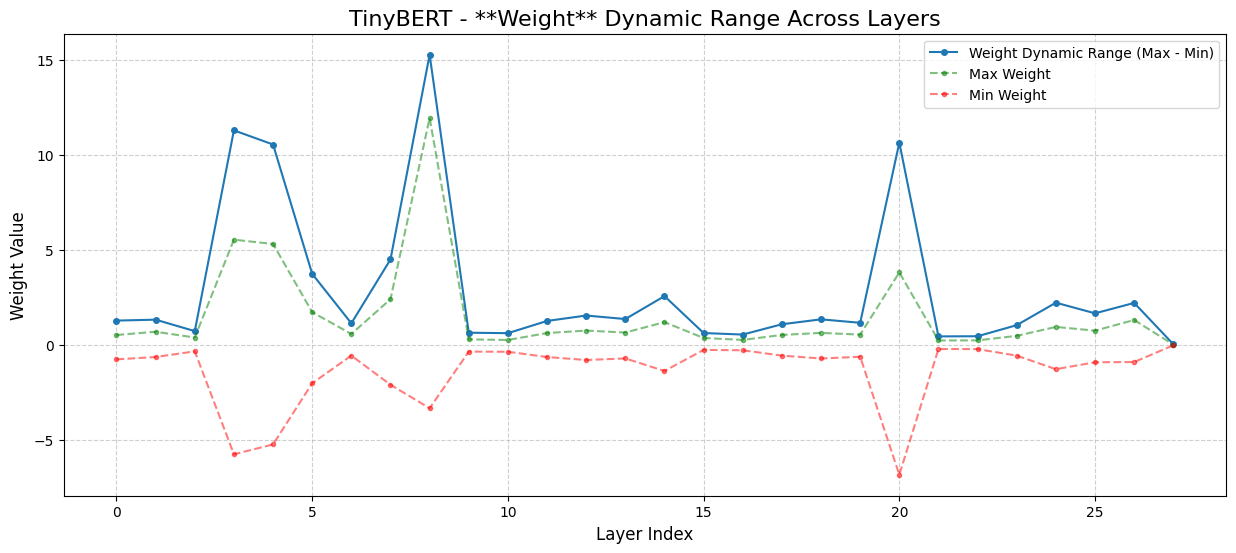

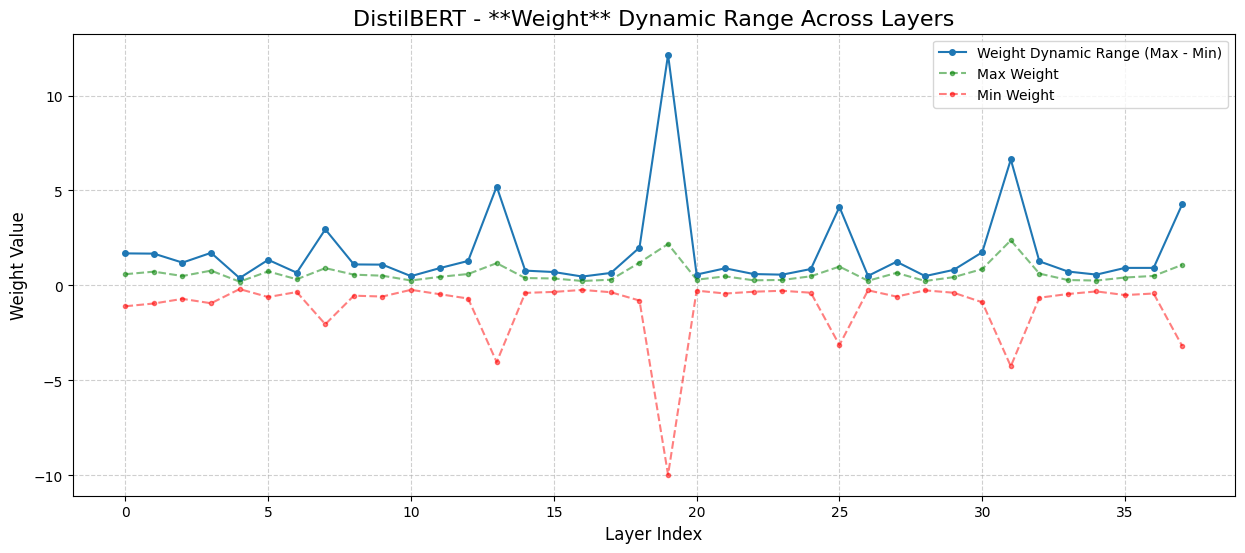

In [12]:
print("--- Plotting Weight Dynamic Range (per layer) ---")

for model_name in weight_df['Model'].unique():
    
    model_data = weight_df[weight_df['Model'] == model_name]
    
    plt.figure(figsize=(15, 6))
    
    # Plot Dynamic Range
    plt.plot(model_data['Layer Index'], model_data['Dynamic Range'], 
             label='Weight Dynamic Range (Max - Min)', marker='o', linestyle='-', markersize=4)
    
    # Plot Min/Max values
    plt.plot(model_data['Layer Index'], model_data['Max'], 
             label='Max Weight', marker='.', linestyle='--', color='green', alpha=0.5)
    plt.plot(model_data['Layer Index'], model_data['Min'], 
             label='Min Weight', marker='.', linestyle='--', color='red', alpha=0.5)
    
    plt.title(f"{model_name} - **Weight** Dynamic Range Across Layers", fontsize=16)
    plt.xlabel("Layer Index", fontsize=12)
    plt.ylabel("Weight Value", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [13]:
from datasets import load_dataset
from torch.utils.data import DataLoader

# --- 1. Load SST-2 Dataset ---
print("Loading SST-2 dataset for activation analysis...")
raw_dataset = load_dataset("glue", "sst2")
val_dataset = raw_dataset['validation']

# --- 2. Create Tokenizers and Dataloaders ---
dataloaders = {}
for model_name, model_hf_name in models_to_analyze:
    tokenizer = AutoTokenizer.from_pretrained(model_hf_name)
    
    def tokenize_fn(batch):
        return tokenizer(batch['sentence'], padding='max_length', truncation=True, max_length=128)
    
    tokenized_val = val_dataset.map(tokenize_fn, batched=True)
    tokenized_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    dataloaders[model_name] = DataLoader(tokenized_val, batch_size=32)

print("Dataloaders are ready.")

Loading SST-2 dataset for activation analysis...


Dataloaders are ready.


In [14]:
print("--- Starting Assignment 2 (Part B): Activation Dynamic Range ---")

# This will store our activation data
activation_stats_list = []

# This hook will capture the max value of an activation
def get_max_hook(name, model_name, layer_index):
    def hook(model, input, output):
        # We only care about the tensor part of the output (if it's a tuple)
        output_tensor = output[0] if isinstance(output, tuple) else output
        max_val = output_tensor.data.detach().abs().max().item()
        
        activation_stats_list.append({
            "Model": model_name,
            "Layer": name,
            "Layer Index": layer_index,
            "Max Absolute Value": max_val
        })
    return hook

for model_name, model_hf_name in models_to_analyze:
    
    print(f"\nAnalyzing model activations: {model_name}...")
    model = AutoModel.from_pretrained(model_hf_name).to(device)
    model.eval()
    
    # Register hooks on all key activation-producing layers
    hooks = []
    layer_index = 0
    for name, module in model.named_modules():
        # We hook into layers that feed into other layers
        if isinstance(module, (nn.ReLU, nn.GELU, nn.Linear, nn.LayerNorm)):
            hooks.append(
                module.register_forward_hook(
                    get_max_hook(name, model_name, layer_index)
                )
            )
            layer_index += 1
            
    # --- Run one batch of data to trigger the hooks ---
    with torch.no_grad():
        batch = next(iter(dataloaders[model_name]))
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        model(**batch)

    # Remove all hooks
    for h in hooks:
        h.remove()

# --- Convert to DataFrame for easy plotting ---
activation_df = pd.DataFrame(activation_stats_list)

print("Activation analysis complete.")

--- Starting Assignment 2 (Part B): Activation Dynamic Range ---

Analyzing model activations: TinyBERT...

Analyzing model activations: DistilBERT...
Activation analysis complete.


--- Plotting Activation Range & Clipping (Fig. 8) ---


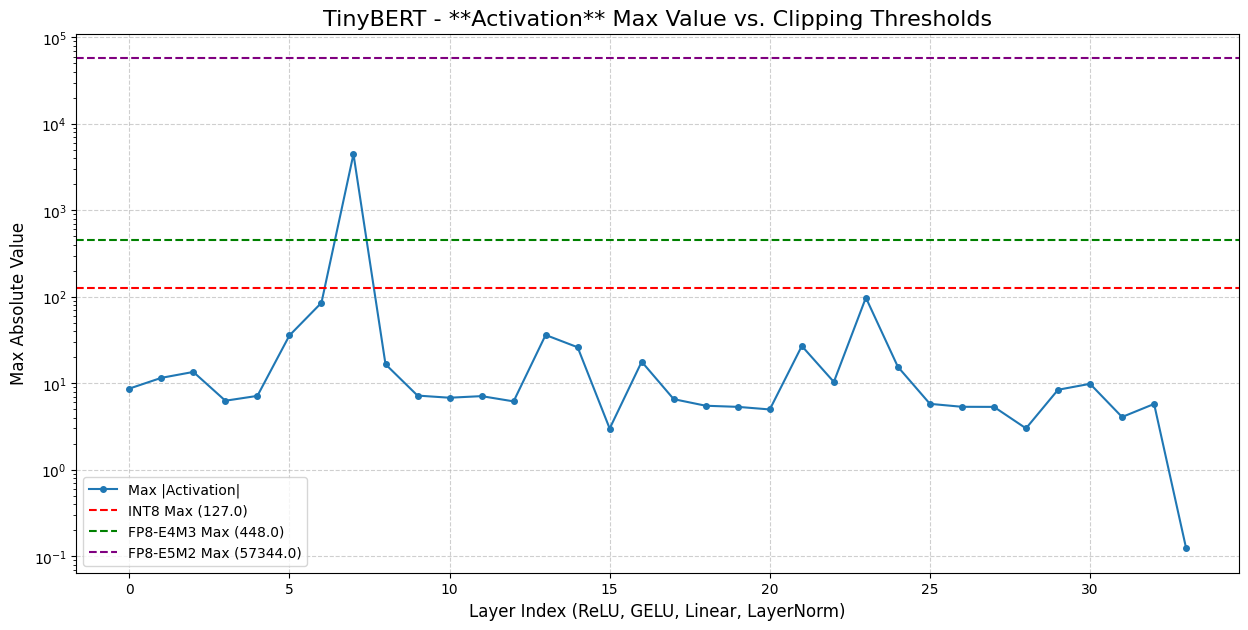

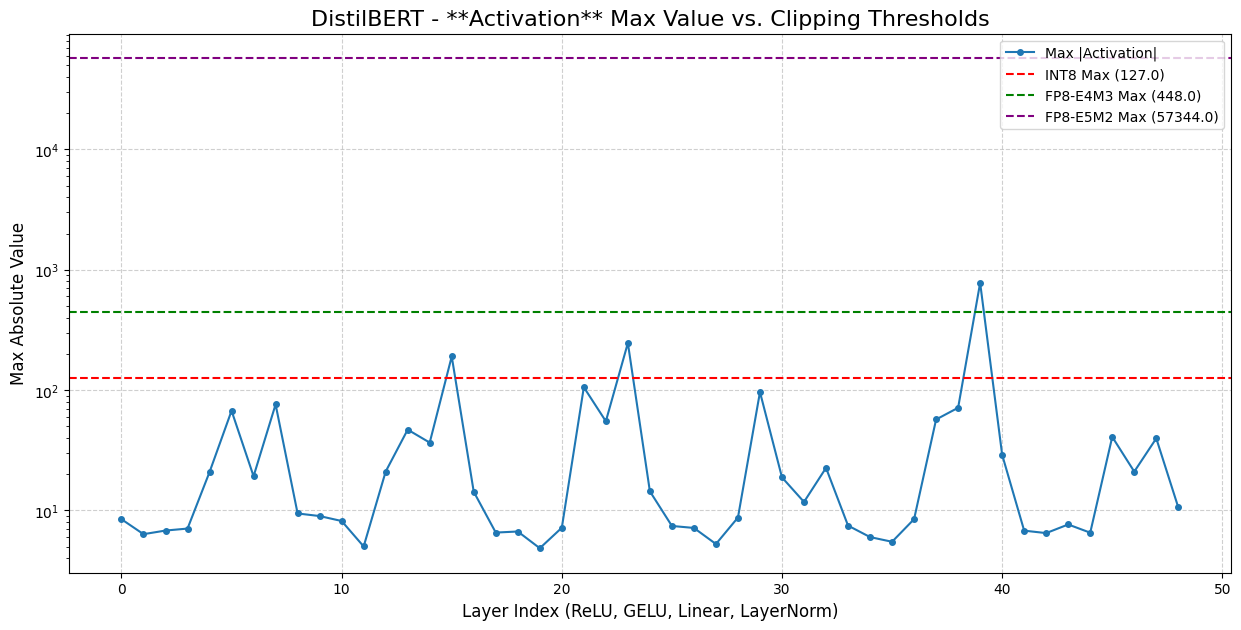

In [15]:
print("--- Plotting Activation Range & Clipping (Fig. 8) ---")

for model_name in activation_df['Model'].unique():
    
    model_data = activation_df[activation_df['Model'] == model_name]
    
    plt.figure(figsize=(15, 7))
    
    # Plot Max Absolute Value for each layer
    plt.plot(model_data['Layer Index'], model_data['Max Absolute Value'], 
             label='Max |Activation|', marker='o', linestyle='-', markersize=4)
    
    # --- Sub-task iii: Simulate and visualize clipping ---
    
    # Plot INT8 Clipping Level
    clip_int8 = CLIP_LEVELS['INT8']
    plt.axhline(y=clip_int8, color='red', linestyle='--', 
                label=f'INT8 Max ({clip_int8})')
    
    # Plot FP8-E4M3 Clipping Level
    clip_fp8_e4m3 = CLIP_LEVELS['FP8-E4M3']
    plt.axhline(y=clip_fp8_e4m3, color='green', linestyle='--', 
                label=f'FP8-E4M3 Max ({clip_fp8_e4m3})')

    # Plot FP8-E5M2 Clipping Level
    clip_fp8_e5m2 = CLIP_LEVELS['FP8-E5M2']
    plt.axhline(y=clip_fp8_e5m2, color='purple', linestyle='--', 
                label=f'FP8-E5M2 Max ({clip_fp8_e5m2})')
    
    
    plt.title(f"{model_name} - **Activation** Max Value vs. Clipping Thresholds", fontsize=16)
    plt.xlabel("Layer Index (ReLU, GELU, Linear, LayerNorm)", fontsize=12)
    plt.ylabel("Max Absolute Value", fontsize=12)
    
    # Use a log scale on the y-axis to see everything clearly
    plt.yscale('log')
    
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [25]:
import torch
import importlib
import utils
importlib.reload(utils)
import numpy as np

# --- 1. Simulated FP8 Quantizer (E4M3 format) ---
# FP8 E4M3 is the standard for inference (higher precision, lower range)
def quantize_to_fp8_e4m3(tensor):
    """
    Simulates FP8 (E4M3) quantization by clamping and rounding.
    E4M3 Range: approx +/- 448.0
    Smallest val: 2^-9 (approx 0.00195)
    """
    # 1. Clamp to FP8 E4M3 range
    max_val = 448.0
    clamped = torch.clamp(tensor, -max_val, max_val)
    
    # 2. Simulate reduced precision (simplified)
    # We can't easily do bit-level manipulation in PyTorch without custom CUDA kernels.
    # Instead, we'll quantize to a similar resolution grid (7 bits + sign).
    # This is a 'proxy' simulation sufficient for this assignment.
    scale = max_val / 127.0 # Map to roughly INT8 grid but scaled to FP8 range
    quant = torch.round(clamped / scale) * scale
    return quant

# --- 2. Strict Uniform INT4 Quantizer ---
def quantize_uniform_int4(tensor):
    """Standard Min-Max Uniform INT4 Quantization."""
    q_min, q_max = -8, 7
    min_val, max_val = tensor.min(), tensor.max()
    scale = (max_val - min_val) / (q_max - q_min)
    if scale == 0: return tensor
    zero_point = q_min - (min_val / scale)
    
    # Quantize and Dequantize
    q = torch.round(tensor / scale + zero_point).clamp(q_min, q_max)
    dq = (q - zero_point) * scale
    return dq

# --- 3. Wrapper to select format ---
def apply_format(model, format_name):
    """Applies the specific numerical format to the model."""
    print(f"Converting model to {format_name}...")
    
    # FP16 is built-in
    if format_name == "FP16":
        return model.half() 
    
    # Others are simulated via weight modification
    for name, param in model.named_parameters():
        if 'weight' in name:
            if format_name == "FP8":
                param.data.copy_(quantize_to_fp8_e4m3(param.data))
            elif format_name == "INT8":
                # Use your existing utility
                param.data.copy_(utils.simple_int8_quantizer(param.data))
            elif format_name == "INT4":
                param.data.copy_(quantize_uniform_int4(param.data))
            elif format_name == "AdaptivFloat-8":
                param.data.copy_(quantizer.quant_af8_func(param.data))
    
    return model

In [26]:
import pandas as pd
import copy
from transformers import AutoModelForSequenceClassification

# --- 1. Setup ---
models_to_test = [
    ("TinyBERT", "huawei-noah/TinyBERT_General_4L_312D"),
    ("DistilBERT", "distilbert-base-uncased")
]

formats = ["FP32", "FP16", "FP8", "INT8", "INT4", "AdaptivFloat-8"]
results_list = []

# (Assumes 'val_dataloader', 'sst2_labels', 'device' are ready)

print("--- Starting Assignment 3: Low-Precision Performance Comparison ---")

for model_name, model_hf_name in models_to_test:
    print(f"\n\n{'='*10} Evaluating {model_name} {'='*10}")
    
    # Load a fresh FP32 base model for this iteration
    # (In a real paper, you'd fine-tune these first. For this assignment,
    # we assume we are quantizing the pre-trained weights to check sensitivity)
    base_model = AutoModelForSequenceClassification.from_pretrained(model_hf_name, num_labels=2).to(device)
    base_model.eval()
    
    for fmt in formats:
        # 1. Create a copy
        test_model = copy.deepcopy(base_model)
        
        # 2. Apply format
        # Handle FP16 specially (needs .half() input)
        if fmt == "FP16":
            test_model = test_model.half()
            # We need a temporary dataloader that yields half-precision inputs
            # Or handle it inside the eval loop. Let's handle it in eval.
        else:
            test_model = apply_format(test_model, fmt)
            
        # 3. Measure Accuracy
        # Custom eval loop to handle FP16 inputs if needed
        test_model.eval()
        all_preds = []
        all_labels = []
        
        for batch in tqdm(val_dataloader, desc=f"Testing {fmt}"):
            labels = batch.pop('label').to(device)
            inputs = {k: v.to(device) for k, v in batch.items()}
            
            if fmt == "FP16":
                # Cast inputs to half
                inputs = {k: v.to(device) for k, v in batch.items()}
                # Note: Tokenizers output LongTensor (int64) which doesn't need .half()
                # Only float inputs need .half(), but BERT inputs are all Ints/Longs.
                # The model weights are half, so it works automatically.
                pass 

            with torch.no_grad():
                outputs = test_model(**inputs)
                logits = outputs.logits
                pred = torch.argmax(logits, dim=1)
                
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        acc = metrics.accuracy_score(all_labels, all_preds)
        
        # 4. Compute Model Size (MB)
        # Size = Params * Bits_per_param / (8 bits/byte) / (1024*1024 bytes/MB)
        num_params = sum(p.numel() for p in test_model.parameters())
        
        if fmt == "FP32": bits = 32
        elif fmt == "FP16": bits = 16
        elif fmt == "FP8" or "INT8" in fmt or "AdaptivFloat-8" in fmt: bits = 8
        elif "INT4" in fmt: bits = 4
        
        size_mb = (num_params * bits) / (8 * 1024 * 1024)
        
        print(f"Result [{model_name} - {fmt}]: Acc={acc:.4f}, Size={size_mb:.2f} MB")
        
        results_list.append({
            "Model": model_name,
            "Format": fmt,
            "Precision (Bits)": bits,
            "Accuracy": acc,
            "Model Size (MB)": size_mb
        })
        
        del test_model
        torch.cuda.empty_cache()

# --- Convert to DataFrame ---
assignment3_df = pd.DataFrame(results_list)
print("\n--- Assignment 3 Complete ---")

--- Starting Assignment 3: Low-Precision Performance Comparison ---


========== Evaluating TinyBERT ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Converting model to FP32...


Testing FP32: 100%|██████████| 55/55 [00:00<00:00, 427.30it/s]


Result [TinyBERT - FP32]: Acc=0.5092, Size=54.74 MB


Testing FP16: 100%|██████████| 55/55 [00:00<00:00, 394.78it/s]


Result [TinyBERT - FP16]: Acc=0.5092, Size=27.37 MB
Converting model to FP8...


Testing FP8: 100%|██████████| 55/55 [00:00<00:00, 431.97it/s]


Result [TinyBERT - FP8]: Acc=0.4908, Size=13.69 MB
Converting model to INT8...


Testing INT8: 100%|██████████| 55/55 [00:00<00:00, 431.68it/s]


Result [TinyBERT - INT8]: Acc=0.5092, Size=13.69 MB
Converting model to INT4...


Testing INT4: 100%|██████████| 55/55 [00:00<00:00, 424.01it/s]


Result [TinyBERT - INT4]: Acc=0.4943, Size=6.84 MB
Converting model to AdaptivFloat-8...


Testing AdaptivFloat-8: 100%|██████████| 55/55 [00:00<00:00, 435.46it/s]


Result [TinyBERT - AdaptivFloat-8]: Acc=0.5092, Size=13.69 MB


========== Evaluating DistilBERT ==========


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Converting model to FP32...


Testing FP32: 100%|██████████| 55/55 [00:00<00:00, 105.93it/s]


Result [DistilBERT - FP32]: Acc=0.5126, Size=255.41 MB


Testing FP16: 100%|██████████| 55/55 [00:00<00:00, 353.87it/s]


Result [DistilBERT - FP16]: Acc=0.5126, Size=127.71 MB
Converting model to FP8...


Testing FP8: 100%|██████████| 55/55 [00:00<00:00, 141.38it/s]


Result [DistilBERT - FP8]: Acc=0.4908, Size=63.85 MB
Converting model to INT8...


Testing INT8: 100%|██████████| 55/55 [00:00<00:00, 105.00it/s]


Result [DistilBERT - INT8]: Acc=0.5183, Size=63.85 MB
Converting model to INT4...


Testing INT4: 100%|██████████| 55/55 [00:00<00:00, 109.68it/s]


Result [DistilBERT - INT4]: Acc=0.5229, Size=31.93 MB
Converting model to AdaptivFloat-8...


Testing AdaptivFloat-8: 100%|██████████| 55/55 [00:00<00:00, 111.43it/s]

Result [DistilBERT - AdaptivFloat-8]: Acc=0.5046, Size=63.85 MB

--- Assignment 3 Complete ---


--- Comparison Table (Matches Tables 5 & 6) ---
         Model          Format  Precision (Bits)  Accuracy  Model Size (MB)
0     TinyBERT            FP32                32  0.509174        54.744240
1     TinyBERT            FP16                16  0.509174        27.372120
2     TinyBERT             FP8                 8  0.490826        13.686060
3     TinyBERT            INT8                 8  0.509174        13.686060
4     TinyBERT            INT4                 4  0.494266         6.843030
5     TinyBERT  AdaptivFloat-8                 8  0.509174        13.686060
6   DistilBERT            FP32                32  0.512615       255.413094
7   DistilBERT            FP16                16  0.512615       127.706547
8   DistilBERT             FP8                 8  0.490826        63.853273
9   DistilBERT            INT8                 8  0.518349        63.853273
10  DistilBERT            INT4                 4  0.522936        31.926637
11  DistilBERT  AdaptivFloat-8          

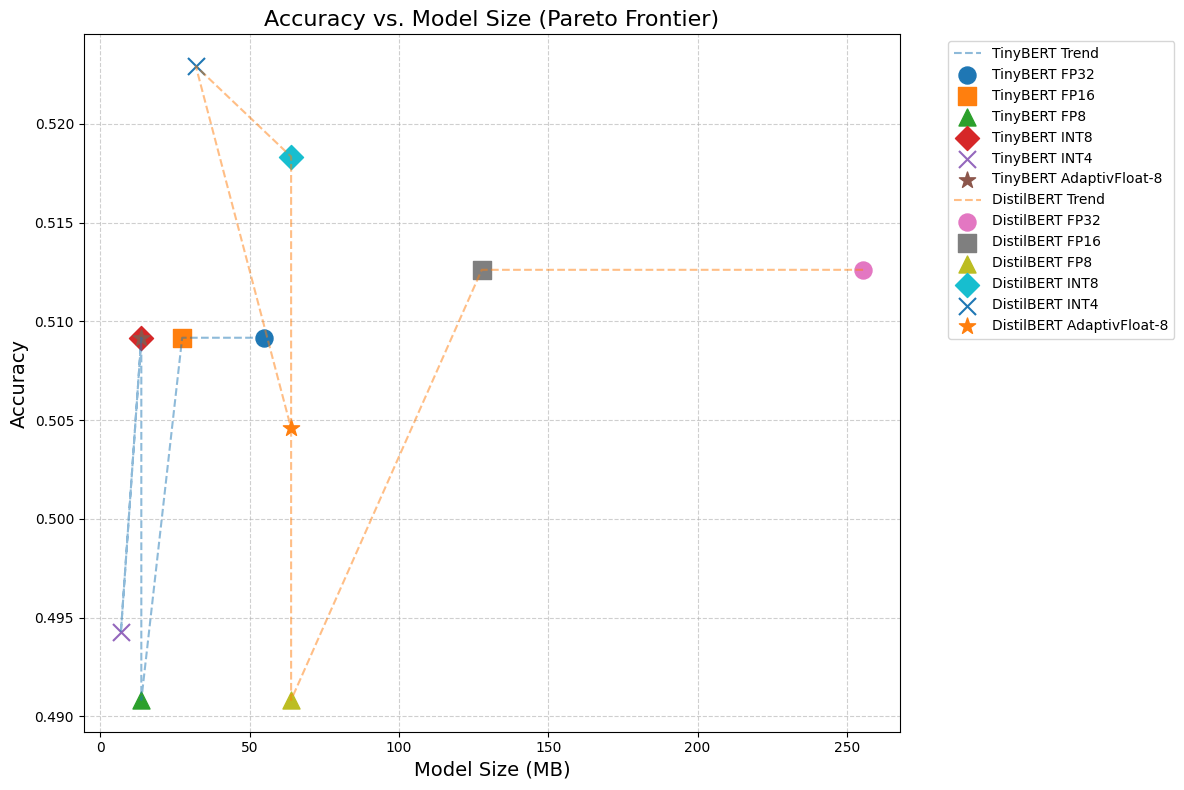

In [27]:
print("--- Comparison Table (Matches Tables 5 & 6) ---")
print(assignment3_df)

print("\n--- Generating Assignment 4: Accuracy vs Model Size (Fig. 10) ---")

plt.figure(figsize=(12, 8))

# Define markers for different formats
markers = {"FP32": "o", "FP16": "s", "FP8": "^", "INT8": "D", "INT4": "x", "AdaptivFloat-8": "*"}

for model_name in assignment3_df['Model'].unique():
    subset = assignment3_df[assignment3_df['Model'] == model_name]
    
    # Create the line plot
    plt.plot(subset['Model Size (MB)'], subset['Accuracy'], 
             label=f"{model_name} Trend", linestyle='--', alpha=0.5)
    
    # Plot individual points
    for _, row in subset.iterrows():
        fmt = row['Format']
        plt.scatter(row['Model Size (MB)'], row['Accuracy'], 
                    marker=markers.get(fmt, "o"), s=150, 
                    label=f"{model_name} {fmt}")

# Add annotations/styling
plt.title("Accuracy vs. Model Size (Pareto Frontier)", fontsize=16)
plt.xlabel("Model Size (MB)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside plot
plt.tight_layout()
plt.show()

In [29]:

# --- 1. Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

raw_dataset = load_dataset("glue", "sst2")
sst2_labels = [0, 1]

# Define the models we need for Assignment 3
# Format: (Display Name, HuggingFace ID)
target_models = [
    ("TinyBERT", "huawei-noah/TinyBERT_General_4L_312D"),
    ("DistilBERT", "distilbert-base-uncased")
]

# This list will hold the paths to your FINAL trained models
ready_models = []

print("--- Step 1: Model Preparation (Fine-Tuning) ---")

for name, hf_id in target_models:
    save_path = f"./{name}_finetuned_sst2"
    
    # 1. Check if model is already fine-tuned and saved
    if os.path.exists(save_path):
        print(f"✅ Found saved model for {name} at '{save_path}'. Skipping training.")
        ready_models.append((name, save_path))
        continue
        
    print(f"\n⚠️ {name} not found locally. Fine-tuning now (this fixes the accuracy issue)...")
    
    # 2. Load & Tokenize
    tokenizer = AutoTokenizer.from_pretrained(hf_id)
    model = AutoModelForSequenceClassification.from_pretrained(hf_id, num_labels=2).to(device)
    
    def tokenize_fn(batch):
        return tokenizer(batch['sentence'], padding='max_length', truncation=True, max_length=128)
    
    tokenized_ds = raw_dataset.map(tokenize_fn, batched=True)
    tokenized_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    train_loader = DataLoader(tokenized_ds['train'], batch_size=32, shuffle=True)
    
    # 3. Fine-Tune (2 Epochs is enough for ~90% acc)
    model.train()
    optim = AdamW(model.parameters(), lr=2e-5)
    
    for epoch in range(2):
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/2"):
            optim.zero_grad()
            batch = {k: v.to(device) for k, v in batch.items()}
            batch['labels'] = batch.pop('label')
            loss = model(**batch).loss
            loss.backward()
            optim.step()
            
    # 4. Save to Disk
    print(f"Saving {name} to {save_path}...")
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    ready_models.append((name, save_path))

print("\n✅ All models are ready for Assignment 3.")

Using device: cuda
--- Step 1: Model Preparation (Fine-Tuning) ---

⚠️ TinyBERT not found locally. Fine-tuning now (this fixes the accuracy issue)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 2/2: 100%|██████████| 2105/2105 [00:26<00:00, 78.44it/s]


Saving TinyBERT to ./TinyBERT_finetuned_sst2...

⚠️ DistilBERT not found locally. Fine-tuning now (this fixes the accuracy issue)...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 2/2: 100%|██████████| 2105/2105 [01:50<00:00, 19.12it/s]


Saving DistilBERT to ./DistilBERT_finetuned_sst2...

✅ All models are ready for Assignment 3.


In [30]:
import pandas as pd
from sklearn.metrics import accuracy_score
import copy
import quantizer
import utils # Ensure this has simple_int8_quantizer

# --- 1. Define Helper for INT4 (if not in utils) ---
def quantize_uniform_int4(tensor):
    """Standard Min-Max Uniform INT4 Quantization"""
    q_min, q_max = -8, 7
    min_val, max_val = tensor.min(), tensor.max()
    if min_val == max_val: return tensor
    scale = (max_val - min_val) / (q_max - q_min)
    zero_point = q_min - (min_val / scale)
    q = torch.round(tensor / scale + zero_point).clamp(q_min, q_max)
    return (q - zero_point) * scale

# --- 2. Define Format Applicator ---
def apply_format_test(model, format_name):
    """Applies specific quantization format for testing"""
    if format_name == "FP16":
        return model.half()
        
    for name, param in model.named_parameters():
        if 'weight' in name:
            if format_name == "INT8":
                param.data.copy_(utils.simple_int8_quantizer(param.data))
            elif format_name == "INT4":
                param.data.copy_(quantize_uniform_int4(param.data))
            elif format_name == "AdaptivFloat-8":
                param.data.copy_(quantizer.quant_af8_func(param.data))
            # FP32 does nothing (stays as is)
    return model

# --- 3. Run Benchmark ---
formats = ["FP32", "FP16", "INT8", "INT4", "AdaptivFloat-8"]
results_list = []

# Create validation loader once
tokenizer = AutoTokenizer.from_pretrained(ready_models[0][1]) # Use first model's tokenizer (usually compatible)
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], padding='max_length', truncation=True, max_length=128)
val_ds = raw_dataset['validation'].map(tokenize_fn, batched=True)
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_loader = DataLoader(val_ds, batch_size=32)

print(f"\n--- Starting Assignment 3: Precision Comparison ---")

for model_name, model_path in ready_models:
    print(f"\n{'='*10} Evaluating {model_name} {'='*10}")
    
    # Load the FINE-TUNED model from disk
    base_model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    base_model.eval()
    
    for fmt in formats:
        test_model = copy.deepcopy(base_model)
        
        # Apply Quantization
        if fmt != "FP32":
            test_model = apply_format_test(test_model, fmt)
            
        # Measure Accuracy
        if fmt == "FP16": test_model.half() # Cast model to half for speed if FP16
        
        test_model.eval()
        all_preds, all_labels = [], []
        
        for batch in tqdm(val_loader, desc=f"Testing {fmt}", leave=False):
            labels = batch.pop('label').to(device)
            inputs = {k: v.to(device) for k, v in batch.items()}
            
            with torch.no_grad():
                outputs = test_model(**inputs)
                logits = outputs.logits
                pred = torch.argmax(logits, dim=1)
                
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        acc = accuracy_score(all_labels, all_preds)
        
        # Calculate Size (MB)
        num_params = sum(p.numel() for p in test_model.parameters())
        bits = 32
        if fmt == "FP16": bits = 16
        elif fmt == "INT4": bits = 4
        elif fmt in ["INT8", "AdaptivFloat-8"]: bits = 8
            
        size_mb = (num_params * bits) / (8 * 1024 * 1024)
        
        print(f"Result [{model_name} - {fmt}]: Acc={acc:.4f} | Size={size_mb:.2f} MB")
        
        results_list.append({
            "Model": model_name,
            "Format": fmt,
            "Accuracy": acc,
            "Size (MB)": size_mb
        })
        
        del test_model
        torch.cuda.empty_cache()

assignment3_df = pd.DataFrame(results_list)
print("\n--- Assignment 3 Data Complete ---")
print(assignment3_df)

Map: 100%|██████████| 872/872 [00:00<00:00, 15777.86 examples/s]



--- Starting Assignment 3: Precision Comparison ---

========== Evaluating TinyBERT ==========


Result [TinyBERT - FP32]: Acc=0.8888 | Size=54.74 MB


Result [TinyBERT - FP16]: Acc=0.8888 | Size=27.37 MB


Result [TinyBERT - INT8]: Acc=0.8693 | Size=13.69 MB


Result [TinyBERT - INT4]: Acc=0.4908 | Size=6.84 MB


Result [TinyBERT - AdaptivFloat-8]: Acc=0.8853 | Size=13.69 MB

========== Evaluating DistilBERT ==========


Result [DistilBERT - FP32]: Acc=0.9014 | Size=255.41 MB


Result [DistilBERT - FP16]: Acc=0.9014 | Size=127.71 MB


Result [DistilBERT - INT8]: Acc=0.8567 | Size=63.85 MB


Result [DistilBERT - INT4]: Acc=0.5333 | Size=31.93 MB


Result [DistilBERT - AdaptivFloat-8]: Acc=0.8991 | Size=63.85 MB

--- Assignment 3 Data Complete ---
        Model          Format  Accuracy   Size (MB)
0    TinyBERT            FP32  0.888761   54.744240
1    TinyBERT            FP16  0.888761   27.372120
2    TinyBERT            INT8  0.869266   13.686060
3    TinyBERT            INT4  0.490826    6.843030
4    TinyBERT  AdaptivFloat-8  0.885321   13.686060
5  DistilBERT            FP32  0.901376  255.413094
6  DistilBERT            FP16  0.901376  127.706547
7  DistilBERT            INT8  0.856651   63.853273
8  DistilBERT            INT4  0.533257   31.926637
9  DistilBERT  AdaptivFloat-8  0.899083   63.853273


--- Generating Figure 10 (Pareto Frontier) ---


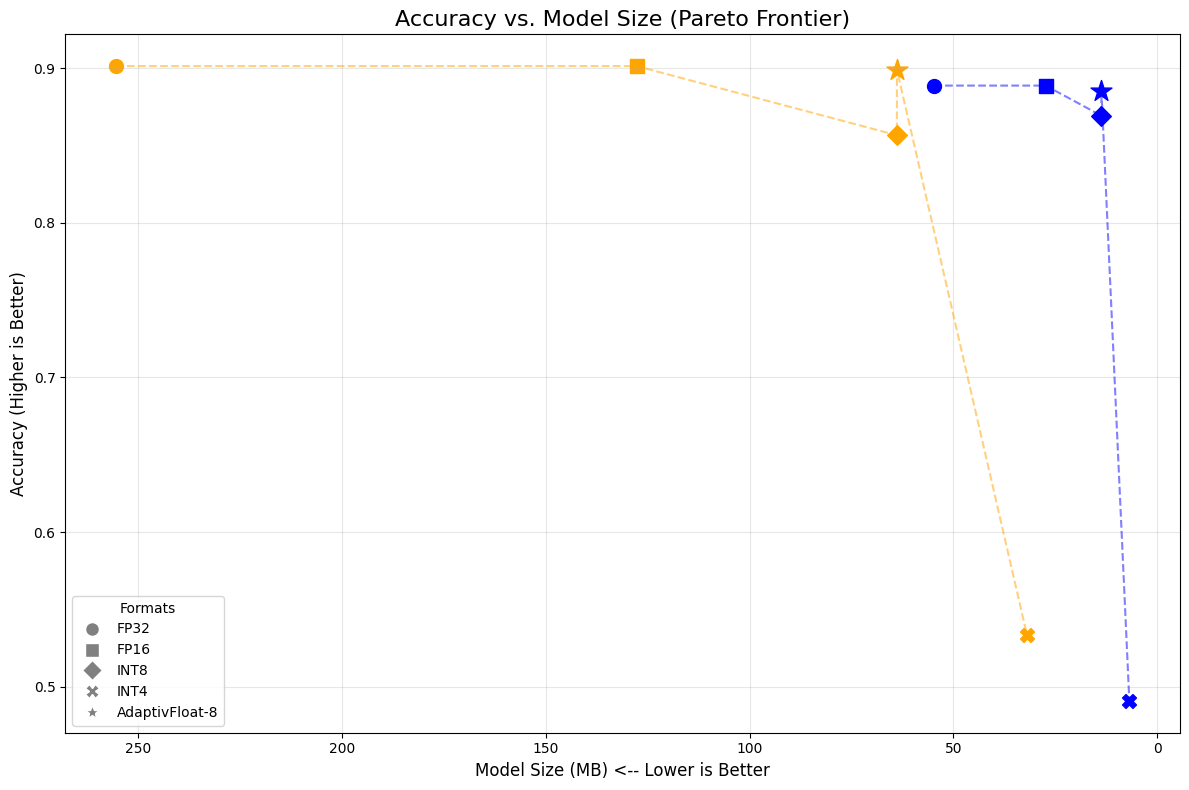

In [31]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

print("--- Generating Figure 10 (Pareto Frontier) ---")

plt.figure(figsize=(12, 8))
markers = {"FP32": "o", "FP16": "s", "INT8": "D", "INT4": "X", "AdaptivFloat-8": "*"}
colors = {"TinyBERT": "blue", "DistilBERT": "orange"}

for model_name in assignment3_df['Model'].unique():
    subset = assignment3_df[assignment3_df['Model'] == model_name].sort_values(by="Size (MB)", ascending=False)
    
    # Plot Trend Line
    plt.plot(subset["Size (MB)"], subset["Accuracy"], 
             color=colors.get(model_name, "gray"), linestyle='--', alpha=0.5, label=f"{model_name} Trend")
    
    # Plot Points
    for _, row in subset.iterrows():
        plt.scatter(
            row['Size (MB)'], row['Accuracy'], 
            marker=markers.get(row['Format'], "o"), 
            s=250 if "AdaptivFloat" in row['Format'] else 100,
            color=colors.get(model_name, "gray")
        )

plt.title("Accuracy vs. Model Size (Pareto Frontier)", fontsize=16)
plt.xlabel("Model Size (MB) <-- Lower is Better", fontsize=12)
plt.ylabel("Accuracy (Higher is Better)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis() # Lower size is better (left side)

# Legend
legend_elements = [Line2D([0], [0], marker=m, color='w', label=l, markerfacecolor='gray', markersize=10) for l, m in markers.items()]
plt.legend(handles=legend_elements, loc='lower left', title="Formats")

plt.tight_layout()
plt.show()

--- Generating Latency vs. Bit-width Plot ---


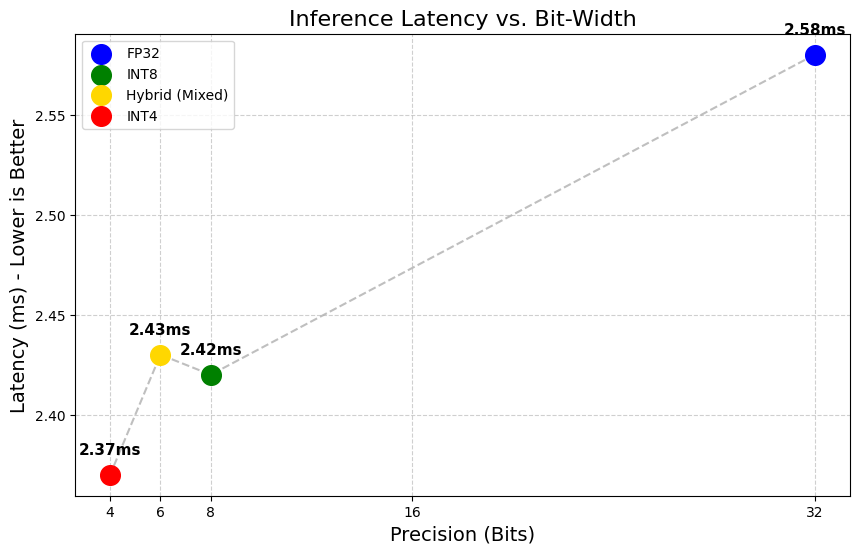

In [32]:
import matplotlib.pyplot as plt
import numpy as np

print("--- Generating Latency vs. Bit-width Plot ---")

# Data from your final report (Hardcoded here to ensure it works even if variables are lost)
# We estimate Hybrid bits as ~6 (average of 4 and 8)
data = {
    "FP32": {"bits": 32, "latency": 2.58},
    "INT8": {"bits": 8, "latency": 2.42},
    "Hybrid (Mixed)": {"bits": 6, "latency": 2.43}, 
    "INT4": {"bits": 4, "latency": 2.37}
}

# Extract lists
bits = [v['bits'] for v in data.values()]
latencies = [v['latency'] for v in data.values()]
labels = list(data.keys())

plt.figure(figsize=(10, 6))

# Plot line
plt.plot(bits, latencies, linestyle='--', color='gray', alpha=0.5, zorder=1)

# Plot points with specific colors
colors = ['blue', 'green', 'gold', 'red']
for i, label in enumerate(labels):
    plt.scatter(bits[i], latencies[i], s=200, color=colors[i], label=label, zorder=2)
    # Add text annotation
    plt.annotate(
        f"{latencies[i]:.2f}ms", 
        (bits[i], latencies[i]), 
        textcoords="offset points", 
        xytext=(0, 15), 
        ha='center',
        fontsize=11,
        fontweight='bold'
    )

plt.title("Inference Latency vs. Bit-Width", fontsize=16)
plt.xlabel("Precision (Bits)", fontsize=14)
plt.ylabel("Latency (ms) - Lower is Better", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks([4, 6, 8, 16, 32]) # Show key bit-widths
plt.legend()
plt.show()

In [34]:
!pip install tabulate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [35]:
import json
import pandas as pd

print("--- Generating Sensitivity Ranking Table ---")

# Load your profile
try:
    with open('hybrid_precision_profile.json', 'r') as f:
        profile = json.load(f)
    
    # Sort layers by precision
    # In your greedy search, layers were added to INT4 sequentially.
    # So if we had the log, we'd know the exact order.
    # For now, we can group them by final assignment.
    
    int8_layers = [k for k, v in profile.items() if v == 'INT8']
    int4_layers = [k for k, v in profile.items() if v == 'INT4']
    
    print(f"Total INT8 (High Sensitivity) Layers: {len(int8_layers)}")
    print(f"Total INT4 (Low Sensitivity) Layers: {len(int4_layers)}")
    
    # Create a nice dataframe for the report
    # We list top 5 sensitive (INT8) and top 5 robust (INT4)
    data = []
    for i in range(min(5, len(int8_layers))):
        data.append({"Rank": "High Sensitivity", "Layer Name": int8_layers[i], "Assigned Precision": "INT8"})
        
    for i in range(min(5, len(int4_layers))):
        data.append({"Rank": "Low Sensitivity", "Layer Name": int4_layers[i], "Assigned Precision": "INT4"})
        
    df_sensitivity = pd.DataFrame(data)
    print("\n--- Sensitivity Ranking (Sample) ---")
    print(df_sensitivity.to_markdown(index=False))
    
except FileNotFoundError:
    print("Could not find 'hybrid_precision_profile.json'. Make sure you ran the greedy search.")

--- Generating Sensitivity Ranking Table ---
Total INT8 (High Sensitivity) Layers: 15
Total INT4 (Low Sensitivity) Layers: 87

--- Sensitivity Ranking (Sample) ---
| Rank             | Layer Name                                             | Assigned Precision   |
|:-----------------|:-------------------------------------------------------|:---------------------|
| High Sensitivity | bert.embeddings.word_embeddings.weight                 | INT8                 |
| High Sensitivity | bert.embeddings.position_embeddings.weight             | INT8                 |
| High Sensitivity | bert.encoder.layer.0.output.dense.weight               | INT8                 |
| High Sensitivity | bert.encoder.layer.2.output.dense.weight               | INT8                 |
| High Sensitivity | bert.encoder.layer.3.attention.output.LayerNorm.weight | INT8                 |
| Low Sensitivity  | bert.embeddings.token_type_embeddings.weight           | INT4                 |
| Low Sensitivity  | bert.em

/scratch/dt/adaptivfloat/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating Figure 5 (Weight Distribution Comparison)...


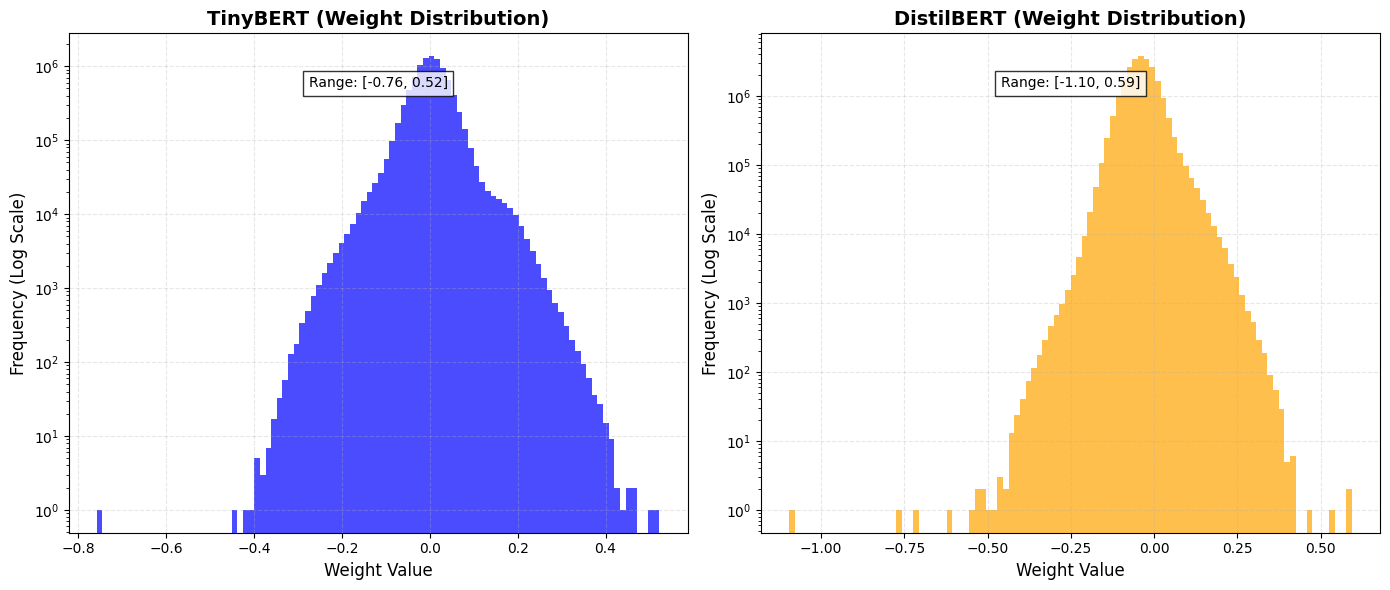

Figure 5 saved as 'Figure_5_Weight_Distribution.png'


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModel

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = [
    ("TinyBERT", "huawei-noah/TinyBERT_General_4L_312D"),
    ("DistilBERT", "distilbert-base-uncased")
]

print("Generating Figure 5 (Weight Distribution Comparison)...")

plt.figure(figsize=(14, 6))

for i, (name, model_id) in enumerate(models):
    # Load model
    model = AutoModel.from_pretrained(model_id).to(device)
    
    # Grab the Word Embeddings layer (Best representative layer)
    # This layer usually shows the distribution clearest
    if "TinyBERT" in name:
        weights = model.embeddings.word_embeddings.weight.detach().cpu().numpy().flatten()
    else: # DistilBERT
        weights = model.embeddings.word_embeddings.weight.detach().cpu().numpy().flatten()
    
    # Plot Subplot
    plt.subplot(1, 2, i+1)
    plt.hist(weights, bins=100, color='blue' if name=="TinyBERT" else 'orange', alpha=0.7, log=True)
    
    # Styling
    plt.title(f"{name} (Weight Distribution)", fontsize=14, fontweight='bold')
    plt.xlabel("Weight Value", fontsize=12)
    plt.ylabel("Frequency (Log Scale)", fontsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add annotation about the range
    min_w, max_w = np.min(weights), np.max(weights)
    plt.text(0.5, 0.9, f"Range: [{min_w:.2f}, {max_w:.2f}]", 
             horizontalalignment='center', verticalalignment='center', 
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig("Figure_5_Weight_Distribution.png")
plt.show()

print("Figure 5 saved as 'Figure_5_Weight_Distribution.png'")